In [1]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None,
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):

        color = next(color_cycle)

        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception(
                'problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i + 1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)


def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')


def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1,
                             speed_profile=True):
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values

    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x'] ** 2 + df['speed_y'] ** 2) ** 0.5

    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold

    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1, fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[
                          0] - 1  # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]

    saccade_dict = {'saccade_start_ind': saccade_on_inds,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind': saccade_off_inds,
                    'saccade_end_timestamp': saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}

    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)

    distances = []
    angles = []
    speed_list = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) &
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            speed_list.append(saccade_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                                   endpoint['center_x'] - initial_position['center_x'])

        angles.append(overall_angle)
        distances.append(distance_traveled)

    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(
        angles) % 360)  # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df[
        'initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df[
        'initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)

    return df, saccade_events_df


# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict


In [2]:
# Example usage:
# This was the previous run
#animals = ['PV_62', 'PV_126', 'PV_57']
#block_lists = [[24, 26, 38], [7, 8, 9, 10, 11, 12], [7, 8, 9, 12, 13]]
#This with new animals:
animals = ['PV_106','PV_143','PV_62','PV_126', 'PV_57']
block_lists = [[8,9,10,11,12],[1,2,3,4],[24, 26, 38],[7, 8, 9, 10, 11, 12], [7, 8, 9, 12, 13]]
experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks
)
for block in block_collection:
    print(f'working on {block}')
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    #block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    #load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later

instantiated block number 008 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_008, new OE version
Found the sample rate for block 008 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 008
got it!
instantiated block number 009 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_009, new OE version
Found the sample rate for block 009 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 009
got it!
instantiated block number 010 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_010, new OE version
Found the sample rate for block 010 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 010
got it!
instantiated block number 011 at Path: Z:\Nimrod\exp

In [3]:
    for block in block_collection:
        print('working on {}'.format(block))
        # block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_corr_angles.csv')
        # block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_corr_angles.csv')
        #block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_raw_xflipped.csv')
        #block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_raw_xflipped.csv')
        block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_raw_verified.csv')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_raw_verified.csv')
        # block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_3d_corr_verified.csv')
        # block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_3d_corr_verified.csv')
        #block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_rotated_verified.csv')
        #block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_rotated_verified.csv')

    # calibrate pupil diameter:
    # if 'pupil_diameter' not in block.left_eye_data.columns:
    #     block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax * 2 * np.pi
    #     block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax * 2 * np.pi
    #     block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
    #     block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

working on PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19
working on PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43
working on PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43
working on PV_106, block 011, on PV106_ET_d3t4_2025-08-06_12-44-30
working on PV_106, block 012, on PV106_ET_d3t5_2025-08-06_13-21-30
working on PV_143, block 001, on PV143_ET_d1t1_2025-08-11_13-29-08
working on PV_143, block 002, on PV143_ET_d1t2_2025-08-11_13-50-11
working on PV_143, block 003, on PV143_ET_d1t3_2025-08-11_14-20-35
working on PV_143, block 004, on PV143_ET_d1t4_2025-08-11_14-58-28
working on PV_62, block 024, on 2023-04-27_11-22-56
working on PV_62, block 026, on 2023-04-27_12-21-41
working on PV_62, block 038, on 2023-05-01_13-57-45
working on PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
working on PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
working on PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15
working on PV_126, bloc

In [ ]:
block_collection

In [4]:
for block in block_collection:
  if 'pupil_diameter' not in block.left_eye_data.columns:
        print(f'calculating pupil diameter for {block} ')
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

calculating pupil diameter for PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19 
calculating pupil diameter for PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43 
calculating pupil diameter for PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43 
calculating pupil diameter for PV_106, block 011, on PV106_ET_d3t4_2025-08-06_12-44-30 
calculating pupil diameter for PV_106, block 012, on PV106_ET_d3t5_2025-08-06_13-21-30 
calculating pupil diameter for PV_143, block 001, on PV143_ET_d1t1_2025-08-11_13-29-08 
calculating pupil diameter for PV_143, block 002, on PV143_ET_d1t2_2025-08-11_13-50-11 
calculating pupil diameter for PV_143, block 003, on PV143_ET_d1t3_2025-08-11_14-20-35 
calculating pupil diameter for PV_143, block 004, on PV143_ET_d1t4_2025-08-11_14-58-28 
calculating pupil diameter for PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12 
calculating pupil diameter for PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41 
calculating pupil dia

In [ ]:
# # uncomment to switch corrected values to k_phi / theta columns
# for block in block_collection:
#     block.left_eye_data.drop(columns=['k_phi', 'k_theta'], inplace=True)
#     block.right_eye_data.drop(columns=['k_phi', 'k_theta'], inplace=True)
#     # then rename in-place
#     block.left_eye_data = block.left_eye_data.rename(columns={'corr_phi': 'k_phi', 'corr_theta': 'k_theta'})
#     block.right_eye_data = block.right_eye_data.rename(columns={'corr_phi': 'k_phi', 'corr_theta': 'k_theta'})

In [5]:
def create_saccade_events_with_direction_segmentation_robust(
        eye_data_df,
        speed_threshold,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=25,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2,
        min_net_disp=0.5  # minimal net angular displacement (in degrees) for a segment to be valid
):
    """
    Detects and segments saccade events in eye tracking data using angular speed and directional changes.
    This robust version avoids producing segments with near-zero net displacement by:
      1. Defining the saccade onset as the first frame where the angular speed exceeds the threshold.
      2. Segmenting the event based on sustained directional changes.
      3. Discarding segments whose overall net angular displacement (computed from k_phi and k_theta)
         is below a user-specified minimal value.

    Parameters:
      - eye_data_df (pd.DataFrame): DataFrame with columns including:
            'center_x', 'center_y', 'k_phi', 'k_theta', 'OE_timestamp', 'ms_axis', 'pupil_diameter'.
      - speed_threshold (float): Angular speed threshold (degrees/frame) for detection.
      - directional_delta_threshold_deg (float): Angular change threshold to determine segmentation boundaries.
      - magnitude_calib (float): Calibration factor (not applied to angular measures).
      - speed_profile (bool): Whether to record speed profiles.
      - min_subsaccade_samples (int): Minimum number of samples required for a valid segment.
      - min_net_disp (float): Minimal net angular displacement (in degrees) required for a segment to be kept.

    Returns:
      - df (pd.DataFrame): The input DataFrame with added computed columns.
      - saccade_events_df (pd.DataFrame): DataFrame listing detected and segmented saccade events, with metrics.
    """
    # Make a copy so as not to modify the original DataFrame.
    df = eye_data_df.copy()

    ### 1. Compute Frame-to-Frame Differences
    df["speed_x"] = df["center_x"].diff()
    df["speed_y"] = df["center_y"].diff()
    df["speed_r"] = np.sqrt(df["speed_x"] ** 2 + df["speed_y"] ** 2)

    # Angular differences (k_phi and k_theta are in degrees)
    df["angular_speed_phi"] = df["k_phi"].diff()
    df["angular_speed_theta"] = df["k_theta"].diff()
    df["angular_speed_r"] = np.sqrt(df["angular_speed_phi"] ** 2 + df["angular_speed_theta"] ** 2)

    ### 2. Saccade Detection Based on Angular Speed
    # Mark frames where the instantaneous angular speed exceeds the threshold.
    df["is_saccade_angle"] = df["angular_speed_r"] > speed_threshold

    # Identify transitions to detect onsets and offsets.
    saccade_on_off = df["is_saccade_angle"].astype(int) - df["is_saccade_angle"].shift(1, fill_value=0).astype(int)
    # Use the first frame above threshold as onset
    saccade_on_inds = np.where(saccade_on_off == 1)[0]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]

    # Handle mismatches: if a saccade starts but does not end, drop the last onset.
    if len(saccade_on_inds) > len(saccade_off_inds):
        saccade_on_inds = saccade_on_inds[:-1]

    saccade_events = []

    ### 3. Process Each Detected Saccade for Segmentation
    for start_ind, end_ind in zip(saccade_on_inds, saccade_off_inds):
        saccade_df = df.iloc[start_ind:end_ind + 1].copy()
        if saccade_df.empty or len(saccade_df) < min_subsaccade_samples:
            continue

        # Compute instantaneous angles (for both pixel- and angular-based estimates)
        saccade_df["inst_angle_pixel"] = np.degrees(np.arctan2(saccade_df["speed_y"], saccade_df["speed_x"]))
        saccade_df["inst_angle_deg"] = np.degrees(
            np.arctan2(saccade_df["angular_speed_theta"], saccade_df["angular_speed_phi"]))

        # Define helper function for minimal angular difference (handling circularity)
        minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180

        angles = saccade_df["inst_angle_deg"].values
        # Compute consecutive differences
        angle_diffs = np.array([minimal_angle_diff_deg(angles[i + 1], angles[i]) for i in range(len(angles) - 1)])

        # Identify candidate segmentation boundaries when the absolute change exceeds threshold.
        candidate_boundaries = np.where(np.abs(angle_diffs) > directional_delta_threshold_deg)[0].tolist()

        # Always include the first and last frame of the saccade.
        boundaries = [0] + candidate_boundaries + [len(saccade_df) - 1]

        # Process each segment defined by these boundaries.
        for i in range(len(boundaries) - 1):
            seg_start = boundaries[i]
            seg_end = boundaries[i + 1]
            subsaccade = saccade_df.iloc[seg_start: seg_end + 1]
            if len(subsaccade) < min_subsaccade_samples:
                continue

            # Compute net angular displacement using the angular positions (k_phi and k_theta)
            initial_pos_angle = subsaccade.iloc[0][["k_phi", "k_theta"]]
            final_pos_angle = subsaccade.iloc[-1][["k_phi", "k_theta"]]
            net_disp = np.sqrt((final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]) ** 2 +
                               (final_pos_angle["k_theta"] - initial_pos_angle["k_theta"]) ** 2)

            # Only record segments whose net displacement is above min_net_disp.
            if net_disp < min_net_disp:
                continue

            # Timing and indices
            sub_start_timestamp = subsaccade["OE_timestamp"].iloc[0]
            sub_end_timestamp = subsaccade["OE_timestamp"].iloc[-1]
            sub_start_ms = subsaccade["ms_axis"].iloc[0]
            sub_end_ms = subsaccade["ms_axis"].iloc[-1]
            sub_length = subsaccade.index[-1] - subsaccade.index[0]

            # Pixel-based metrics
            magnitude_raw_pixel = subsaccade["speed_r"].sum()
            magnitude_pixel = magnitude_raw_pixel * magnitude_calib

            # Angular-based metric: sum of instantaneous angular speeds
            magnitude_raw_angular = subsaccade["angular_speed_r"].sum()

            # Overall angular-based angle (from start to end)
            overall_angle_deg = (np.degrees(np.arctan2(
                final_pos_angle["k_theta"] - initial_pos_angle["k_theta"],
                final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]
            )) % 360)

            # (Optional) Capture speed profiles and other details
            speed_profile_pixel = subsaccade["speed_r"].values if speed_profile else None
            speed_profile_pixel_calib = (speed_profile_pixel * magnitude_calib) if speed_profile else None
            speed_profile_angular = subsaccade["angular_speed_r"].values if speed_profile else None
            diameter_profile = subsaccade["pupil_diameter"].values

            saccade_events.append({
                "saccade_start_ind": subsaccade.index[0],
                "saccade_end_ind": subsaccade.index[-1],
                "saccade_start_timestamp": sub_start_timestamp,
                "saccade_end_timestamp": sub_end_timestamp,
                "saccade_on_ms": sub_start_ms,
                "saccade_off_ms": sub_end_ms,
                "length": sub_length,
                "magnitude_raw_pixel": magnitude_raw_pixel,
                "magnitude_pixel": magnitude_pixel,
                "magnitude_raw_angular": magnitude_raw_angular,
                "overall_angle_deg": overall_angle_deg,
                "net_angular_disp": net_disp,
                "speed_profile_pixel": speed_profile_pixel,
                "speed_profile_pixel_calib": speed_profile_pixel_calib,
                "speed_profile_angular": speed_profile_angular,
                "diameter_profile": diameter_profile,
                "theta_init_pos": initial_pos_angle["k_theta"],
                "theta_end_pos": final_pos_angle["k_theta"],
                "phi_init_pos": initial_pos_angle["k_phi"],
                "phi_end_pos": final_pos_angle["k_phi"]
            })

    # Convert the list to a DataFrame.
    saccade_events_df = pd.DataFrame(saccade_events)

    # Optionally remove intermediate column
    df.drop(["is_saccade_angle"], axis=1, inplace=True)

    # Calculate delta columns for convenience.
    if not saccade_events_df.empty:
        saccade_events_df['delta_theta'] = saccade_events_df['theta_end_pos'] - saccade_events_df['theta_init_pos']
        saccade_events_df['delta_phi'] = saccade_events_df['phi_end_pos'] - saccade_events_df['phi_init_pos']

    return df, saccade_events_df


In [6]:

for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_with_direction_segmentation_robust(
        block.left_eye_data,
        0.6,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=90,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_with_direction_segmentation_robust(
        block.right_eye_data,
        0.6,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=90,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2)


PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19
PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43
PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43
PV_106, block 011, on PV106_ET_d3t4_2025-08-06_12-44-30
PV_106, block 012, on PV106_ET_d3t5_2025-08-06_13-21-30
PV_143, block 001, on PV143_ET_d1t1_2025-08-11_13-29-08
PV_143, block 002, on PV143_ET_d1t2_2025-08-11_13-50-11
PV_143, block 003, on PV143_ET_d1t3_2025-08-11_14-20-35
PV_143, block 004, on PV143_ET_d1t4_2025-08-11_14-58-28
PV_62, block 024, on 2023-04-27_11-22-56
PV_62, block 026, on 2023-04-27_12-21-41
PV_62, block 038, on 2023-05-01_13-57-45
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57
PV_126, block 011, on PV126_Trial115_eyeTracking_w7
PV_126, block 012, on PV126_Trial116_eyeTracking_h8
PV_57, block 007, on p

In [7]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    # collect accelerometer data
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:]}

        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        mat_data.close()
        block.liz_mov_df = acc_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print('mat file does not exist - run the matlab getLizMovement function')

    return


# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms

        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]

        if overlapping_mov_times.size > 0:
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

# Create a list to store blocks where movement data exists
block_collection_w_mov = []

for block in block_collection:
    try:
        block_get_lizard_movement(block)  # Try loading movement data
        label_saccade_movements(block)    # Try labeling saccades

        # If both steps succeed, add block to the valid collection
        block_collection_w_mov.append(block)

    except (FileNotFoundError, OSError) as e:
        print(f"Skipping block {block}: {str(e)}")  # Notify which block failed


path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_008\oe_files\PV106_ET_d3t12025-08-06_11-52-19\Record Node 102\analysis\recNames=Block008,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_009\oe_files\PV106_ET_d3t2_2025-08-06_12-09-43\Record Node 102\analysis\recNames=Block009,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_010\oe_files\PV106_ET_d3t3_2025-08-06_12-26-43\Record Node 102\analysis\recNames=Block010,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_011\oe_files\PV106_ET_d3t4_2025-08-06_12-44-30\Record Node 102\analysis\recNames=Block011,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 011,

In [8]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])

In [9]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [10]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])

    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')

    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


1187it [00:00, 8419.24it/s]
430it [00:00, 7052.31it/s]
572it [00:00, 8534.29it/s]

121 573
123 372



1432it [00:00, 8001.49it/s]

111 341



837it [00:00, 8408.36it/s]

417 1061
429 775



563it [00:00, 4171.31it/s]
350it [00:00, 7684.53it/s]
432it [00:00, 7451.60it/s]

235 586
144 337



301it [00:00, 8606.19it/s]
732it [00:00, 7763.95it/s]

348 604
100 227



709it [00:00, 7499.75it/s]

315 744
450 885



1237it [00:00, 7780.12it/s]
708it [00:00, 7011.92it/s]

1291 1935


1513it [00:00, 6847.11it/s]
460it [00:00, 7415.93it/s]
232it [00:00, 7030.00it/s]

455 1402
323 592



300it [00:00, 6976.71it/s]
0it [00:00, ?it/s]

351 513
198 393


1155it [00:00, 5021.73it/s]
128it [00:00, 7111.44it/s]
1029it [00:00, 6998.69it/s]

568 1322
64 148



1026it [00:00, 6535.10it/s]

2024 2615



854it [00:00, 7115.29it/s]

512 1186



849it [00:00, 6580.04it/s]

540 972



1075it [00:00, 6179.59it/s]

320 842


601 1318


In [11]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df

synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


In [12]:
all_saccade_collection = pd.concat([synced_saccade_collection,non_synced_saccade_collection])


In [15]:
import pathlib
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle

def create_saccade_polar_histogram_multianimal(saccade_collection,
                                               figure_size=(8, 4),
                                               export_path=None):
    animals = saccade_collection['animal'].unique()
    num_bins = 36

    fig, axs = plt.subplots(1, 2,
                            figsize=figure_size, dpi=300,
                            subplot_kw=dict(projection='polar'))
    colors = plt.cm.viridis(np.linspace(0, 1, len(animals)))

    for color, animal in zip(colors, animals):
        df_animal = saccade_collection.query('animal == @animal')

        # --- Right eye ---
        angles_r = df_animal.query('eye == "R"')['overall_angle_deg']
        hist_r, edges_r = np.histogram(angles_r,
                                       bins=num_bins,
                                       range=(0, 360),
                                       density=True)

        # compute mid‐bin centers as a float64 array
        centers_r = (edges_r[:-1] + edges_r[1:]) / 2.0
        centers_r = np.asarray(centers_r, dtype=float)

        # manual deg→rad
        theta_r = centers_r * (np.pi / 180.0)

        # close the loop
        theta_r = np.concatenate([theta_r, theta_r[:1]])
        hist_r   = np.concatenate([hist_r,   hist_r[:1]])

        axs[0].plot(theta_r, hist_r,
                    label=f"{animal} ({len(angles_r)})",
                    color=color)

        # --- Left eye (same) ---
        angles_l = df_animal.query('eye == "L"')['overall_angle_deg']
        hist_l, edges_l = np.histogram(angles_l,
                                       bins=num_bins,
                                       range=(0, 360),
                                       density=True)

        centers_l = (edges_l[:-1] + edges_l[1:]) / 2.0
        centers_l = np.asarray(centers_l, dtype=float)
        theta_l   = centers_l * (np.pi / 180.0)

        theta_l = np.concatenate([theta_l, theta_l[:1]])
        hist_l  = np.concatenate([hist_l,  hist_l[:1]])

        axs[1].plot(theta_l, hist_l,
                    label=f"{animal} ({len(angles_l)})",
                    color=color)
    # Add a shaded area for probability = 0.005 in both subplots.
    for ax in axs:
        theta = np.linspace(0, 2 * np.pi, 500)
        ax.fill_between(theta, 0, 0.005, color='gray', alpha=0.2, zorder=0, label='0.005 Prob.')

    # format
    for ax in axs:
        ax.legend(loc='upper right',
                  bbox_to_anchor=(1.2, 1.1),
                  fontsize=6)
        ax.set_yticks([])
        ax.grid(False)

    plt.tight_layout()

    if export_path:
        ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        outdir = pathlib.Path(export_path) / f"{ts}_MultiAnimal_Saccade_Histogram"
        outdir.mkdir(parents=True, exist_ok=True)

        pdf = outdir / f"{ts}_saccade_angles_histogram.pdf"
        plt.savefig(pdf)
        print("Exported histogram to", pdf)

        pkl = outdir / f"{ts}_saccade_angles_data.pkl"
        with open(pkl, 'wb') as f:
            pickle.dump(saccade_collection, f)
        print("Exported data to", pkl)

    plt.show()


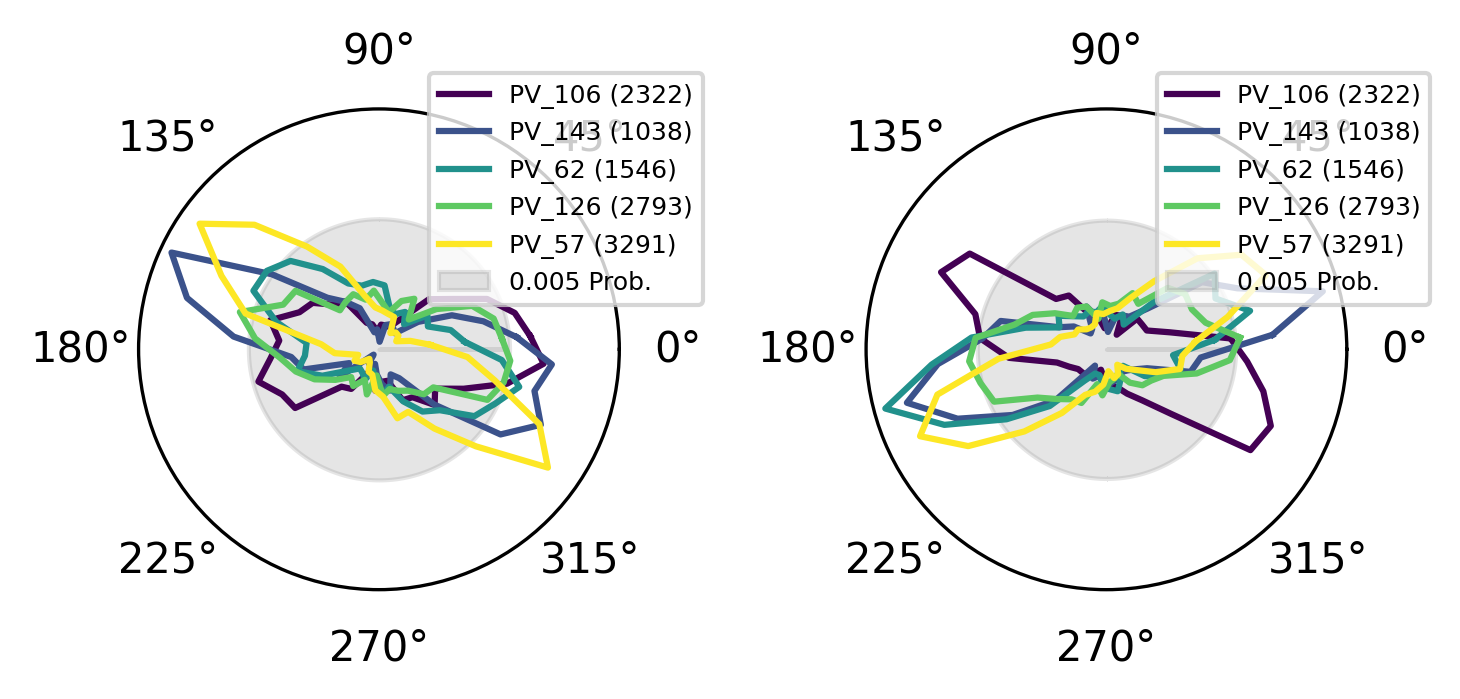

In [16]:
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

In [57]:
import numpy as _np
import pandas as _pd
import matplotlib.pyplot as _plt
import datetime as _dt
import pathlib as _pl
import pickle as _pkl

def _clean_angles_deg(series_like):
    """Return a 1D float64 numpy array of angles in [0, 360) with non-finite removed."""
    a = _pd.to_numeric(series_like, errors='coerce').to_numpy(dtype='float64')
    a = a[_np.isfinite(a)]
    # map into [0, 360)
    a = _np.mod(a, 360.0)
    return a

def _hist_deg(angles_deg, num_bins=36):
    """Histogram in degrees over [0, 360). Returns (density, bin_edges, bin_centers_deg)."""
    hist, edges = _np.histogram(angles_deg, bins=num_bins, range=(0.0, 360.0), density=True)
    centers = (edges[:-1] + edges[1:]) / 2.0
    return hist, edges, centers

def _preferred_axis_bin(density):
    """
    For an axis (not direction) preference, find the bin index that maximizes
    (bin + opposite bin). Works for even num_bins.
    """
    n = density.size
    assert n % 2 == 2 or n % 2 == 0  # even bins expected; function still works with any n
    # opposite by half the bins (wrap with roll)
    opposite = _np.roll(density, n // 2)
    axis_strength = density + opposite
    return int(_np.argmax(axis_strength))

def create_saccade_polar_histogram_rotated_per_eye(
    saccade_collection: _pd.DataFrame,
    figure_size=(5, 4),
    export_path=None,
    num_bins=36,
    baseline_prob=0.005,
    cmap='tab10'
):
    """
    For each animal and each eye separately (L/R), rotate the per-eye saccade angle histogram so that the
    most prominent axis (i.e., bin + opposite bin) aligns with 0°/180°. Plots right-eye on the left subplot,
    left-eye on the right subplot.

    Parameters
    ----------
    saccade_collection : DataFrame with at least columns ['animal','eye','overall_angle_deg']
                         eye must be 'L' or 'R'
    figure_size : tuple, inches
    export_path : str or Path; if provided, saves PDF and the per-eye rotation info (pkl)
    num_bins : int, histogram bins over [0,360)
    baseline_prob : float, shaded baseline probability ring
    cmap : str or colormap, for distinct animals
    """
    # Validate inputs
    required_cols = {'animal','eye','overall_angle_deg'}
    missing = required_cols.difference(set(saccade_collection.columns))
    if missing:
        raise ValueError(f"saccade_collection is missing required columns: {missing}")

    animals = _np.array(sorted(saccade_collection['animal'].dropna().unique()))
    if animals.size == 0:
        raise ValueError("No animals found in 'animal' column.")

    # Colors
    try:
        colormap = _plt.get_cmap(cmap)
        colors = [colormap(i / max(1, len(animals)-1)) for i in range(len(animals))]
    except Exception:
        colors = _plt.cm.tab10(_np.linspace(0, 1, max(10, len(animals))))[:len(animals)]

    fig, axs = _plt.subplots(
        1, 2, figsize=figure_size, dpi=300, subplot_kw=dict(projection='polar')
    )

    rotation_catalog = {}  # store per animal/eye rotation (deg) applied

    # Helper to process one eye
    def _process_eye(ax, eye_label):
        nonlocal rotation_catalog
        for color, animal in zip(colors, animals):
            df_eye = saccade_collection.query('animal == @animal and eye == @eye_label')

            # Clean angles to numeric degrees
            angles_deg = _clean_angles_deg(df_eye['overall_angle_deg'])
            if angles_deg.size == 0:
                continue

            # Base histogram
            base_density, base_edges, base_centers = _hist_deg(angles_deg, num_bins=num_bins)

            # Find preferred axis bin (bin + opposite)
            peak_bin = _preferred_axis_bin(base_density)
            # Target: align this bin center to 0 deg (so axis is 0/180)
            peak_center = base_centers[peak_bin]  # degrees
            rotation_deg = -peak_center  # rotate so that peak_center goes to 0
            rotation_catalog[(animal, eye_label)] = float(rotation_deg)

            # Apply rotation to the raw angles, re-histogram
            rotated_angles = _np.mod(angles_deg + rotation_deg, 360.0)
            density, edges, centers = _hist_deg(rotated_angles, num_bins=num_bins)

            # Close the loop for polar plotting
            theta = _np.deg2rad(_np.r_[centers, centers[0]])
            rho   = _np.r_[density, density[0]]

            ax.plot(theta, rho, lw=1.2, color=color, label=f"{animal} (n={len(angles_deg)})")

        # Baseline shaded band
        theta_ring = _np.linspace(0, 2 * _np.pi, 512)
        ax.fill_between(theta_ring, 0, baseline_prob, alpha=0.15, color='gray', zorder=0)

        # Aesthetics
        ax.set_yticks([])   # cleaner polar
        ax.grid(False)
        ax.set_theta_zero_location('E')  # 0° to the right
        ax.set_theta_direction(-1)       # clockwise increases

        ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=6)

    # Right eye on left subplot; Left eye on right subplot
    _process_eye(axs[0], 'R')
    _process_eye(axs[1], 'L')

    _plt.tight_layout()

    # Optional export
    if export_path:
        ts = _dt.datetime.now().strftime("%Y_%m_%d_%H_%M")
        outdir = _pl.Path(export_path) / f"{ts}_Rotated_Saccade_Histogram_PerEye"
        outdir.mkdir(parents=True, exist_ok=True)

        pdf = outdir / f"{ts}_saccade_angles_histogram_rotated_pereye.pdf"
        _plt.savefig(pdf)
        with open(outdir / f"{ts}_per_eye_rotation_catalog.pkl", 'wb') as f:
            _pkl.dump(rotation_catalog, f)

        print("Exported histogram to", pdf)
        print("Saved rotation catalog to", outdir / f"{ts}_per_eye_rotation_catalog.pkl")

    _plt.show()


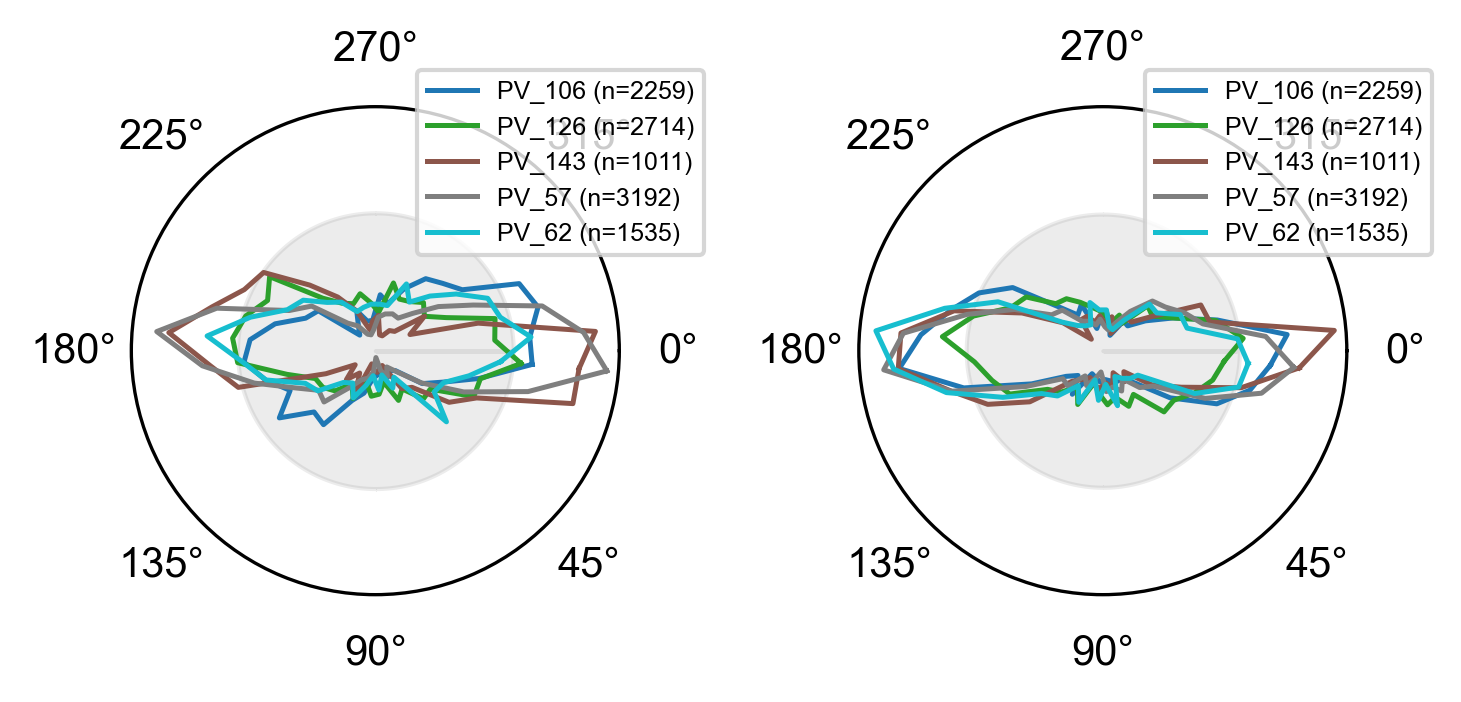

In [58]:
# rotated version:
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees'
create_saccade_polar_histogram_rotated_per_eye(synced_saccade_collection, (5,4),export_path=None)

In [51]:
# verification here:
import numpy as np
import pandas as pd
from pathlib import Path
import datetime as dt

def _clean_angles_deg(series_like):
    a = pd.to_numeric(series_like, errors='coerce').to_numpy(dtype='float64')
    a = a[np.isfinite(a)]
    return np.mod(a, 360.0)

def _hist_deg(angles_deg, num_bins=36):
    hist, edges = np.histogram(angles_deg, bins=num_bins, range=(0.0, 360.0), density=True)
    centers = (edges[:-1] + edges[1:]) / 2.0
    return hist, edges, centers

def _preferred_axis_bin(density):
    n = density.size
    opposite = np.roll(density, n // 2)
    axis_strength = density + opposite
    return int(np.argmax(axis_strength))

def compute_per_eye_axis_rotation(saccade_collection: pd.DataFrame, num_bins=36):
    """
    Returns:
      rotation_dict[(animal, eye)] = {'rotation_deg': float, 'n': int, 'peak_center_deg': float}
      rotation_df: tidy dataframe with the same info
    """
    required = {'animal', 'eye', 'overall_angle_deg'}
    if missing := required.difference(saccade_collection.columns):
        raise ValueError(f"Missing columns: {missing}")

    rotation_dict = {}
    rows = []
    for (animal, eye), sub in saccade_collection.groupby(['animal','eye']):
        a = _clean_angles_deg(sub['overall_angle_deg'])
        if a.size == 0:
            continue
        base_density, _, base_centers = _hist_deg(a, num_bins=num_bins)
        peak_bin = _preferred_axis_bin(base_density)
        peak_center = float(base_centers[peak_bin])
        rotation_deg = -peak_center
        rotation_dict[(animal, eye)] = {
            'rotation_deg': float(rotation_deg),
            'n': int(a.size),
            'peak_center_deg': peak_center
        }
        rows.append({
            'animal': animal, 'eye': eye,
            'rotation_deg': float(rotation_deg),
            'n': int(a.size),
            'peak_center_deg': peak_center
        })
    rotation_df = pd.DataFrame(rows).sort_values(['animal','eye']).reset_index(drop=True)
    return rotation_dict, rotation_df

def export_rotation_catalog(rotation_df: pd.DataFrame, export_dir):
    """
    Saves CSV with rotation summary and returns its path.
    """
    export_dir = Path(export_dir)
    export_dir.mkdir(parents=True, exist_ok=True)
    ts = dt.datetime.now().strftime("%Y_%m_%d_%H_%M")
    out_csv = export_dir / f"{ts}_per_eye_rotation_catalog.csv"
    rotation_df.to_csv(out_csv, index=False)
    print("Saved rotation catalog CSV ->", out_csv)
    return out_csv
import numpy as _np
import pandas as _pd
import matplotlib.pyplot as _plt
import datetime as _dt
import pathlib as _pl
import pickle as _pkl

def create_saccade_polar_histogram_rotated_per_eye_v2(
    saccade_collection: _pd.DataFrame,
    figure_size=(5, 4),
    export_path=None,
    num_bins=36,
    baseline_prob=0.005,
    cmap='tab10',
    rotation_dict=None,   # optional precomputed {(animal,eye): {...}}
    return_rotation=True
):
    """
    Same behavior as your original, plus:
      - Returns rotation_catalog dict.
      - Can accept a precomputed rotation_dict to ensure consistency across plots/reviews.
    """
    # --- helpers copied from your version ---
    def _clean_angles_deg(series_like):
        a = _pd.to_numeric(series_like, errors='coerce').to_numpy(dtype='float64')
        a = a[_np.isfinite(a)]
        return _np.mod(a, 360.0)

    def _hist_deg(angles_deg, num_bins=36):
        hist, edges = _np.histogram(angles_deg, bins=num_bins, range=(0.0, 360.0), density=True)
        centers = (edges[:-1] + edges[1:]) / 2.0
        return hist, edges, centers

    def _preferred_axis_bin(density):
        n = density.size
        opposite = _np.roll(density, n // 2)
        axis_strength = density + opposite
        return int(_np.argmax(axis_strength))

    # --- validate & colors ---
    required_cols = {'animal','eye','overall_angle_deg'}
    if missing := required_cols.difference(set(saccade_collection.columns)):
        raise ValueError(f"saccade_collection missing columns: {missing}")

    animals = _np.array(sorted(saccade_collection['animal'].dropna().unique()))
    if animals.size == 0:
        raise ValueError("No animals found in 'animal' column.")

    try:
        colormap = _plt.get_cmap(cmap)
        colors = [colormap(i / max(1, len(animals)-1)) for i in range(len(animals))]
    except Exception:
        colors = _plt.cm.tab10(_np.linspace(0, 1, max(10, len(animals))))[:len(animals)]

    fig, axs = _plt.subplots(1, 2, figsize=figure_size, dpi=300, subplot_kw=dict(projection='polar'))
    rotation_catalog = {} if rotation_dict is None else {k: dict(v) for k, v in rotation_dict.items()}

    # --- plotting per eye ---
    def _process_eye(ax, eye_label):
        for color, animal in zip(colors, animals):
            df_eye = saccade_collection.query('animal == @animal and eye == @eye_label')
            angles_deg = _clean_angles_deg(df_eye['overall_angle_deg'])
            if angles_deg.size == 0:
                continue

            # Decide rotation
            if (animal, eye_label) in rotation_catalog:
                rotation_deg = float(rotation_catalog[(animal, eye_label)]['rotation_deg'])
            else:
                base_density, _, base_centers = _hist_deg(angles_deg, num_bins=num_bins)
                peak_bin = _preferred_axis_bin(base_density)
                peak_center = base_centers[peak_bin]
                rotation_deg = -float(peak_center)
                rotation_catalog[(animal, eye_label)] = {
                    'rotation_deg': rotation_deg,
                    'n': int(angles_deg.size),
                    'peak_center_deg': float(peak_center)
                }

            # Apply rotation and re-hist
            rotated_angles = _np.mod(angles_deg + rotation_deg, 360.0)
            density, edges, centers = _hist_deg(rotated_angles, num_bins=num_bins)

            theta = _np.deg2rad(_np.r_[centers, centers[0]])
            rho   = _np.r_[density, density[0]]
            ax.plot(theta, rho, lw=1.2, color=color, label=f"{animal} (n={len(angles_deg)})")

        # baseline & cosmetics
        theta_ring = _np.linspace(0, 2 * _np.pi, 512)
        ax.fill_between(theta_ring, 0, baseline_prob, alpha=0.15, color='gray', zorder=0)
        ax.set_yticks([])
        ax.grid(False)
        ax.set_theta_zero_location('E')
        ax.set_theta_direction(-1)
        ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=6)

    _process_eye(axs[0], 'R')
    _process_eye(axs[1], 'L')

    _plt.tight_layout()

    # export (PDF + pkl + csv)
    outdir = None
    if export_path:
        ts = _dt.datetime.now().strftime("%Y_%m_%d_%H_%M")
        outdir = _pl.Path(export_path) / f"{ts}_Rotated_Saccade_Histogram_PerEye"
        outdir.mkdir(parents=True, exist_ok=True)

        pdf = outdir / f"{ts}_saccade_angles_histogram_rotated_pereye.pdf"
        _plt.savefig(pdf)
        with open(outdir / f"{ts}_per_eye_rotation_catalog.pkl", 'wb') as f:
            _pkl.dump(rotation_catalog, f)

        # also a CSV
        rows = [{'animal':a, 'eye':e, **vals} for (a,e), vals in rotation_catalog.items()]
        _pd.DataFrame(rows).sort_values(['animal','eye']).to_csv(outdir / f"{ts}_per_eye_rotation_catalog.csv", index=False)
        print("Exported:", pdf)
        print("Saved rotation catalog:", outdir)

    _plt.show()
    return rotation_catalog if return_rotation else None

# ===============================
# Minimal-rotation catalog + plot
# ===============================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import datetime as dt
import pickle as pkl

# ---- helpers ----
def _clean_angles_deg(series_like):
    a = pd.to_numeric(series_like, errors='coerce').to_numpy(dtype='float64')
    a = a[np.isfinite(a)]
    return np.mod(a, 360.0)

def _hist_deg(angles_deg, num_bins=36):
    hist, edges = np.histogram(angles_deg, bins=num_bins, range=(0.0, 360.0), density=True)
    centers = (edges[:-1] + edges[1:]) / 2.0
    return hist, edges, centers

def _preferred_axis_bin(density):
    # axis preference = bin + opposite bin
    n = density.size
    opposite = np.roll(density, n // 2)
    axis_strength = density + opposite
    return int(np.argmax(axis_strength))

def _wrap180(x):
    # map degrees to (-180, 180]
    return ((x + 180.0) % 360.0) - 180.0

def _minimal_axis_lock_rotation(candidate_deg):
    """
    Choose the smallest-magnitude rotation among {candidate, candidate±180}
    and normalize to [-90, +90) for an axis (0/180) alignment.
    """
    alts = [candidate_deg, candidate_deg + 180.0, candidate_deg - 180.0]
    best = min(alts, key=lambda ang: abs(_wrap180(ang)))
    best = _wrap180(best)
    if abs(best) > 90.0:
        best = best - 180.0 * np.sign(best)
    # now ~[-90, +90)
    return float(best)

# Distinct, colorblind-friendly palette
_OKABE_ITO = ["#0072B2", "#D55E00", "#009E73", "#CC79A7",
              "#F0E442", "#56B4E9", "#E69F00", "#000000"]
def _build_color_map(labels, base=None):
    if base is None:
        base = _OKABE_ITO
    order = list(sorted(labels))
    return {lab: base[i % len(base)] for i, lab in enumerate(order)}

# ---- main API ----
def compute_per_eye_axis_rotation_min(saccade_collection: pd.DataFrame, num_bins=36):
    """
    Compute per-eye rotations to align dominant axis to 0°/180°, using the
    minimal absolute rotation (±180° equivalence).

    Returns
    -------
    rotation_catalog_min : dict
        {(animal, 'L'|'R'): rotation_deg_float_in_[-90,+90)}
    rotation_table : pd.DataFrame
        columns: [animal, eye, n, peak_center_deg, rotation_deg_raw, rotation_deg_min]
    """
    required = {'animal', 'eye', 'overall_angle_deg'}
    missing = required.difference(saccade_collection.columns)
    if missing:
        raise ValueError(f"Missing columns: {missing}")

    rows = []
    catalog_min = {}
    for (animal, eye), sub in saccade_collection.groupby(['animal', 'eye']):
        a = _clean_angles_deg(sub['overall_angle_deg'])
        if a.size == 0:
            continue
        dens, _, centers = _hist_deg(a, num_bins=num_bins)
        peak_bin = _preferred_axis_bin(dens)
        peak_center = float(centers[peak_bin])          # where the dominant axis lies (deg)
        rotation_raw = -peak_center                     # align that bin center to 0°
        rotation_min = _minimal_axis_lock_rotation(rotation_raw)

        rows.append(dict(
            animal=animal, eye=eye, n=int(a.size),
            peak_center_deg=peak_center,
            rotation_deg_raw=float(rotation_raw),
            rotation_deg_min=float(rotation_min)
        ))
        catalog_min[(animal, eye)] = float(rotation_min)

    rotation_table = pd.DataFrame(rows).sort_values(['animal', 'eye']).reset_index(drop=True)
    return catalog_min, rotation_table


def create_saccade_polar_histogram_rotated_per_eye_v3(
    saccade_collection: pd.DataFrame,
    figure_size=(5, 4),
    export_path=None,
    num_bins=36,
    baseline_prob=0.005,
    color_map=None,   # optional {animal: '#hex'}
    font_family="Arial",
    rotation_catalog_min=None,  # optional {(animal,eye): float}; if None, computed here
):
    """
    Plot per-eye rotated polar histograms **using minimal rotations**.

    Returns
    -------
    out : dict
      {
        'rotation_catalog_min': {(animal,'L'|'R'): float_deg},
        'rotation_table': pd.DataFrame,
        'color_map': {animal: '#hex'},
        'exports': {'figure_pdf': str, 'legend_pdf': str, 'rotation_csv': str, 'rotation_pkl': str}  # only if export_path
        'meta': {...}
      }
    """
    # Validate
    need = {'animal', 'eye', 'overall_angle_deg'}
    if need - set(saccade_collection.columns):
        raise ValueError(f"saccade_collection missing columns: {need - set(saccade_collection.columns)}")

    animals = sorted(saccade_collection['animal'].dropna().unique().tolist())
    if not animals:
        raise ValueError("No animals found in 'animal' column.")

    # Colors
    used_colors = color_map or _build_color_map(animals)

    # Matplotlib font
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = [font_family]

    # Rotations
    if rotation_catalog_min is None:
        rotation_catalog_min, rotation_table = compute_per_eye_axis_rotation_min(saccade_collection, num_bins=num_bins)
    else:
        # Build a rotation_table for reference from the provided catalog
        rows = []
        for (animal, eye) in sorted(rotation_catalog_min.keys()):
            sub = saccade_collection[(saccade_collection['animal'] == animal) &
                                     (saccade_collection['eye'] == eye)]
            n = int(sub['overall_angle_deg'].notna().sum())
            rows.append(dict(
                animal=animal, eye=eye, n=n,
                peak_center_deg=np.nan, rotation_deg_raw=np.nan,
                rotation_deg_min=float(rotation_catalog_min[(animal, eye)])
            ))
        rotation_table = pd.DataFrame(rows).sort_values(['animal', 'eye']).reset_index(drop=True)

    # Figure
    fig, axs = plt.subplots(1, 2, figsize=figure_size, dpi=300, subplot_kw=dict(projection='polar'))

    def _process_eye(ax, eye_label):
        for animal in animals:
            df_eye = saccade_collection.query('animal == @animal and eye == @eye_label')
            angles_deg = _clean_angles_deg(df_eye['overall_angle_deg'])
            if angles_deg.size == 0:
                continue

            rot = rotation_catalog_min.get((animal, eye_label), 0.0)
            rotated_angles = np.mod(angles_deg + rot, 360.0)

            density, _, centers = _hist_deg(rotated_angles, num_bins=num_bins)
            theta = np.deg2rad(np.r_[centers, centers[0]])
            rho   = np.r_[density, density[0]]

            ax.plot(theta, rho, lw=1.5, color=used_colors[animal], label=f"{animal} (n={len(angles_deg)})")

        # baseline band & cosmetics
        theta_ring = np.linspace(0, 2*np.pi, 512)
        ax.fill_between(theta_ring, 0, baseline_prob, alpha=0.15, color='gray', zorder=0)
        ax.set_yticks([])
        ax.grid(False)
        ax.set_theta_zero_location('E')
        ax.set_theta_direction(1)

    # R on left, L on right
    _process_eye(axs[0], 'R')
    _process_eye(axs[1], 'L')
    axs[0].set_title("Right eye (rotated, minimal)", fontsize=9, pad=8)
    axs[1].set_title("Left eye (rotated, minimal)",  fontsize=9, pad=8)
    plt.tight_layout()

    # Exports
    exports = {}
    if export_path:
        ts = dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        outdir = Path(export_path) / f"{ts}_Saccade_Hist_PerEye"
        outdir.mkdir(parents=True, exist_ok=True)

        # Figure
        pdf_path = outdir / "saccade_angles_histogram_per_eye.pdf"
        fig.savefig(pdf_path, bbox_inches='tight', dpi=300)
        exports['figure_pdf'] = str(pdf_path)

        # Legend PDF
        from matplotlib.lines import Line2D
        handles = [Line2D([0], [0], color=used_colors[a], lw=1.5, label=str(a)) for a in animals]
        fig_leg = plt.figure(figsize=(2.2, 0.3*max(1,len(handles)) + 0.4), dpi=300)
        fig_leg.legend(handles, [h.get_label() for h in handles],
                       loc='center', frameon=False, ncol=1, prop={'size': 8})
        legend_pdf_path = outdir / "legend_saccade_angles_histogram_per_eye.pdf"
        fig_leg.savefig(legend_pdf_path, bbox_inches='tight', dpi=300)
        plt.close(fig_leg)
        exports['legend_pdf'] = str(legend_pdf_path)

        # Rotation table: CSV + PKL (PKL contains just the minimal catalog)
        csv_path = outdir / "per_eye_rotation_catalog.csv"
        rotation_table.to_csv(csv_path, index=False)
        exports['rotation_csv'] = str(csv_path)

        pkl_path = outdir / "per_eye_rotation_catalog_min.pkl"
        with open(pkl_path, 'wb') as f:
            pkl.dump(rotation_catalog_min, f, protocol=pkl.HIGHEST_PROTOCOL)
        exports['rotation_pkl'] = str(pkl_path)

        print("Exported figure to:", pdf_path)
        print("Exported legend to:", legend_pdf_path)
        print("Saved rotation catalog CSV to:", csv_path)
        print("Saved minimal rotation PKL to:", pkl_path)

    plt.show()

    out = {
        'rotation_catalog_min': rotation_catalog_min,       # {(animal, 'L'|'R'): float}
        'rotation_table': rotation_table,                   # DataFrame with details
        'color_map': used_colors,                           # {animal: '#hex'}
        'exports': exports,                                 # paths (if any)
        'meta': {
            'num_bins': num_bins,
            'baseline_prob': baseline_prob,
            'animals': animals,
            'figure_size': figure_size,
            'font_family': font_family,
            'created_at': dt.datetime.now().isoformat(timespec='seconds')
        }
    }
    return out


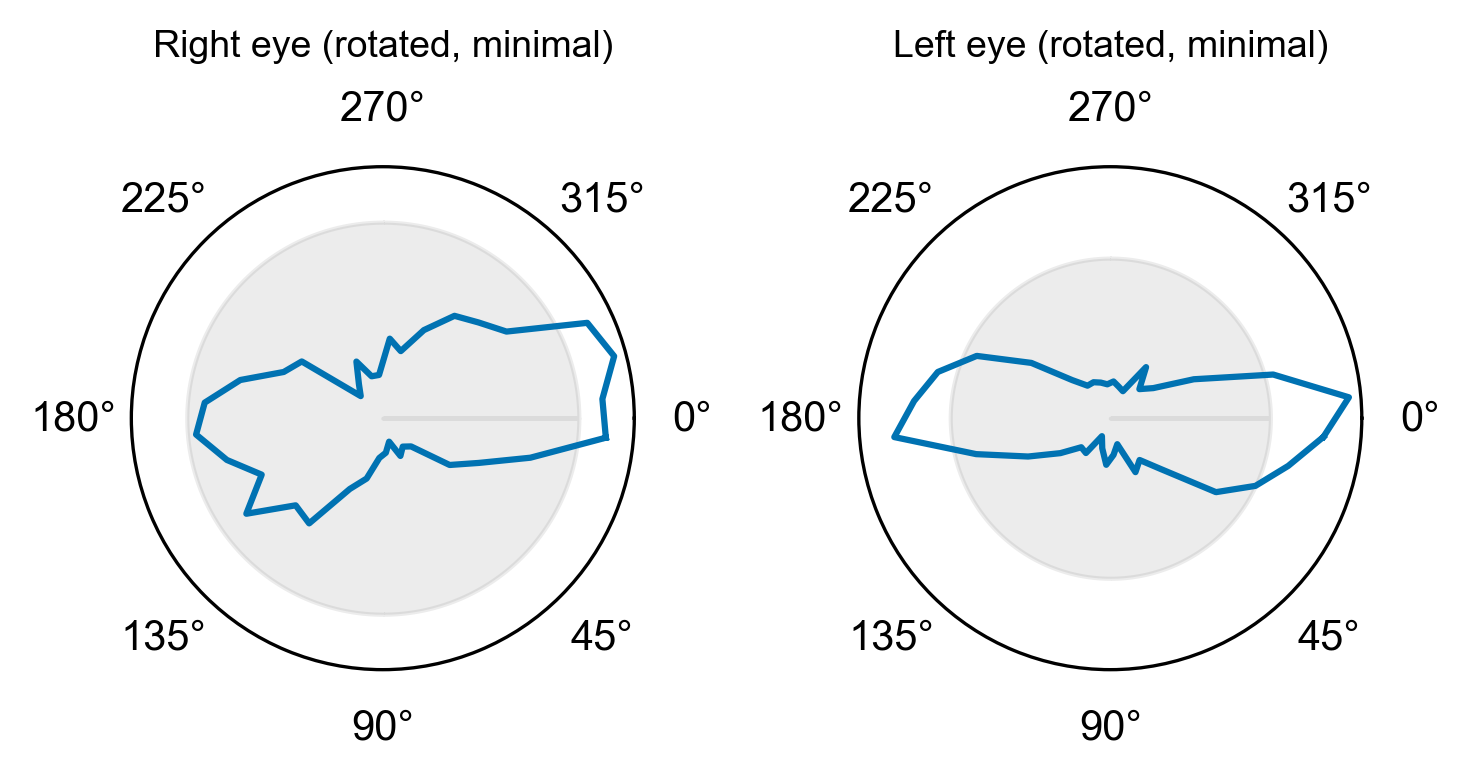

In [88]:
# 1) Build the minimal-rotation catalog + figure (and get 'out')
out = create_saccade_polar_histogram_rotated_per_eye_v3(
    synced_saccade_collection.query('animal=="PV_106"'),                            # your per-saccade table
    figure_size=(5,4),
    export_path=None,
    num_bins=36,
)

In [17]:
# 3D-based angle verification paradigm:
import json
import numpy as np
import pandas as pd
from pathlib import Path

# ---------- angle helpers ----------
def _wrap180(x_deg: float) -> float:
    """Map degrees to (-180, 180]."""
    return ((x_deg + 180.0) % 360.0) - 180.0

def _minimal_axis_lock_rotation(candidate_deg: float) -> float:
    """
    For axis alignment (0/180 ≡ same axis), choose smallest-magnitude rotation
    equivalent among {θ, θ±180}, then fold to [-90, +90).
    """
    alts = [candidate_deg, candidate_deg + 180.0, candidate_deg - 180.0]
    best = min(alts, key=lambda ang: abs(_wrap180(ang)))
    best = _wrap180(best)
    if abs(best) > 90.0:
        best = best - 180.0 * np.sign(best)
    return float(best)

# ---------- rotation math ----------
def _quat_from_R(R: np.ndarray):
    """
    Convert 3x3 rotation matrix to (w, x, y, z), robust to small numeric noise.
    """
    R = np.asarray(R, dtype=float)
    t = np.trace(R)
    if t > 0:
        s = np.sqrt(t + 1.0) * 2.0
        w = 0.25 * s
        x = (R[2,1] - R[1,2]) / s
        y = (R[0,2] - R[2,0]) / s
        z = (R[1,0] - R[0,1]) / s
    else:
        i = np.argmax([R[0,0], R[1,1], R[2,2]])
        if i == 0:
            s = np.sqrt(1.0 + R[0,0] - R[1,1] - R[2,2]) * 2.0
            w = (R[2,1] - R[1,2]) / s
            x = 0.25 * s
            y = (R[0,1] + R[1,0]) / s
            z = (R[0,2] + R[2,0]) / s
        elif i == 1:
            s = np.sqrt(1.0 - R[0,0] + R[1,1] - R[2,2]) * 2.0
            w = (R[0,2] - R[2,0]) / s
            x = (R[0,1] + R[1,0]) / s
            y = 0.25 * s
            z = (R[1,2] + R[2,1]) / s
        else:
            s = np.sqrt(1.0 - R[0,0] - R[1,1] + R[2,2]) * 2.0
            w = (R[1,0] - R[0,1]) / s
            x = (R[0,2] + R[2,0]) / s
            y = (R[1,2] + R[2,1]) / s
            z = 0.25 * s
    q = np.array([w, x, y, z], dtype=float)
    return q / np.linalg.norm(q)

def _twist_angle_about_axis_deg(R: np.ndarray, axis_unit: np.ndarray) -> float:
    """
    Swing-twist decomposition: return the signed twist angle (deg) about axis_unit
    for rotation R (3x3). Sign follows right-hand rule about axis_unit.
    """
    q = _quat_from_R(R)                    # (w, x, y, z)
    w, v = q[0], q[1:]
    n = axis_unit / np.linalg.norm(axis_unit)
    # Project quaternion vector part onto axis -> twist component
    v_par = n * np.dot(v, n)
    # Twist quaternion (unnormalized) = [w, v_par]
    q_twist = np.concatenate([[w], v_par])
    norm = np.linalg.norm(q_twist)
    if norm < 1e-12:
        return 0.0
    q_twist /= norm
    w_t, v_t = q_twist[0], q_twist[1:]
    # Signed angle from quaternion
    angle_rad = 2.0 * np.arctan2(np.linalg.norm(v_t), w_t)
    # Determine sign using direction of v_par along axis
    sign = np.sign(np.dot(v, n)) if np.linalg.norm(v_par) > 1e-12 else 1.0
    return np.degrees(angle_rad) * sign

# ---------- I/O & comparison ----------
def _load_rot_and_nref(rot_json_path: Path, normals_json_path: Path):
    with open(rot_json_path, 'r') as f:
        R = np.array(json.load(f), dtype=float)
    with open(normals_json_path, 'r') as f:
        normals = json.load(f)
    n_ref = np.array(normals['n_ref'], dtype=float)
    return R, n_ref

def extract_roll_deg_from_blender(rot_json_path, normals_json_path) -> float:
    """
    Read Blender v14 exports and return roll (twist about n_ref) in degrees.
    """
    R, n_ref = _load_rot_and_nref(Path(rot_json_path), Path(normals_json_path))
    # safety: ensure R is 3x3
    R = np.asarray(R, dtype=float).reshape(3,3)
    return float(_twist_angle_about_axis_deg(R, n_ref))

def compare_eye_axis_rotation_to_catalog(
    animal: str,
    out_dict: dict,
    left_paths: dict,
    right_paths: dict,
    eye_labels=('L','R')
) -> pd.DataFrame:
    """
    Compare Blender roll (about n_ref) to your per-eye minimal axis rotations.

    Parameters
    ----------
    animal : str
        Animal ID string that matches keys used in out['rotation_catalog_min'].
    out_dict : dict
        Output from create_saccade_polar_histogram_rotated_per_eye_v3(...).
        Must contain: out_dict['rotation_catalog_min'] : {(animal, 'L'|'R'): float_deg}
    left_paths : {'rot': path, 'normals': path}
        Paths to left-eye rot_matrix_v14.json and normals_v14.json
    right_paths : {'rot': path, 'normals': path}
        Paths to right-eye rot_matrix_v14.json and normals_v14.json
    eye_labels : tuple
        Order to report; default ('L','R').

    Returns
    -------
    df : pd.DataFrame
        Columns:
          ['animal','eye',
           'blender_roll_deg_raw','blender_roll_deg_axis_min',
           'catalog_axis_min_deg','delta_deg','abs_delta_deg',
           'rot_json','normals_json']
    """
    cat = out_dict.get('rotation_catalog_min', {})
    rows = []
    for eye, paths in zip(eye_labels, [left_paths, right_paths]):
        rot_p = Path(paths['rot'])
        nrm_p = Path(paths['normals'])
        roll_raw = extract_roll_deg_from_blender(rot_p, nrm_p)
        # Normalize Blender roll to axis-equivalent minimal rotation
        roll_axis_min = _minimal_axis_lock_rotation(roll_raw)
        # Catalog (already minimal axis rotations per your v3 function)
        cat_key = (animal, eye)
        if cat_key not in cat:
            raise KeyError(f"No catalog rotation for {cat_key}. "
                           f"Available keys: {list(cat.keys())[:6]}... (total {len(cat)})")
        catalog_min = float(cat[cat_key])

        # Signed delta (catalog - blender), folded to (-180,180]
        delta = _wrap180(catalog_min - roll_axis_min)

        rows.append(dict(
            animal=animal,
            eye=eye,
            blender_roll_deg_raw=roll_raw,
            blender_roll_deg_axis_min=roll_axis_min,
            catalog_axis_min_deg=catalog_min,
            delta_deg=delta,
            abs_delta_deg=abs(delta),
            rot_json=str(rot_p),
            normals_json=str(nrm_p),
        ))
    return pd.DataFrame(rows)


animal = 'PV_62'
left_paths  = {
    'rot': fr'D:\MarkS3\Documents\BlenderFiles\Camera_angle_registration\{animal}_registration\l_rot_matrix_v14.json',
    'normals': fr'D:\MarkS3\Documents\BlenderFiles\Camera_angle_registration\{animal}_registration\l_normals_v14.json',
}
right_paths = {
    'rot': fr'D:\MarkS3\Documents\BlenderFiles\Camera_angle_registration\{animal}_registration\r_rot_matrix_v14.json',
    'normals': fr'D:\MarkS3\Documents\BlenderFiles\Camera_angle_registration\{animal}_registration\r_normals_v14.json',
}


In [36]:
cmp_df = compare_eye_axis_rotation_to_catalog(animal, out, left_paths, right_paths)
display(cmp_df)

,animal,eye,blender_roll_deg_raw,blender_roll_deg_axis_min,catalog_axis_min_deg,delta_deg,abs_delta_deg,rot_json,normals_json
0,PV_62,L,-7.333125,-7.333125,-15.0,-7.666875,7.666875,D:\MarkS3\Documents\BlenderFiles\Camera_angle_...,D:\MarkS3\Documents\BlenderFiles\Camera_angle_...
1,PV_62,R,-6.556844,-6.556844,25.0,31.556844,31.556844,D:\MarkS3\Documents\BlenderFiles\Camera_angle_...,D:\MarkS3\Documents\BlenderFiles\Camera_angle_...


In [24]:
import re, json
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, Tuple, List, Optional

# ---------------- math helpers ----------------
def _wrap180(x_deg: float) -> float:
    return ((x_deg + 180.0) % 360.0) - 180.0

def _minimal_axis_lock_rotation(candidate_deg: float) -> float:
    """
    Axis equivalence: 0° ≡ 180°. Choose smallest-magnitude representative.
    Fold into [-90, +90).
    """
    alts = [candidate_deg, candidate_deg + 180.0, candidate_deg - 180.0]
    best = min(alts, key=lambda ang: abs(_wrap180(ang)))
    best = _wrap180(best)
    if abs(best) > 90.0:
        best = best - 180.0 * np.sign(best)
    return float(best)

def _quat_from_R(R: np.ndarray) -> np.ndarray:
    """3x3 rotation matrix -> unit quaternion (w,x,y,z), robust."""
    R = np.asarray(R, dtype=float)
    t = np.trace(R)
    if t > 0:
        s = np.sqrt(t + 1.0) * 2.0
        w = 0.25 * s
        x = (R[2,1] - R[1,2]) / s
        y = (R[0,2] - R[2,0]) / s
        z = (R[1,0] - R[0,1]) / s
    else:
        i = int(np.argmax([R[0,0], R[1,1], R[2,2]]))
        if i == 0:
            s = np.sqrt(1.0 + R[0,0] - R[1,1] - R[2,2]) * 2.0
            w = (R[2,1] - R[1,2]) / s; x = 0.25 * s
            y = (R[0,1] + R[1,0]) / s; z = (R[0,2] + R[2,0]) / s
        elif i == 1:
            s = np.sqrt(1.0 - R[0,0] + R[1,1] - R[2,2]) * 2.0
            w = (R[0,2] - R[2,0]) / s; x = (R[0,1] + R[1,0]) / s
            y = 0.25 * s;             z = (R[1,2] + R[2,1]) / s
        else:
            s = np.sqrt(1.0 - R[0,0] - R[1,1] + R[2,2]) * 2.0
            w = (R[1,0] - R[0,1]) / s; x = (R[0,2] + R[2,0]) / s
            y = (R[1,2] + R[2,1]) / s; z = 0.25 * s
    q = np.array([w, x, y, z], dtype=float)
    return q / np.linalg.norm(q)

def _twist_about_axis_deg(R: np.ndarray, axis_unit: np.ndarray) -> float:
    """
    Swing–twist decomposition: signed twist angle (deg) about axis_unit (right-hand rule).
    """
    q = _quat_from_R(R)
    w, v = q[0], q[1:]
    n = axis_unit / (np.linalg.norm(axis_unit) or 1.0)
    v_par = n * np.dot(v, n)
    q_tw = np.concatenate([[w], v_par])
    nrm = np.linalg.norm(q_tw)
    if nrm < 1e-12:
        return 0.0
    q_tw /= nrm
    ang = 2.0 * np.arctan2(np.linalg.norm(q_tw[1:]), q_tw[0])
    sign = np.sign(np.dot(v, n)) if np.linalg.norm(v_par) > 1e-12 else 1.0
    return float(np.degrees(ang) * sign)

# ---------------- I/O helpers for your layout ----------------
def _animal_from_folder(folder_name: str) -> Optional[str]:
    """
    Extract 'PV_###' from '<PV_###>_registration' folder names.
    """
    m = re.fullmatch(r'(PV_\d{2,3})_registration', folder_name)
    return m.group(1) if m else None

def discover_animals_under_root(root: Path) -> List[str]:
    """
    Scan root for folders named 'PV_###_registration' and return ['PV_###', ...].
    """
    animals = []
    for p in root.iterdir():
        if p.is_dir():
            a = _animal_from_folder(p.name)
            if a:
                animals.append(a)
    animals.sort()
    return animals

def _paths_for_animal(root: Path, animal: str) -> Dict[str, Dict[str, Path]]:
    """
    Build the exact file paths per your convention.

    Returns:
      {
        'L': {'rot': Path, 'normals': Path},
        'R': {'rot': Path, 'normals': Path}
      }
    """
    base = root / f"{animal}_registration"
    paths = {
        'L': {
            'rot':     base / "l_rot_matrix_v14.json",
            'normals': base / "l_normals_v14.json",
        },
        'R': {
            'rot':     base / "r_rot_matrix_v14.json",
            'normals': base / "r_normals_v14.json",
        }
    }
    return paths

def _load_rot_and_nref(rot_path: Path, normals_path: Path):
    R = np.array(json.loads(rot_path.read_text()), dtype=float).reshape(3,3)
    d = json.loads(normals_path.read_text())
    n_ref = np.array(d['n_ref'], dtype=float)
    n_ref = n_ref / (np.linalg.norm(n_ref) or 1.0)
    return R, n_ref

# ---------------- main catalog builder for your layout ----------------
def build_blender_roll_catalog_from_registration(
    root: Path,
    animals: Optional[List[str]] = None,
    verbose: bool = True,
) -> Dict[Tuple[str, str], float]:
    """
    Build {(animal,'L'|'R'): roll_deg_axis_min} using the fixed path layout:
      <root>/<animal>_registration/l_rot_matrix_v14.json, l_normals_v14.json, ...
    If animals is None, animals are discovered from folder names under root.
    """
    if animals is None:
        animals = discover_animals_under_root(root)
        if verbose:
            print(f"Discovered animals: {animals}")

    catalog: Dict[Tuple[str,str], float] = {}
    for animal in animals:
        files = _paths_for_animal(root, animal)
        for eye in ('L', 'R'):
            rot_p, nrm_p = files[eye]['rot'], files[eye]['normals']
            if not rot_p.exists() or not nrm_p.exists():
                if verbose:
                    print(f"[MISS] {animal} {eye}: missing files "
                          f"({rot_p.name if rot_p.exists() else 'NO rot'}, "
                          f"{nrm_p.name if nrm_p.exists() else 'NO normals'})")
                continue
            try:
                R, n_ref = _load_rot_and_nref(rot_p, nrm_p)
                roll_raw = _twist_about_axis_deg(R, n_ref)             # signed twist about n_ref
                roll_axis_min = _minimal_axis_lock_rotation(roll_raw)  # fold to axis measure [-90,+90)
                catalog[(animal, eye)] = float(roll_axis_min)
                if verbose:
                    print(f"[OK] {animal} {eye}: raw={roll_raw:+.2f}°, axis_min={roll_axis_min:+.2f}°")
            except Exception as e:
                if verbose:
                    print(f"[ERR] {animal} {eye}: {e}")
    return catalog

# ---------------- convenience: plotting with Blender alignment ----------------
def plot_histograms_using_blender_alignment(
    saccade_collection: pd.DataFrame,
    rotation_catalog_min: Dict[Tuple[str,str], float],
    create_plot_func,  # your create_saccade_polar_histogram_rotated_per_eye_v3
    **plot_kwargs
):
    return create_plot_func(
        saccade_collection=saccade_collection,
        rotation_catalog_min=rotation_catalog_min,
        **plot_kwargs
    )


In [23]:
# small helper to flip one eye of one animal if required:
from copy import deepcopy

def _norm_animal_eye(animal: str, eye: str):
    # Normalize inputs: 'pv_106' -> 'PV_106', 'l' -> 'L'
    animal_norm = animal.strip().upper()
    if not animal_norm.startswith("PV_"):
        # allow '106' -> 'PV_106'
        if animal_norm.isdigit():
            animal_norm = f"PV_{animal_norm}"
    eye_norm = eye.strip().upper()
    if eye_norm not in ("L", "R"):
        raise ValueError(f"eye must be 'L' or 'R', got: {eye}")
    return animal_norm, eye_norm

def flip_blender_rotation(catalog_blender: dict, animal: str, eye: str, in_place: bool = False):
    """
    Flip the rotation sign for a single (animal, eye).

    Parameters
    ----------
    catalog_blender : dict
        {(animal, 'L'|'R'): rotation_deg} where rotation_deg is axis-equivalent in [-90, +90).
    animal : str
        e.g., 'pv_106', 'PV_106', or just '106' (will normalize to 'PV_106').
    eye : str
        'l' or 'r' (case-insensitive).
    in_place : bool
        If True, mutate catalog_blender; else return a new dict.

    Returns
    -------
    updated : dict
        The updated catalog (same object if in_place=True).
    """
    a, e = _norm_animal_eye(animal, eye)
    key = (a, e)
    if key not in catalog_blender:
        # Helpful message with nearby keys
        animals_present = sorted(set(k[0] for k in catalog_blender.keys()))
        eyes_present = sorted(set(k[1] for k in catalog_blender.keys()))
        raise KeyError(f"Key {(a, e)} not found. Animals in catalog: {animals_present}; eyes present: {eyes_present}")

    target = catalog_blender if in_place else deepcopy(catalog_blender)
    old = float(target[key])
    target[key] = -old
    print(f"[flip] {a} {e}: {old:+.2f}° -> {target[key]:+.2f}°")
    return target


Discovered animals: ['PV_106', 'PV_126', 'PV_143', 'PV_57', 'PV_62']
[OK] PV_106 L: raw=+25.10°, axis_min=+25.10°
[OK] PV_106 R: raw=-17.29°, axis_min=-17.29°
[OK] PV_126 L: raw=-4.46°, axis_min=-4.46°
[OK] PV_126 R: raw=+6.42°, axis_min=+6.42°
[OK] PV_143 L: raw=+4.04°, axis_min=+4.04°
[OK] PV_143 R: raw=-1.94°, axis_min=-1.94°
[OK] PV_57 L: raw=+6.97°, axis_min=+6.97°
[OK] PV_57 R: raw=-7.68°, axis_min=-7.68°
[OK] PV_62 L: raw=-7.33°, axis_min=-7.33°
[OK] PV_62 R: raw=-6.56°, axis_min=-6.56°
Exported figure to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees\2025_09_03_16_33_37_Saccade_Hist_PerEye\saccade_angles_histogram_per_eye.pdf
Exported legend to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees\2025_09_03_16_33_37_Saccade_Hist_PerEye\legend_saccade_angles_histogram_per_eye.pdf
Saved rotation catalog CSV to: Z:\Nimrod\Paper_F

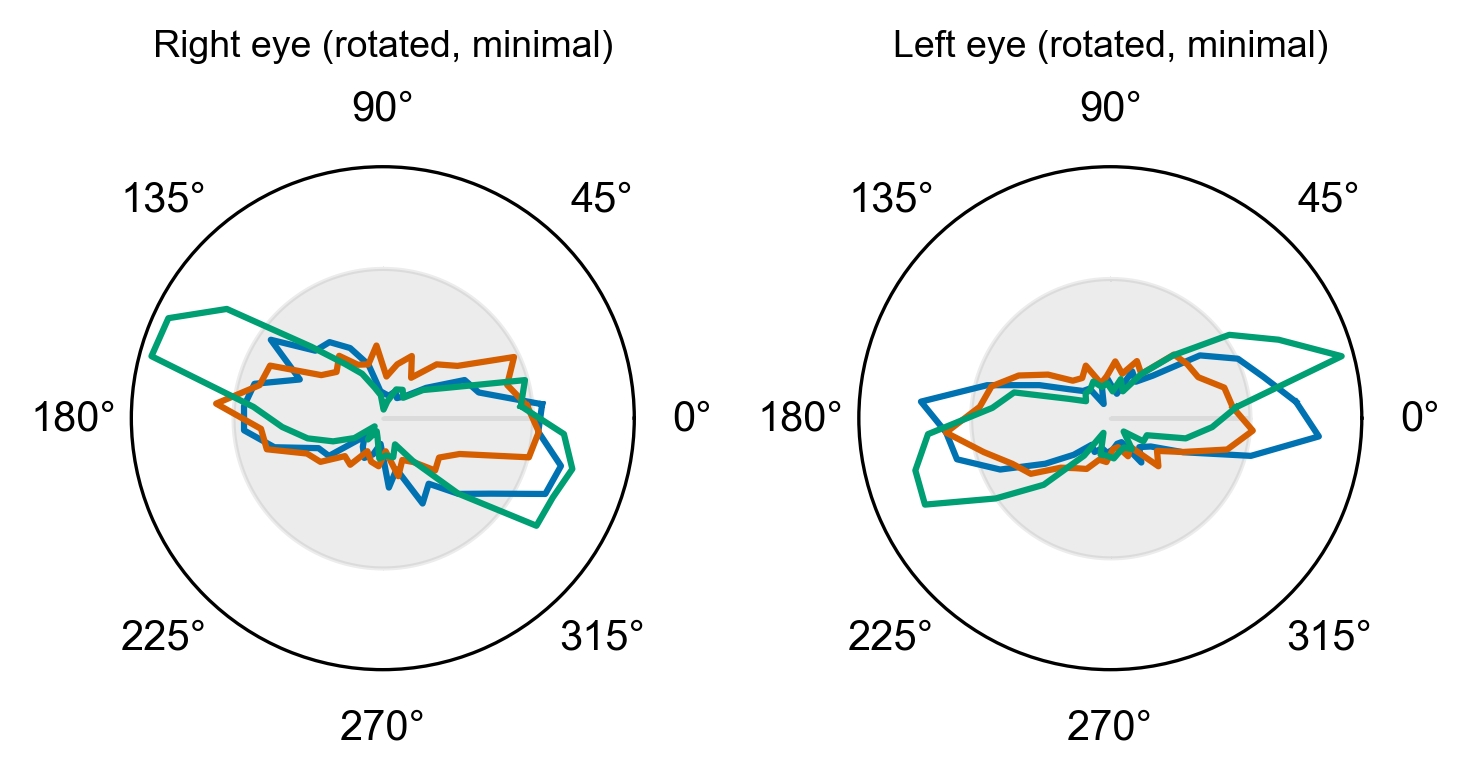

In [62]:
#This is before 143 correction:
from pathlib import Path

root = Path(r"D:\MarkS3\Documents\BlenderFiles\Camera_angle_registration")

# Option A: auto-discover animals from folder names like 'PV_62_registration'
catalog_blender = build_blender_roll_catalog_from_registration(root, animals=None, verbose=True)
#catalog_blender = flip_blender_rotation(catalog_blender, 'pv_106', 'l', in_place=True)
# catalog_blender = flip_blender_rotation(catalog_blender, 'pv_106', 'r', in_place=True)
# Option B: provide an explicit list
# animals = ['PV_106','PV_143','PV_62','PV_126','PV_57']
# catalog_blender = build_blender_roll_catalog_from_registration(root, animals=animals, verbose=True)

# Now plot using Blender-only alignment (no auto-rotation from data):
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees'
out_blender = plot_histograms_using_blender_alignment(
    saccade_collection=synced_saccade_collection.query('animal!="PV_57" and animal != "PV_62"'),
    rotation_catalog_min=catalog_blender,
    create_plot_func=create_saccade_polar_histogram_rotated_per_eye_v3,
    figure_size=(5,4),
    export_path= export_path,       # or a folder to export PDFs/CSVs/PKLs
    num_bins=36,
    baseline_prob=0.005
)


Discovered animals: ['PV_106', 'PV_126', 'PV_143', 'PV_57', 'PV_62']
[OK] PV_106 L: raw=+25.10°, axis_min=+25.10°
[OK] PV_106 R: raw=-17.29°, axis_min=-17.29°
[OK] PV_126 L: raw=-4.46°, axis_min=-4.46°
[OK] PV_126 R: raw=+6.42°, axis_min=+6.42°
[OK] PV_143 L: raw=+4.04°, axis_min=+4.04°
[OK] PV_143 R: raw=-1.94°, axis_min=-1.94°
[OK] PV_57 L: raw=+6.97°, axis_min=+6.97°
[OK] PV_57 R: raw=-7.68°, axis_min=-7.68°
[OK] PV_62 L: raw=-7.33°, axis_min=-7.33°
[OK] PV_62 R: raw=-6.56°, axis_min=-6.56°


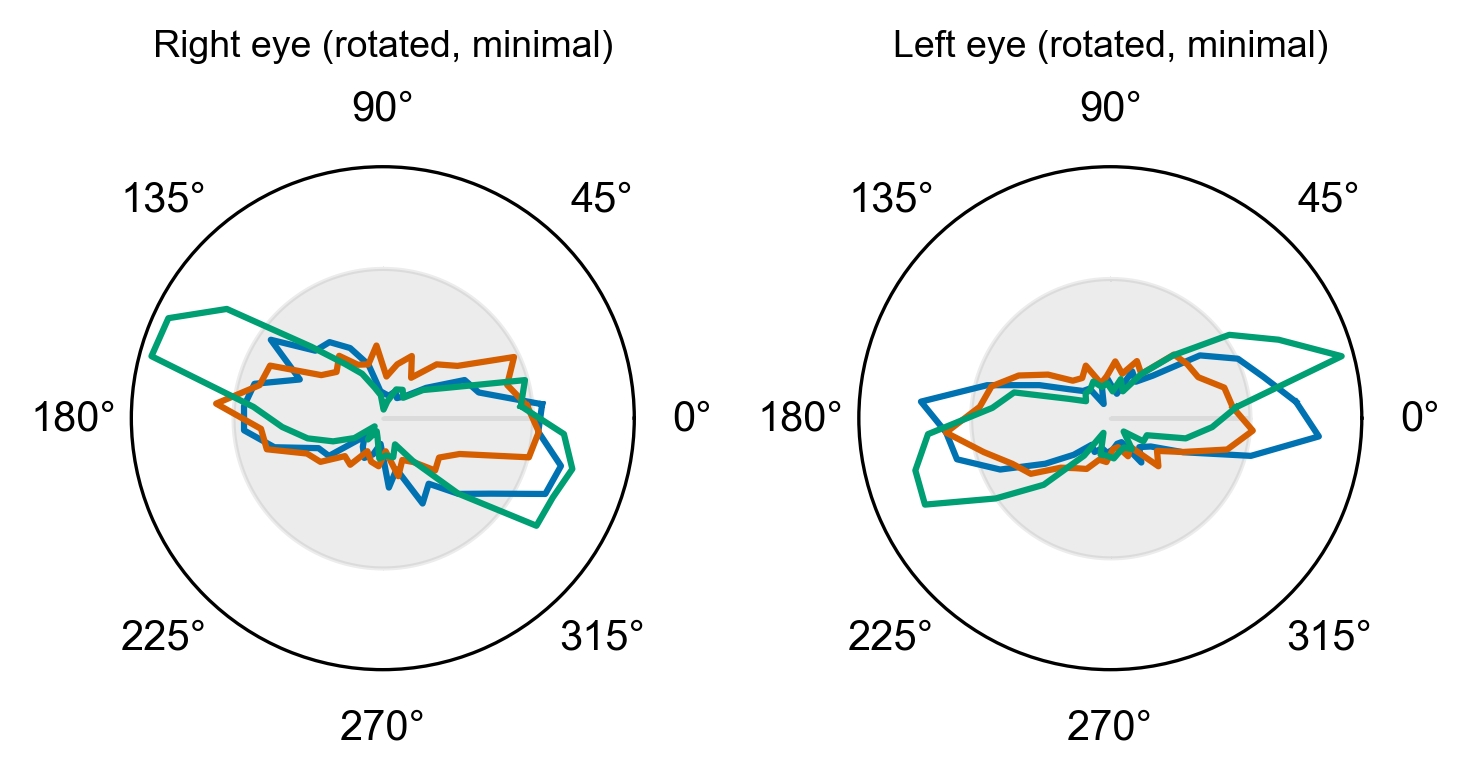

In [57]:
#This is after 143 correction
from pathlib import Path

root = Path(r"D:\MarkS3\Documents\BlenderFiles\Camera_angle_registration")

# Option A: auto-discover animals from folder names like 'PV_62_registration'
catalog_blender = build_blender_roll_catalog_from_registration(root, animals=None, verbose=True)
#catalog_blender = flip_blender_rotation(catalog_blender, 'pv_106', 'l', in_place=True)
# catalog_blender = flip_blender_rotation(catalog_blender, 'pv_106', 'r', in_place=True)
# Option B: provide an explicit list
# animals = ['PV_106','PV_143','PV_62','PV_126','PV_57']
# catalog_blender = build_blender_roll_catalog_from_registration(root, animals=animals, verbose=True)

# Now plot using Blender-only alignment (no auto-rotation from data):
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees'
out_blender = plot_histograms_using_blender_alignment(
    saccade_collection=synced_saccade_collection.query('animal!="PV_57" and animal != "PV_62" '),
    rotation_catalog_min=catalog_blender,
    create_plot_func=create_saccade_polar_histogram_rotated_per_eye_v3,
    figure_size=(5,4),
    export_path= None,       # or a folder to export PDFs/CSVs/PKLs
    num_bins=36,
    baseline_prob=0.005
)

Collect L: 100%|██████████| 608/608 [00:00<00:00, 1222.08it/s]


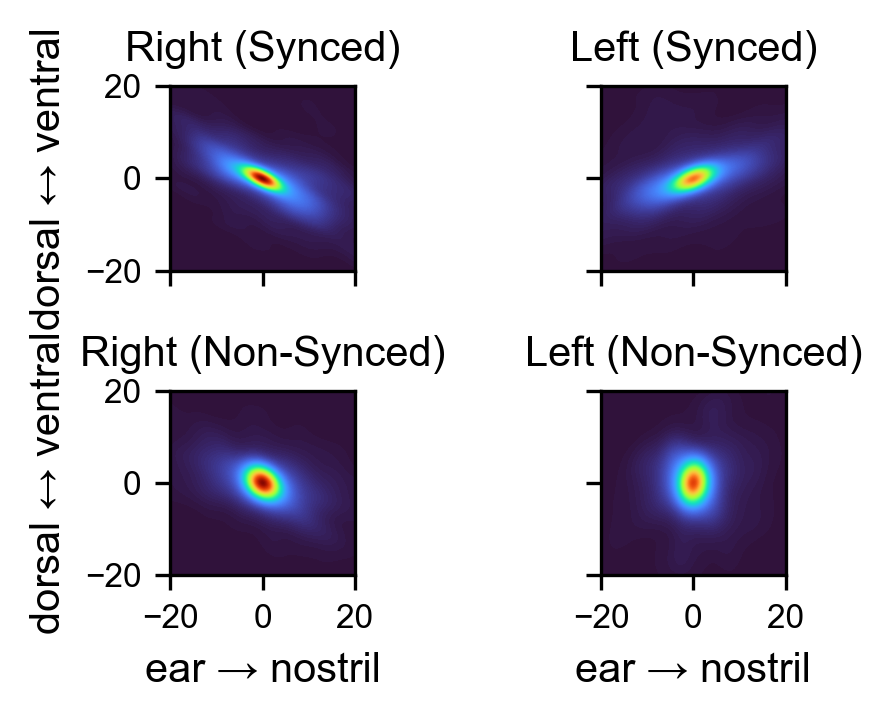

In [28]:
import re, json
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, Tuple, List, Optional

# ---------------- math helpers ----------------
def _wrap180(x_deg: float) -> float:
    return ((x_deg + 180.0) % 360.0) - 180.0

def _minimal_axis_lock_rotation(candidate_deg: float) -> float:
    """
    Axis equivalence: 0° ≡ 180°. Choose smallest-magnitude representative.
    Fold into [-90, +90).
    """
    alts = [candidate_deg, candidate_deg + 180.0, candidate_deg - 180.0]
    best = min(alts, key=lambda ang: abs(_wrap180(ang)))
    best = _wrap180(best)
    if abs(best) > 90.0:
        best = best - 180.0 * np.sign(best)
    return float(best)

def _quat_from_R(R: np.ndarray) -> np.ndarray:
    """3x3 rotation matrix -> unit quaternion (w,x,y,z), robust."""
    R = np.asarray(R, dtype=float)
    t = np.trace(R)
    if t > 0:
        s = np.sqrt(t + 1.0) * 2.0
        w = 0.25 * s
        x = (R[2,1] - R[1,2]) / s
        y = (R[0,2] - R[2,0]) / s
        z = (R[1,0] - R[0,1]) / s
    else:
        i = int(np.argmax([R[0,0], R[1,1], R[2,2]]))
        if i == 0:
            s = np.sqrt(1.0 + R[0,0] - R[1,1] - R[2,2]) * 2.0
            w = (R[2,1] - R[1,2]) / s; x = 0.25 * s
            y = (R[0,1] + R[1,0]) / s; z = (R[0,2] + R[2,0]) / s
        elif i == 1:
            s = np.sqrt(1.0 - R[0,0] + R[1,1] - R[2,2]) * 2.0
            w = (R[0,2] - R[2,0]) / s; x = (R[0,1] + R[1,0]) / s
            y = 0.25 * s;             z = (R[1,2] + R[2,1]) / s
        else:
            s = np.sqrt(1.0 - R[0,0] - R[1,1] + R[2,2]) * 2.0
            w = (R[1,0] - R[0,1]) / s; x = (R[0,2] + R[2,0]) / s
            y = (R[1,2] + R[2,1]) / s; z = 0.25 * s
    q = np.array([w, x, y, z], dtype=float)
    return q / np.linalg.norm(q)

def _twist_about_axis_deg(R: np.ndarray, axis_unit: np.ndarray) -> float:
    """
    Swing–twist decomposition: signed twist angle (deg) about axis_unit (right-hand rule).
    """
    q = _quat_from_R(R)
    w, v = q[0], q[1:]
    n = axis_unit / (np.linalg.norm(axis_unit) or 1.0)
    v_par = n * np.dot(v, n)
    q_tw = np.concatenate([[w], v_par])
    nrm = np.linalg.norm(q_tw)
    if nrm < 1e-12:
        return 0.0
    q_tw /= nrm
    ang = 2.0 * np.arctan2(np.linalg.norm(q_tw[1:]), q_tw[0])
    sign = np.sign(np.dot(v, n)) if np.linalg.norm(v_par) > 1e-12 else 1.0
    return float(np.degrees(ang) * sign)

# ---------------- I/O helpers for your layout ----------------
def _animal_from_folder(folder_name: str) -> Optional[str]:
    """
    Extract 'PV_###' from '<PV_###>_registration' folder names.
    """
    m = re.fullmatch(r'(PV_\d{2,3})_registration', folder_name)
    return m.group(1) if m else None

def discover_animals_under_root(root: Path) -> List[str]:
    """
    Scan root for folders named 'PV_###_registration' and return ['PV_###', ...].
    """
    animals = []
    for p in root.iterdir():
        if p.is_dir():
            a = _animal_from_folder(p.name)
            if a:
                animals.append(a)
    animals.sort()
    return animals

def _paths_for_animal(root: Path, animal: str) -> Dict[str, Dict[str, Path]]:
    """
    Build the exact file paths per your convention.

    Returns:
      {
        'L': {'rot': Path, 'normals': Path},
        'R': {'rot': Path, 'normals': Path}
      }
    """
    base = root / f"{animal}_registration"
    paths = {
        'L': {
            'rot':     base / "l_rot_matrix_v14.json",
            'normals': base / "l_normals_v14.json",
        },
        'R': {
            'rot':     base / "r_rot_matrix_v14.json",
            'normals': base / "r_normals_v14.json",
        }
    }
    return paths

def _load_rot_and_nref(rot_path: Path, normals_path: Path):
    R = np.array(json.loads(rot_path.read_text()), dtype=float).reshape(3,3)
    d = json.loads(normals_path.read_text())
    n_ref = np.array(d['n_ref'], dtype=float)
    n_ref = n_ref / (np.linalg.norm(n_ref) or 1.0)
    return R, n_ref

# ---------------- main catalog builder for your layout ----------------
def build_blender_roll_catalog_from_registration(
    root: Path,
    animals: Optional[List[str]] = None,
    verbose: bool = True,
) -> Dict[Tuple[str, str], float]:
    """
    Build {(animal,'L'|'R'): roll_deg_axis_min} using the fixed path layout:
      <root>/<animal>_registration/l_rot_matrix_v14.json, l_normals_v14.json, ...
    If animals is None, animals are discovered from folder names under root.
    """
    if animals is None:
        animals = discover_animals_under_root(root)
        if verbose:
            print(f"Discovered animals: {animals}")

    catalog: Dict[Tuple[str,str], float] = {}
    for animal in animals:
        files = _paths_for_animal(root, animal)
        for eye in ('L', 'R'):
            rot_p, nrm_p = files[eye]['rot'], files[eye]['normals']
            if not rot_p.exists() or not nrm_p.exists():
                if verbose:
                    print(f"[MISS] {animal} {eye}: missing files "
                          f"({rot_p.name if rot_p.exists() else 'NO rot'}, "
                          f"{nrm_p.name if nrm_p.exists() else 'NO normals'})")
                continue
            try:
                R, n_ref = _load_rot_and_nref(rot_p, nrm_p)
                roll_raw = _twist_about_axis_deg(R, n_ref)             # signed twist about n_ref
                roll_axis_min = _minimal_axis_lock_rotation(roll_raw)  # fold to axis measure [-90,+90)
                catalog[(animal, eye)] = float(roll_axis_min)
                if verbose:
                    print(f"[OK] {animal} {eye}: raw={roll_raw:+.2f}°, axis_min={roll_axis_min:+.2f}°")
            except Exception as e:
                if verbose:
                    print(f"[ERR] {animal} {eye}: {e}")
    return catalog
def plot_saccade_heatmaps_comparison_trajectories(
    synced_saccades, non_synced_saccades, block_dict,
    export_path=None, nbins=200,
    global_min=-25, global_max=25,
    cmap=plt.cm.turbo, figsize=(4, 2.5),
    rotation_catalog=None   # {(animal,'L'|'R'): rotation_deg}; optional
):
    """
    Same behavior as your latest version, but trajectories are rotated per-eye by
    the Blender-registered angle so that +X ≈ ear→nostril and +Y ≈ dorsal.
    Angles are degrees; positive means CCW rotation of image coordinates.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    import os, datetime, pickle, tqdm

    # ---------- helpers ----------
    def _deg2rad(d):
        return np.deg2rad(d)

    def _rotate2d(x, y, deg):
        """Rotate (x,y) by +deg (CCW). Works with numpy arrays."""
        if x.size == 0:
            return x, y
        th = _deg2rad(deg)
        c, s = np.cos(th), np.sin(th)
        xr = c * x - s * y
        yr = s * x + c * y
        return xr, yr

    def _per_eye_rotation(animal, eye):
        """Fetch per-eye rotation in degrees; 0 if catalog not provided/missing."""
        if rotation_catalog is None:
            return 0.0
        return float(rotation_catalog.get((animal, eye), 0.0))

    # ---------- core ----------
    def extract_zeroed_points(saccades_df, eye):
        xs, ys = [], []
        df_eye = saccades_df[saccades_df['eye'] == eye]
        for _, row in tqdm.tqdm(df_eye.iterrows(), total=len(df_eye), desc=f"Collect {eye}"):
            block_num = row['block']
            start_ms  = row['saccade_on_ms']
            end_ms    = row['saccade_off_ms']
            block_key = f"{row['animal']}_block_{block_num}"
            if block_key not in block_dict:
                continue
            block = block_dict[block_key]
            eye_df = block.left_eye_data if eye == 'L' else block.right_eye_data if eye == 'R' else None
            if eye_df is None:
                continue

            traj = eye_df[(eye_df['ms_axis'] >= start_ms) & (eye_df['ms_axis'] <= end_ms)]
            if traj.empty:
                continue

            # zero at onset
            x0 = traj['center_x'].iloc[0]
            y0 = traj['center_y'].iloc[0]
            dx = (traj['center_x'] - x0).to_numpy(dtype=float)
            dy = (traj['center_y'] - y0).to_numpy(dtype=float)

            # per-eye rotation (deg) from Blender registration
            rot_deg = _per_eye_rotation(row['animal'], eye)
            if rot_deg != 0.0:
                dx, dy = _rotate2d(dx, dy, rot_deg)

            xs.extend(dx.tolist())
            ys.extend(dy.tolist())
        return np.asarray(xs, dtype=float), np.asarray(ys, dtype=float)

    # Extract zeroed & rotated trajectory points
    r_x_synced, r_y_synced = extract_zeroed_points(synced_saccades, 'R')
    l_x_synced, l_y_synced = extract_zeroed_points(synced_saccades, 'L')
    r_x_ns,    r_y_ns      = extract_zeroed_points(non_synced_saccades, 'R')
    l_x_ns,    l_y_ns      = extract_zeroed_points(non_synced_saccades, 'L')

    def evaluate_kde(x, y):
        if len(x) == 0 or len(y) == 0:
            return None, None, None
        k  = gaussian_kde(np.vstack([x, y]).astype(float))
        xi, yi = np.mgrid[global_min:global_max:nbins*1j,
                          global_min:global_max:nbins*1j]
        zi = k(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
        zi /= np.sum(zi)
        return xi, yi, zi

    # KDEs
    xi_r_s, yi_r_s, zi_r_s = evaluate_kde(r_x_synced, r_y_synced)
    xi_l_s, yi_l_s, zi_l_s = evaluate_kde(l_x_synced, l_y_synced)
    xi_r_ns, yi_r_ns, zi_r_ns = evaluate_kde(r_x_ns, r_y_ns)
    xi_l_ns, yi_l_ns, zi_l_ns = evaluate_kde(l_x_ns, l_y_ns)

    # Shared color scale
    all_zi = [z for z in [zi_r_s, zi_l_s, zi_r_ns, zi_l_ns] if z is not None]
    vmin, vmax = (min(z.min() for z in all_zi), max(z.max() for z in all_zi)) if all_zi else (0, 1)

    # Figure
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize, dpi=300, sharey=True, sharex=True)

    def plot_heatmap(ax, xi, yi, zi, title):
        if zi is not None:
            im = ax.imshow(
                zi.T,
                extent=[global_min, global_max, global_min, global_max],
                origin='lower', cmap=cmap, vmin=vmin, vmax=vmax
            )
        else:
            im = None
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=8, transform=ax.transAxes)
        ax.set_title(title, fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_aspect('equal', 'box')
        return im

    im1 = plot_heatmap(axes[0, 0], xi_r_s,  yi_r_s,  zi_r_s,  'Right (Synced)')
    im2 = plot_heatmap(axes[0, 1], xi_l_s,  yi_l_s,  zi_l_s,  'Left (Synced)')
    im3 = plot_heatmap(axes[1, 0], xi_r_ns, yi_r_ns, zi_r_ns, 'Right (Non-Synced)')
    im4 = plot_heatmap(axes[1, 1], xi_l_ns, yi_l_ns, zi_l_ns, 'Left (Non-Synced)')

    # Label axes to reflect anatomical frame
    axes[1,0].set_xlabel("ear → nostril")
    axes[1,1].set_xlabel("ear → nostril")
    axes[0,0].set_ylabel("dorsal ↔ ventral")
    axes[1,0].set_ylabel("dorsal ↔ ventral")

    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # Export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_heatmaps_trajectories_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_heatmaps_comparison_trajectories.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_trajectories_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({
                'synced': {'R': (r_x_synced, r_y_synced), 'L': (l_x_synced, l_y_synced)},
                'non_synced': {'R': (r_x_ns, r_y_ns), 'L': (l_x_ns, l_y_ns)},
                'rotation_catalog': rotation_catalog
            }, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()

# catalog_blender should be {(animal,'R'): deg, (animal,'L'): deg}
# e.g., from your JSON loader
from pathlib import Path

#root = Path(r"D:\MarkS3\Documents\BlenderFiles\Camera_angle_registration")

# Option A: auto-discover animals from folder names like 'PV_62_registration'
#catalog_blender = build_blender_roll_catalog_from_registration(root, animals=None, verbose=True)

plot_saccade_heatmaps_comparison_trajectories(
    synced_saccade_collection.query('animal=="PV_143"'),
    non_synced_saccade_collection.query('animal=="PV_143"'),
    block_dict,
    export_path=None,
    nbins=200, global_min=-20, global_max=20,
    cmap=plt.cm.turbo, figsize=(4, 2.5),
    rotation_catalog=catalog_blender   # <-- add this
)

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import os, datetime, pickle, tqdm
def plot_saccade_heatmaps_comparison_trajectories_angular(
    synced_saccades, non_synced_saccades, block_dict,
    export_path=None, nbins=200,
    global_min=-25, global_max=25,
    cmap=plt.cm.turbo, figsize=(4, 2.5),
    rotation_catalog=None   # {(animal,'L'|'R'): roll_deg CCW}
):


    def _rotate2d(x, y, deg):
        th = np.deg2rad(deg)
        c, s = np.cos(th), np.sin(th)
        xr = c * x - s * y
        yr = s * x + c * y
        return xr, yr

    def _per_eye_rotation(animal, eye):
        if rotation_catalog is None:
            return 0.0
        return float(rotation_catalog.get((animal, eye), 0.0))

    def extract_zeroed_points_ANG(saccades_df, eye):
        xs, ys = [], []
        df_eye = saccades_df[saccades_df['eye'] == eye]
        for _, row in tqdm.tqdm(df_eye.iterrows(), total=len(df_eye), desc=f"Collect {eye} (ang)"):
            block = block_dict.get(f"{row['animal']}_block_{row['block']}")
            if block is None:
                continue
            eye_df = block.left_eye_data if eye == 'L' else block.right_eye_data
            if not {'k_phi','k_theta','ms_axis'}.issubset(eye_df.columns):
                # fall back or skip if angles not present
                continue

            seg = eye_df[(eye_df['ms_axis'] >= row['saccade_on_ms']) &
                         (eye_df['ms_axis'] <= row['saccade_off_ms'])]
            if seg.empty:
                continue

            phi0   = seg['k_phi'].iloc[0]
            theta0 = seg['k_theta'].iloc[0]
            dphi   = (seg['k_phi']   - phi0).to_numpy(float)
            dtheta = (seg['k_theta'] - theta0).to_numpy(float)

            # Apply Blender per-eye roll (CCW in math coords)
            rot_deg = _per_eye_rotation(row['animal'], eye)
            dphi_r, dtheta_r = _rotate2d(dphi, dtheta, rot_deg)

            xs.extend(dphi_r.tolist())
            ys.extend(dtheta_r.tolist())

        return np.asarray(xs, float), np.asarray(ys, float)

    # Collect angular displacements (degrees)
    r_x_s, r_y_s   = extract_zeroed_points_ANG(synced_saccades, 'R')
    l_x_s, l_y_s   = extract_zeroed_points_ANG(synced_saccades, 'L')
    r_x_ns, r_y_ns = extract_zeroed_points_ANG(non_synced_saccades, 'R')
    l_x_ns, l_y_ns = extract_zeroed_points_ANG(non_synced_saccades, 'L')

    def evaluate_kde(x, y):
        if len(x) == 0 or len(y) == 0:
            return None, None, None
        k  = gaussian_kde(np.vstack([x, y]).astype(float))
        xi, yi = np.mgrid[global_min:global_max:nbins*1j,
                          global_min:global_max:nbins*1j]
        zi = k(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
        zi /= np.sum(zi)
        return xi, yi, zi

    xi_r_s, yi_r_s, zi_r_s   = evaluate_kde(r_x_s,  r_y_s)
    xi_l_s, yi_l_s, zi_l_s   = evaluate_kde(l_x_s,  l_y_s)
    xi_r_ns, yi_r_ns, zi_r_ns = evaluate_kde(r_x_ns, r_y_ns)
    xi_l_ns, yi_l_ns, zi_l_ns = evaluate_kde(l_x_ns, l_y_ns)

    # Shared color scale
    all_zi = [z for z in [zi_r_s, zi_l_s, zi_r_ns, zi_l_ns] if z is not None]
    vmin, vmax = (min(z.min() for z in all_zi), max(z.max() for z in all_zi)) if all_zi else (0, 1)

    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize, dpi=300, sharey=True, sharex=True)

    def plot_heatmap(ax, xi, yi, zi, title=None):
        if zi is not None:
            ax.imshow(
                zi.T, extent=[global_min, global_max, global_min, global_max],
                origin='lower', cmap=cmap, vmin=vmin, vmax=vmax
            )
        else:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=8, transform=ax.transAxes)
        ax.set_title(title, fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_aspect('equal', 'box')

    plot_heatmap(axes[0,0], xi_r_s,  yi_r_s,  zi_r_s)#,  'Right (Synced)')
    plot_heatmap(axes[0,1], xi_l_s,  yi_l_s,  zi_l_s)#,  'Left (Synced)')
    plot_heatmap(axes[1,0], xi_r_ns, yi_r_ns, zi_r_ns)#, 'Right (Non-Synced)')
    plot_heatmap(axes[1,1], xi_l_ns, yi_l_ns, zi_l_ns)#, 'Left (Non-Synced)')

    # Label axes to reflect anatomical frame (in degrees)
    # axes[1,0].set_xlabel("ear → nostril")
    # axes[1,1].set_xlabel("nostril → ear")
    # axes[0,0].set_ylabel("dorsal ↔ ventral")
    # axes[1,0].set_ylabel("dorsal ↔ ventral ")

    plt.tight_layout()
    # Export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_heatmaps_trajectories_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_heatmaps_comparison_trajectories.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_trajectories_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({
                'synced': {'R': (r_x_s, r_y_s), 'L': (l_x_s, l_y_s)},
                'non_synced': {'R': (r_x_ns, r_y_ns), 'L': (l_x_ns, l_y_ns)},
                'rotation_catalog': rotation_catalog
            }, f)
        print(f"Exported plot and data to: {full_export_path}")
    plt.show()


Collect L (ang): 100%|██████████| 608/608 [00:00<00:00, 1183.21it/s]


Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_heatmaps_degree_verified\saccade_heatmaps_trajectories_2025_09_04_12_32_55


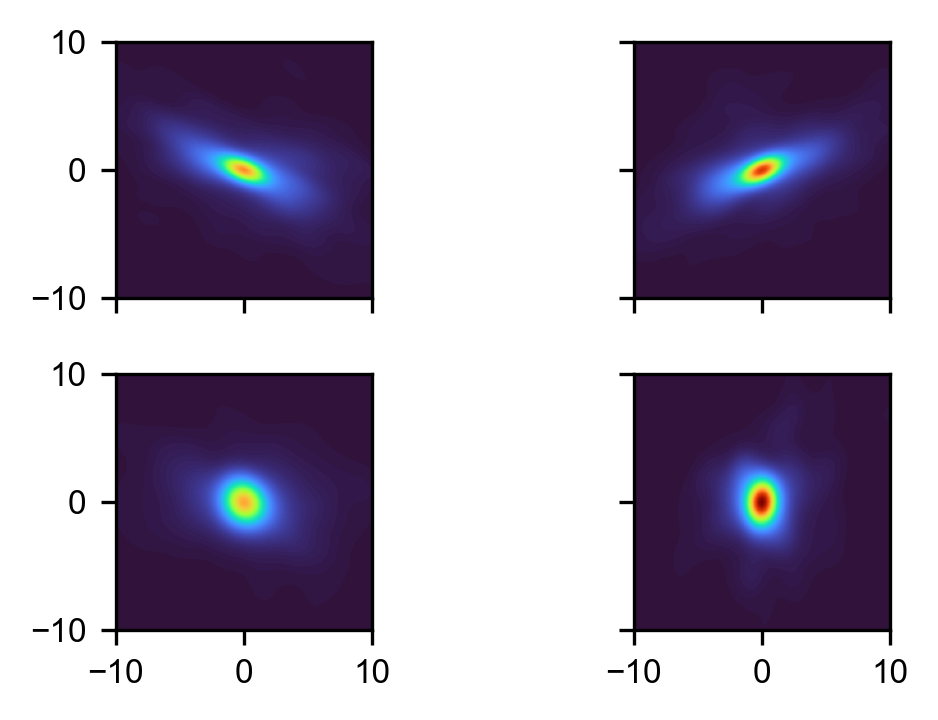

In [71]:
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_heatmaps_degree_verified'
plot_saccade_heatmaps_comparison_trajectories_angular(
    synced_saccade_collection.query('animal=="PV_143"'),
    non_synced_saccade_collection.query('animal=="PV_143"'),
    block_dict,
    export_path=export_path,
    nbins=200, global_min=-10, global_max=10,
    cmap=plt.cm.turbo, figsize=(4, 2.5),
    rotation_catalog=catalog_blender   # <-- add this
)

In [29]:

sub = synced_saccade_collection.query('animal=="PV_143" & eye=="R"').copy()
# Build per-saccade Δφ,Δθ (first→last) and compare the angle to overall_angle_deg
angles_hist = sub['overall_angle_deg'].to_numpy(float)  # from your polar pipeline
# You can also recompute atan2(Δθ, Δφ) from the same segments to verify parity.


(array([138.,  45.,  24.,  88., 262.,  92.,  24.,  40.,  85., 240.]),
 array([1.68655835e-01, 3.61510607e+01, 7.21334656e+01, 1.08115870e+02,
        1.44098275e+02, 1.80080680e+02, 2.16063085e+02, 2.52045490e+02,
        2.88027895e+02, 3.24010300e+02, 3.59992705e+02]),
 <BarContainer object of 10 artists>)

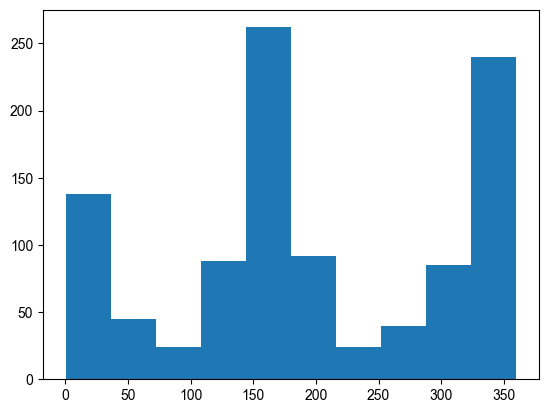

In [33]:
plt.hist(angles_hist)

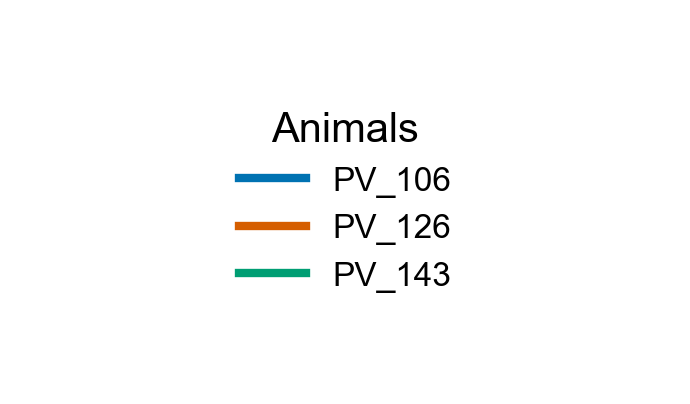


=== Blender-applied rotations (deg; axis-equivalent, [-90,+90)) ===
 animal   L_deg   R_deg LR_diff_deg abs_L_deg abs_R_deg
 PV_106  +25.10  -17.29      -42.39    +25.10    +17.29
 PV_126   -4.46   +6.42      +10.88     +4.46     +6.42
 PV_143   +4.04  -11.91      -15.95     +4.04    +11.91
  PV_57   +6.97   -7.68      -14.64     +6.97     +7.68
  PV_62   -7.33   -6.56       +0.78     +7.33     +6.56


,animal,L_deg,R_deg,LR_diff_deg,abs_L_deg,abs_R_deg
0,PV_106,25.096220,-17.294998,-42.391219,25.096220,17.294998
1,PV_126,-4.459839,6.423051,10.882891,4.459839,6.423051
2,PV_143,4.038460,-11.906944,-15.945404,4.038460,11.906944
3,PV_57,6.966875,-7.676856,-14.643731,6.966875,7.676856
4,PV_62,-7.333125,-6.556844,0.776281,7.333125,6.556844


In [99]:
# You already built:
#   catalog_blender = build_blender_roll_catalog_from_registration(root, animals=None, verbose=True)
#   out_blender = plot_histograms_using_blender_alignment(...)

# 1) Make a separate legend figure using the SAME colors as the plot:
color_map = out_blender['color_map']           # returned by your v3 plotter
save_animal_legend_figure(
    color_map=color_map,
    export_pdf_path=None,
    title="Animals"
)

# 2) Print + export a clear rotation table:
df_rot, export_paths = print_and_export_rotation_table(
    rotation_catalog_min=catalog_blender,
    export_dir=None
)

# (Optional) If you want the table inline in Jupyter as a dataframe:
from IPython.display import display
display(df_rot)


In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pathlib import Path
import datetime as dt

def build_rotation_summary_table(rotation_catalog_min: dict) -> pd.DataFrame:
    """
    rotation_catalog_min: {(animal, 'L'|'R'): deg}
      (deg are axis-equivalent minimal rotations in [-90, +90))

    Returns a tidy table:
        animal | L_deg | R_deg | LR_diff_deg | abs_L_deg | abs_R_deg
    """
    rows = {}
    for (animal, eye), val in rotation_catalog_min.items():
        rows.setdefault(animal, {})[eye] = float(val)

    records = []
    for animal in sorted(rows.keys()):
        L = rows[animal].get('L', np.nan)
        R = rows[animal].get('R', np.nan)
        records.append(dict(
            animal=animal,
            L_deg=L,
            R_deg=R,
            LR_diff_deg=(R - L) if np.isfinite(L) and np.isfinite(R) else np.nan,
            abs_L_deg=abs(L) if np.isfinite(L) else np.nan,
            abs_R_deg=abs(R) if np.isfinite(R) else np.nan,
        ))
    df = pd.DataFrame.from_records(records)
    return df[['animal','L_deg','R_deg','LR_diff_deg','abs_L_deg','abs_R_deg']]

def save_animal_legend_figure(color_map: dict, export_pdf_path: Path = None, title="Animals legend"):
    """
    color_map: {animal: '#hex'} — pass the same color_map you used in the plot
               (e.g., out_blender['color_map'] from your v3 plotter)
    export_pdf_path: if provided, saves a small, clean legend-only PDF.
    """
    animals = list(sorted(color_map.keys()))
    handles = [Line2D([0],[0], color=color_map[a], lw=2.0, label=a) for a in animals]

    # One compact column; adjust fig height to number of animals
    fig_h = 0.35 * max(1, len(handles)) + 0.4
    fig = plt.figure(figsize=(2.4, fig_h), dpi=300)
    fig.legend(
        handles, [h.get_label() for h in handles],
        loc='center', frameon=False, ncol=1, prop={'size': 8}, title=title
    )
    plt.axis('off')
    plt.tight_layout()

    if export_pdf_path is not None:
        export_pdf_path = Path(export_pdf_path)
        export_pdf_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(export_pdf_path, bbox_inches='tight', dpi=300)
        print(f"Legend saved → {export_pdf_path}")
    plt.show()

def print_and_export_rotation_table(rotation_catalog_min: dict, export_dir: Path = None, floatfmt="{:+.2f}"):
    """
    Pretty-print the rotations and optionally save CSV + nicely formatted TXT.

    export_dir: folder to write CSV/TXT (optional)
    floatfmt: formatting for degrees (default '+/-xx.xx')
    """
    df = build_rotation_summary_table(rotation_catalog_min)

    # Pretty console print
    def fmt(x):
        return "" if pd.isna(x) else floatfmt.format(x)
    display_df = df.copy()
    for col in ['L_deg','R_deg','LR_diff_deg','abs_L_deg','abs_R_deg']:
        display_df[col] = display_df[col].map(lambda v: fmt(v))

    print("\n=== Blender-applied rotations (deg; axis-equivalent, [-90,+90)) ===")
    print(display_df.to_string(index=False))

    # Optional exports
    paths = {}
    if export_dir is not None:
        export_dir = Path(export_dir)
        export_dir.mkdir(parents=True, exist_ok=True)
        ts = dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

        csv_path = export_dir / f"{ts}_blender_rotations_per_eye.csv"
        df.to_csv(csv_path, index=False)
        paths['csv'] = str(csv_path)

        txt_path = export_dir / f"{ts}_blender_rotations_per_eye.txt"
        with open(txt_path, "w") as f:
            f.write("Blender-applied rotations (deg; axis-equivalent, [-90,+90))\n")
            f.write(display_df.to_string(index=False))
            f.write("\n")
        paths['txt'] = str(txt_path)

        print(f"\nSaved table → {csv_path}\nSaved pretty text → {txt_path}")
    return df, paths


In [ ]:
from pathlib import Path

# 1) Build the Blender-based catalog by crawling your disks
animals = ['PV_106','PV_143','PV_62','PV_126','PV_57']
base_dir = Path(r"Z:\Nimrod\experiments")  # adjust if your Blender exports live elsewhere

# If your Blender exports live in Z:\Nimrod\experiments\<ANIMAL>\blender_exports, set:
# animal_dir_pattern = r"{animal}\blender_exports"
blender_catalog = build_blender_roll_catalog(
    animals=animals,
    base_dir=base_dir,
    animal_dir_pattern="{animal}",   # change to match your layout
    verbose=True
)

# 2) Plot using Blender corrections (no auto-alignment from data)
out_blender = plot_histograms_using_blender_alignment(
    saccade_collection=synced_saccade_collection,   # your table
    rotation_catalog_min=blender_catalog,
    create_plot_func=create_saccade_polar_histogram_rotated_per_eye_v3,
    figure_size=(5,4),
    export_path=None,     # or a folder to export PDFs/CSVs/PKLs
    num_bins=36,
    baseline_prob=0.005
)


In [26]:
def rotation_explorer_from_out(out, block_collection,
                               start_eye='left', start_animal=None,
                               skip_secs=10, show_grid=True):
    """
    Interactive explorer to visualize histogram-derived rotations on raw video frames.

    Args
    ----
    out : dict
        The dictionary returned by your polar-histogram routine. This function will look for
        one of these keys (first that exists is used):
            - 'rotation_catalog_min'   # recommended: minimal-abs rotations (per your update)
            - 'rotation_catalog'       # original rotation catalog
            - 'rotations'              # fallback name
        Each should map (animal, 'L' or 'R') -> rotation_deg (float)
    block_collection : list[BlockSync]
        Blocks with attributes like .animal_call, .le_videos[0], .re_videos[0].
    start_eye : {'left','right'}
    start_animal : str or None
        If provided, the animal id to start with; otherwise first common animal is used.
    skip_secs : int
        How much to jump with << and >>.
    show_grid : bool
        Start with axis grid visible in the frame inset.

    Controls (click in 'Controls' window)
    -------------------------------------
    Play | Pause | Toggle Rot | Pre-VFlip | Grid | < | > | << | >> | Eye | Animal- | Animal+ | Quit

    Keyboard shortcuts (while 'Frame' focused)
    -----------------------------------------
    q/ESC: quit,  n/p: next/prev frame,  f/b: >>/<<,  r: toggle rotation,  v: pre-vertical-flip,
    g: grid,  e: switch eye,  a/d: animal- / animal+
    """

    # ---------- helpers ----------
    def _draw_axis_grid(img, center, radius, rotation_deg=0.0, color=(220,220,220), thickness=1):
        cx, cy = center
        for deg in [0, 90, 180, 270]:
            ang = np.deg2rad((deg + rotation_deg) % 360.0)
            x2 = int(round(cx + radius * np.cos(ang)))
            y2 = int(round(cy - radius * np.sin(ang)))
            cv2.line(img, (cx, cy), (x2, y2), color, thickness, cv2.LINE_AA)
            tx = int(round(cx + (radius+12) * np.cos(ang)))
            ty = int(round(cy - (radius+12) * np.sin(ang)))
            cv2.putText(img, str(deg), (tx-8, ty+4), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1, cv2.LINE_AA)

    def _catalog_from_out(out):
        for k in ('rotation_catalog_min', 'rotation_catalog', 'rotations'):
            if k in out and isinstance(out[k], dict):
                return out[k]
        # allow passing the catalog directly
        if isinstance(out, dict) and all(isinstance(k, tuple) and len(k) == 2 for k in out.keys()):
            return out
        raise ValueError("Could not find a rotation catalog in 'out'. "
                         "Expected key 'rotation_catalog_min' or 'rotation_catalog'.")

    def _animal_of(block):
        for attr in ('animal_call', 'animal', 'animal_id', 'name'):
            if hasattr(block, attr):
                return str(getattr(block, attr))
        return None

    def _video_for(block, eye):
        if eye == 'left':
            return str(block.le_videos[0])
        else:
            return str(block.re_videos[0])

    def _rotation_for(animal, eye_letter):
        # try exact, then case-insensitive matches on animal label
        for key in catalog.keys():
            a, e = key
            if str(a) == str(animal) and e.upper() == eye_letter:
                return float(catalog[key])
        # normalize animal label by stripping spaces if needed
        for key in catalog.keys():
            a, e = key
            if str(a).replace(' ','') == str(animal).replace(' ','') and e.upper() == eye_letter:
                return float(catalog[key])
        return None  # not found

    # ---------- build indices ----------
    catalog = _catalog_from_out(out)
    animals_in_out = sorted({k[0] for k in catalog.keys()})

    blocks_by_animal = {}
    for b in block_collection:
        a = _animal_of(b)
        if a:
            blocks_by_animal[a] = b

    # intersect animals that exist in both
    common_animals = [a for a in animals_in_out if a in blocks_by_animal]
    if not common_animals:
        raise ValueError("No overlapping animals between 'out' rotation catalog and block_collection.")

    eye = start_eye.lower()
    assert eye in ('left','right'), "start_eye must be 'left' or 'right'"

    if start_animal and start_animal in common_animals:
        ai = common_animals.index(start_animal)
    else:
        ai = 0

    # ---------- UI state ----------
    apply_rotation = True
    pre_vflip = False
    grid_on = bool(show_grid)
    playing = False
    running = True

    # Controls layout
    buttons = {
        'Play':      ((10, 10),  (190, 60)),
        'Pause':     ((10, 70),  (190, 120)),
        'Toggle Rot':((10, 130), (190, 180)),
        'Pre-VFlip': ((10, 190), (190, 240)),
        'Grid':      ((10, 250), (190, 300)),
        '<':         ((10, 310), (90, 360)),
        '>':         ((110, 310),(190, 360)),
        '<<':        ((10, 370), (90, 420)),
        '>>':        ((110, 370),(190, 420)),
        'Eye':       ((10, 430), (190, 480)),
        'Animal-':   ((10, 490), (90, 540)),
        'Animal+':   ((110, 490),(190, 540)),
        'Quit':      ((10, 550), (190, 600)),
    }
    ctrl_h, ctrl_w = 620, 200

    def draw_controls():
        img = np.zeros((ctrl_h, ctrl_w, 3), dtype=np.uint8)
        for name, ((x1, y1), (x2, y2)) in buttons.items():
            cv2.rectangle(img, (x1, y1), (x2, y2), (60, 60, 60), -1)
            cv2.rectangle(img, (x1, y1), (x2, y2), (210, 210, 210), 2)
            cv2.putText(img, name, (x1+8, y1+35), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (230,230,230), 2, cv2.LINE_AA)
        return img

    controls_img = draw_controls()
    cv2.namedWindow('Controls', cv2.WINDOW_NORMAL)
    cv2.namedWindow('Frame', cv2.WINDOW_NORMAL)

    # video state
    cap = None
    W = H = N = fps = None
    last_frame = None

    def open_cap():
        nonlocal cap, W, H, N, fps, last_frame
        if cap is not None:
            cap.release()
        animal = common_animals[ai]
        block = blocks_by_animal[animal]
        video_path = _video_for(block, eye)
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise RuntimeError(f"Cannot open video: {video_path}")
        W  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        H  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        N  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
        last_frame = None

    open_cap()

    # mouse handling
    def on_mouse_controls(event, x, y, flags, param):
        nonlocal playing, apply_rotation, pre_vflip, grid_on, eye, ai, last_frame
        if event != cv2.EVENT_LBUTTONDOWN:
            return
        for name, ((x1, y1), (x2, y2)) in buttons.items():
            if x1 <= x <= x2 and y1 <= y <= y2:
                if name == 'Play':
                    playing = True
                elif name == 'Pause':
                    playing = False
                elif name == 'Toggle Rot':
                    apply_rotation = not apply_rotation
                elif name == 'Pre-VFlip':
                    pre_vflip = not pre_vflip
                elif name == 'Grid':
                    grid_on = not grid_on
                elif name == '<':
                    idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 2
                    cap.set(cv2.CAP_PROP_POS_FRAMES, max(idx, 0))
                    last_frame = None
                elif name == '>':
                    # just let loop advance one frame
                    last_frame = None
                elif name == '<<':
                    idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
                    cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, idx - int(skip_secs*fps)))
                    last_frame = None
                elif name == '>>':
                    idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
                    cap.set(cv2.CAP_PROP_POS_FRAMES, min(N-1, idx + int(skip_secs*fps)))
                    last_frame = None
                elif name == 'Eye':
                    eye = 'right' if eye == 'left' else 'left'
                    open_cap()
                elif name == 'Animal-':
                    ai = (ai - 1) % len(common_animals)
                    open_cap()
                elif name == 'Animal+':
                    ai = (ai + 1) % len(common_animals)
                    open_cap()
                elif name == 'Quit':
                    # handled in main loop by setting running False via key
                    pass
                break

    def on_mouse_frame(event, x, y, flags, param):
        # (reserved for future picks; not needed now)
        return

    cv2.setMouseCallback('Controls', on_mouse_controls)
    cv2.setMouseCallback('Frame', on_mouse_frame)

    # -------- main loop --------
    while True:
        if not running:
            break

        if playing or last_frame is None:
            ok, frame = cap.read()
            if not ok:
                break
            last_frame = frame.copy()
        else:
            frame = last_frame.copy()

        animal = common_animals[ai]
        eye_letter = 'L' if eye == 'left' else 'R'
        rot_deg = _rotation_for(animal, eye_letter)

        disp = frame.copy()

        # Optionally vertical-flip before rotation
        if pre_vflip:
            disp = cv2.flip(disp, 0)

        # Apply rotation to the frame if requested (positive angle in OpenCV is CCW)
        if apply_rotation and rot_deg is not None:
            M = cv2.getRotationMatrix2D((W//2, H//2), rot_deg, 1.0)
            disp = cv2.warpAffine(disp, M, (W, H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

        # Overlay an axis grid to visualize where 0/90/180/270 lie w.r.t. the current frame
        if grid_on:
            inset_center = (int(W*0.86), int(H*0.86))
            grid_radius  = int(min(H, W)*0.12)
            # draw grid in *unrotated* coordinates for reference
            _draw_axis_grid(disp, inset_center, grid_radius, rotation_deg=0.0, color=(200,200,200), thickness=1)

        # HUD
        txt1 = f"{animal} {eye_letter}  rot_from_out={rot_deg:+.1f}°" if rot_deg is not None else f"{animal} {eye_letter}  rot_from_out=NONE"
        txt2 = f"{'ROT:ON' if apply_rotation else 'ROT:OFF'} | {'VFLIPpre:ON' if pre_vflip else 'VFLIPpre:OFF'} | {'GRID:ON' if grid_on else 'GRID:OFF'}"
        cv2.putText(disp, txt1, (14, 26), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (20,20,20), 3, cv2.LINE_AA)
        cv2.putText(disp, txt1, (14, 26), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (240,240,240), 1, cv2.LINE_AA)
        cv2.putText(disp, txt2, (14, 52), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (20,20,20), 3, cv2.LINE_AA)
        cv2.putText(disp, txt2, (14, 52), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (240,240,240), 1, cv2.LINE_AA)

        cv2.imshow('Frame', disp)
        cv2.imshow('Controls', controls_img)

        key = cv2.waitKey(25) & 0xFF
        if key in (ord('q'), 27):   # q or ESC
            break
        elif key == ord('n') or key == ord('>'):
            last_frame = None
        elif key == ord('p') or key == ord('<'):
            idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 2
            cap.set(cv2.CAP_PROP_POS_FRAMES, max(idx, 0))
            last_frame = None
        elif key == ord('f'):
            idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
            cap.set(cv2.CAP_PROP_POS_FRAMES, min(N-1, idx + int(skip_secs*fps)))
            last_frame = None
        elif key == ord('b'):
            idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
            cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, idx - int(skip_secs*fps)))
            last_frame = None
        elif key == ord('r'):
            apply_rotation = not apply_rotation
        elif key == ord('v'):
            pre_vflip = not pre_vflip
        elif key == ord('g'):
            grid_on = not grid_on
        elif key == ord('e'):
            eye = 'right' if eye == 'left' else 'left'
            open_cap()
        elif key == ord('a'):
            ai = (ai - 1) % len(common_animals); open_cap()
        elif key == ord('d'):
            ai = (ai + 1) % len(common_animals); open_cap()

    if cap is not None:
        cap.release()
    cv2.destroyAllWindows()
rotation_explorer_from_out(out, block_collection)

KeyboardInterrupt: 

In [ ]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
import datetime as dt

# --------- small math utils ----------
def _wrap180(x):
    return ((x + 180.0) % 360.0) - 180.0

def _angle_deg(p1, p2, y_down=True):
    """
    Angle of vector p1->p2 in degrees with 0°=right.
    y_down=True => screen/image coords (y increases down).
    If y_down=False => mathematical coords (y up).
    """
    dx = float(p2[0] - p1[0])
    dy = float(p2[1] - p1[1])
    if not y_down:
        dy = -dy
    return float(np.degrees(np.arctan2(dy, dx)) % 360.0)

def _min_error_to_horizontal(angle_deg):
    # horizontal axis is 0/180; minimal absolute distance in degrees
    return float(abs(_wrap180(angle_deg)))

# --------- affine helpers (centered) ----------
def _flipV_affine(W, H):
    """
    Return a 2x3 affine that vertically flips an image of size (H, W).
    OpenCV convention (y down): y' = -y + (H-1)
    """
    return np.array([[1,  0,      0],
                     [0, -1,  H - 1]], dtype=np.float32)

def _rot_affine(W, H, deg):
    """
    2x3 rotation around image center (OpenCV: CCW positive).
    """
    return cv2.getRotationMatrix2D((W/2.0, H/2.0), deg, 1.0).astype(np.float32)

def _compose_affine(W, H, rot_deg=0.0, pre_vflip=False):
    """
    Compose raw->display affine as 3x3 homogeneous internally, then return 2x3.
    Order: (optional) vertical flip, then rotation.
    """
    A = np.eye(3, dtype=np.float32)

    if pre_vflip:
        Mv = np.eye(3, dtype=np.float32)
        Mv[:2, :] = _flipV_affine(W, H)           # embed 2x3 as 3x3
        A = Mv @ A

    if abs(rot_deg) > 1e-9:
        Mr = np.eye(3, dtype=np.float32)
        Mr[:2, :] = _rot_affine(W, H, rot_deg)    # embed 2x3 as 3x3
        A = Mr @ A

    return A[:2, :]  # OpenCV wants 2x3

def _apply_affine_to_points(M2x3, pts):
    """
    pts: list/array of (x,y). Returns Nx2 array of transformed points.
    """
    if len(pts) == 0:
        return np.empty((0,2), dtype=np.float32)
    pts = np.asarray(pts, dtype=np.float32)
    ones = np.ones((pts.shape[0], 1), dtype=np.float32)
    XY1  = np.hstack([pts, ones])
    XYp  = (M2x3 @ XY1.T).T
    return XYp

# --------- main tool ----------
def tear_duct_alignment_explorer(out, block_collection,
                                 export_dir=None,
                                 start_eye='left',
                                 start_animal=None,
                                 skip_secs=10,
                                 show_grid=True):
    """
    Interactive explorer to annotate tear-duct axis (rostral->caudal) and quantify
    alignment to horizontal before/after applying:
      - pre-vertical flip
      - per-eye minimal rotation from out['rotation_catalog_min'] (degrees)

    Controls (mouse on 'Controls' window)
    -------------------------------------
    Play | Pause | Toggle Rot | Pre-VFlip | Grid | < | > | << | >> | Eye | Animal- | Animal+ | Save | Clear | Export | Quit

    Keyboard (on 'Frame')
    ---------------------
    q/ESC quit | r toggle rotation | v pre-vflip | g grid |
    n/p next/prev frame | f/b >>/<< | e switch eye | a/d animal- / animal+ |
    s save current annotation | c clear points

    Annotation (on 'Frame')
    -----------------------
    Left-click sets ROSTRAL point, then CAUDAL point (2 clicks). A third click replaces ROSTRAL, etc.
    The two raw points are stored; their transformed positions are computed under the current toggles.
    """

    # --- catalog & block lookup ---
    if not isinstance(out, dict) or 'rotation_catalog_min' not in out:
        raise ValueError("Expected out['rotation_catalog_min'] with {(animal,'L'|'R'): float} degrees.")
    catalog = out['rotation_catalog_min']

    def _animal_of(block):
        for attr in ('animal_call', 'animal', 'animal_id', 'name'):
            if hasattr(block, attr):
                return str(getattr(block, attr))
        return None

    def _video_for(block, eye):
        return str(block.le_videos[0]) if eye == 'left' else str(block.re_videos[0])

    blocks_by_animal = {}
    for b in block_collection:
        a = _animal_of(b)
        if a:
            blocks_by_animal[a] = b

    animals_catalog = sorted({k[0] for k in catalog.keys()})
    common_animals = [a for a in animals_catalog if a in blocks_by_animal]
    if not common_animals:
        raise ValueError("No overlap between out['rotation_catalog_min'] animals and block_collection.")

    # --- UI state ---
    eye = start_eye.lower()
    assert eye in ('left', 'right')
    ai = common_animals.index(start_animal) if (start_animal in common_animals) else 0

    apply_rotation = True
    pre_vflip = bool(show_grid)  # default: start with same sense as your earlier tests
    grid_on = bool(show_grid)
    playing = False

    # annotations (stored in RAW coords, per displayed frame)
    rostral_raw = None
    caudal_raw  = None

    # data log
    export_dir = Path(export_dir) if export_dir else None
    rows = []

    # Controls layout
    buttons = {
        'Play':      ((10,  10),(190, 60)),
        'Pause':     ((10,  70),(190,120)),
        'Toggle Rot':((10, 130),(190,180)),
        'Pre-VFlip': ((10, 190),(190,240)),
        'Grid':      ((10, 250),(190,300)),
        '<':         ((10, 310),(90, 360)),
        '>':         ((110,310),(190,360)),
        '<<':        ((10, 370),(90, 420)),
        '>>':        ((110,370),(190,420)),
        'Eye':       ((10, 430),(190,480)),
        'Animal-':   ((10, 490),(90, 540)),
        'Animal+':   ((110,490),(190,540)),
        'Save':      ((10, 550),(90, 600)),
        'Clear':     ((110,550),(190,600)),
        'Export':    ((10, 610),(190,660)),
        'Quit':      ((10, 670),(190,720)),
    }
    ctrl_h, ctrl_w = 740, 200

    def draw_controls():
        img = np.zeros((ctrl_h, ctrl_w, 3), dtype=np.uint8)
        for name, ((x1, y1), (x2, y2)) in buttons.items():
            cv2.rectangle(img, (x1, y1), (x2, y2), (60, 60, 60), -1)
            cv2.rectangle(img, (x1, y1), (x2, y2), (210,210,210), 2)
            cv2.putText(img, name, (x1+8, y1+35), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (230,230,230), 2, cv2.LINE_AA)
        return img

    def _rotation_for(animal, eye_letter):
        return float(catalog.get((animal, eye_letter), 0.0))

    def _draw_axis_grid(img, center, radius, rotation_deg=0.0, color=(220,220,220), thickness=1):
        cx, cy = center
        for deg in [0, 90, 180, 270]:
            ang = np.deg2rad((deg + rotation_deg) % 360.0)
            x2 = int(round(cx + radius * np.cos(ang)))
            y2 = int(round(cy - radius * np.sin(ang)))
            cv2.line(img, (cx, cy), (x2, y2), color, thickness, cv2.LINE_AA)
            tx = int(round(cx + (radius+12) * np.cos(ang)))
            ty = int(round(cy - (radius+12) * np.sin(ang)))
            cv2.putText(img, str(deg), (tx-8, ty+4), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1, cv2.LINE_AA)

    controls_img = draw_controls()
    cv2.namedWindow('Controls', cv2.WINDOW_NORMAL)
    cv2.namedWindow('Frame',    cv2.WINDOW_NORMAL)

    cap = None; W=H=N=fps=None; last_frame=None

    def open_cap():
        nonlocal cap, W, H, N, fps, last_frame
        if cap is not None:
            cap.release()
        animal = common_animals[ai]
        block  = blocks_by_animal[animal]
        video_path = _video_for(block, eye)
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise RuntimeError(f"Cannot open: {video_path}")
        W  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        H  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        N  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
        last_frame = None

    open_cap()

    # ---- mouse callbacks ----
    def on_mouse_controls(event, x, y, flags, param):
        nonlocal playing, apply_rotation, pre_vflip, grid_on, eye, ai, last_frame, rostral_raw, caudal_raw
        if event != cv2.EVENT_LBUTTONDOWN:
            return
        for name, ((x1, y1), (x2, y2)) in buttons.items():
            if x1 <= x <= x2 and y1 <= y <= y2:
                if name == 'Play':
                    playing = True
                elif name == 'Pause':
                    playing = False
                elif name == 'Toggle Rot':
                    apply_rotation = not apply_rotation
                elif name == 'Pre-VFlip':
                    pre_vflip = not pre_vflip
                elif name == 'Grid':
                    grid_on = not grid_on
                elif name == '<':
                    idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 2
                    cap.set(cv2.CAP_PROP_POS_FRAMES, max(idx, 0)); last_frame = None
                elif name == '>':
                    last_frame = None
                elif name == '<<':
                    idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
                    cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, idx - int(skip_secs*fps))); last_frame = None
                elif name == '>>':
                    idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
                    cap.set(cv2.CAP_PROP_POS_FRAMES, min(N-1, idx + int(skip_secs*fps))); last_frame = None
                elif name == 'Eye':
                    eye = 'right' if eye == 'left' else 'left'
                    rostral_raw = None; caudal_raw = None
                    open_cap()
                elif name == 'Animal-':
                    ai = (ai - 1) % len(common_animals)
                    rostral_raw = None; caudal_raw = None
                    open_cap()
                elif name == 'Animal+':
                    ai = (ai + 1) % len(common_animals)
                    rostral_raw = None; caudal_raw = None
                    open_cap()
                elif name == 'Save':
                    _save_current()
                elif name == 'Clear':
                    rostral_raw = None; caudal_raw = None
                elif name == 'Export':
                    _export_csv()
                elif name == 'Quit':
                    _export_csv()
                    cv2.destroyAllWindows()
                    if cap is not None: cap.release()
                    raise SystemExit
                break

    def on_mouse_frame(event, x, y, flags, param):
        # Convert display click -> RAW coords via inverse affine of current toggles
        nonlocal rostral_raw, caudal_raw
        if event != cv2.EVENT_LBUTTONDOWN:
            return
        # Build current forward affine (raw->display), then invert for mapping back
        animal = common_animals[ai]
        rot_deg = _rotation_for(animal, 'L' if eye == 'left' else 'R') if apply_rotation else 0.0
        M = _compose_affine(W, H, rot_deg=rot_deg, pre_vflip=pre_vflip)
        Minv = cv2.invertAffineTransform(M)
        raw_xy = _apply_affine_to_points(Minv, [(x, y)])[0]  # 1x2
        raw_xy = (float(raw_xy[0]), float(raw_xy[1]))
        # Fill rostral then caudal alternating
        if rostral_raw is None:
            rostral_raw = raw_xy
        elif caudal_raw is None:
            caudal_raw = raw_xy
        else:
            # replace rostral to ease correction
            rostral_raw = raw_xy
            caudal_raw  = None

    cv2.setMouseCallback('Controls', on_mouse_controls)
    cv2.setMouseCallback('Frame',    on_mouse_frame)

    # ---- save/export helpers ----
    def _save_current():
        if rostral_raw is None or caudal_raw is None:
            print("Annotate rostral and caudal (two clicks) before saving.")
            return
        animal = common_animals[ai]
        eye_letter = 'L' if eye == 'left' else 'R'
        rot_deg = _rotation_for(animal, eye_letter) if apply_rotation else 0.0
        M = _compose_affine(W, H, rot_deg=rot_deg, pre_vflip=pre_vflip)
        # transformed points (what you see on screen)
        ros_disp, cau_disp = _apply_affine_to_points(M, [rostral_raw, caudal_raw])

        # angles
        ang_raw  = _angle_deg(rostral_raw, caudal_raw, y_down=True)
        ang_disp = _angle_deg(tuple(ros_disp), tuple(cau_disp), y_down=True)
        err_horiz = _min_error_to_horizontal(ang_disp)

        row = dict(
            timestamp=dt.datetime.now().isoformat(timespec='seconds'),
            animal=animal, eye=eye_letter,
            frame_idx=max(int(cap.get(cv2.CAP_PROP_POS_FRAMES))-1,0),
            W=W, H=H,
            apply_rotation=bool(apply_rotation),
            pre_vflip=bool(pre_vflip),
            rot_deg_out=float(rot_deg),
            rostral_x=float(rostral_raw[0]), rostral_y=float(rostral_raw[1]),
            caudal_x=float(caudal_raw[0]),  caudal_y=float(caudal_raw[1]),
            angle_raw_deg=float(ang_raw),
            angle_disp_deg=float(ang_disp),
            error_to_horizontal_deg=float(err_horiz),
        )
        rows.append(row)
        print(f"[saved] {animal} {eye_letter} f={row['frame_idx']} | angle_disp={ang_disp:.1f}° | err={err_horiz:.1f}°")

    def _export_csv():
        if not rows:
            print("Nothing to export yet.")
            return
        df = pd.DataFrame(rows)
        if export_dir is None:
            print(df.tail(min(5, len(df))))
            return
        export_dir.mkdir(parents=True, exist_ok=True)
        ts = dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        path = export_dir / f"{ts}_tear_duct_annotations.csv"
        df.to_csv(path, index=False)
        print("Exported annotations ->", path)

    # ---- main loop ----
    while True:
        if playing or last_frame is None:
            ok, frame = cap.read()
            if not ok:
                break
            last_frame = frame.copy()
        else:
            frame = last_frame.copy()

        animal = common_animals[ai]
        eye_letter = 'L' if eye == 'left' else 'R'
        rot_deg = _rotation_for(animal, eye_letter) if apply_rotation else 0.0

        disp = frame.copy()
        # forward transform for display
        M = _compose_affine(W, H, rot_deg=rot_deg, pre_vflip=pre_vflip)
        disp = cv2.warpAffine(disp, M, (W, H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

        # draw annotation (transformed to display)
        if rostral_raw is not None:
            pts = _apply_affine_to_points(M, [rostral_raw])
            p = tuple(int(round(v)) for v in pts[0])
            cv2.circle(disp, p, 5, (0, 200, 255), -1)  # rostral
            cv2.putText(disp, "Rostral", (p[0]+6, p[1]-6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,200,255), 1, cv2.LINE_AA)
        if caudal_raw is not None:
            pts = _apply_affine_to_points(M, [caudal_raw])
            p = tuple(int(round(v)) for v in pts[0])
            cv2.circle(disp, p, 5, (255, 180, 0), -1)  # caudal
            cv2.putText(disp, "Caudal", (p[0]+6, p[1]-6), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,180,0), 1, cv2.LINE_AA)
        if rostral_raw is not None and caudal_raw is not None:
            pts = _apply_affine_to_points(M, [rostral_raw, caudal_raw])
            p1 = tuple(int(round(v)) for v in pts[0])
            p2 = tuple(int(round(v)) for v in pts[1])
            cv2.arrowedLine(disp, p1, p2, (0,255,0), 2, cv2.LINE_AA, tipLength=0.25)

            # angle/error readout in display space
            ang_disp = _angle_deg(pts[0], pts[1], y_down=True)
            err_h   = _min_error_to_horizontal(ang_disp)
            txtA = f"angle_disp={ang_disp:.1f} deg"
            txtB = f"err->horizontal={err_h:.1f} deg"
            cv2.putText(disp, txtA, (14, 84), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (20,20,20), 3, cv2.LINE_AA)
            cv2.putText(disp, txtA, (14, 84), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (240,240,240), 1, cv2.LINE_AA)
            cv2.putText(disp, txtB, (14, 110), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (20,20,20), 3, cv2.LINE_AA)
            cv2.putText(disp, txtB, (14, 110), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (240,240,240), 1, cv2.LINE_AA)

        # grid overlay (0/90/180/270 in display space for visual sanity)
        if grid_on:
            inset_center = (int(W*0.86), int(H*0.86))
            grid_radius  = int(min(H, W)*0.12)
            _draw_axis_grid(disp, inset_center, grid_radius, rotation_deg=0.0, color=(200,200,200), thickness=1)

        # HUD
        txt1 = f"{animal} {eye_letter} | rot_from_out={'ON' if apply_rotation else 'OFF'} ({rot_deg:+.1f}°)"
        txt2 = f"preVFlip={'ON' if pre_vflip else 'OFF'} | GRID={'ON' if grid_on else 'OFF'}"
        cv2.putText(disp, txt1, (14, 26), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (20,20,20), 3, cv2.LINE_AA)
        cv2.putText(disp, txt1, (14, 26), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (240,240,240), 1, cv2.LINE_AA)
        cv2.putText(disp, txt2, (14, 52), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (20,20,20), 3, cv2.LINE_AA)
        cv2.putText(disp, txt2, (14, 52), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (240,240,240), 1, cv2.LINE_AA)

        cv2.imshow('Frame', disp)
        cv2.imshow('Controls', controls_img)

        key = cv2.waitKey(25) & 0xFF
        if key in (ord('q'), 27): break
        elif key == ord('n'): last_frame = None
        elif key == ord('p'):
            idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 2
            cap.set(cv2.CAP_PROP_POS_FRAMES, max(idx, 0)); last_frame=None
        elif key == ord('f'):
            idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
            cap.set(cv2.CAP_PROP_POS_FRAMES, min(N-1, idx + int(skip_secs*fps))); last_frame=None
        elif key == ord('b'):
            idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
            cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, idx - int(skip_secs*fps))); last_frame=None
        elif key == ord('r'): apply_rotation = not apply_rotation
        elif key == ord('v'): pre_vflip = not pre_vflip
        elif key == ord('g'): grid_on = not grid_on
        elif key == ord('e'):
            eye = 'right' if eye == 'left' else 'left'
            rostral_raw = None; caudal_raw = None
            open_cap()
        elif key == ord('a'):
            ai = (ai - 1) % len(common_animals); rostral_raw = None; caudal_raw = None; open_cap()
        elif key == ord('d'):
            ai = (ai + 1) % len(common_animals); rostral_raw = None; caudal_raw = None; open_cap()
        elif key == ord('s'):
            _save_current()
        elif key == ord('c'):
            rostral_raw = None; caudal_raw = None

    # on exit
    if cap is not None: cap.release()
    cv2.destroyAllWindows()
    # export summary to console if not saved
    if rows and export_dir is None:
        print(pd.DataFrame(rows).tail(min(10, len(rows))))


In [ ]:
tear_duct_alignment_explorer(
    out,
    block_collection,
    export_dir=None # or None to just print
)


In [ ]:
cv2.destroy_all_windows()

In [ ]:
# ===================== Tear-duct alignment explorer (directionless) =====================
# Adds a clickable "Controls" window alongside the display window.
# Accepts out['rotation_catalog_min'] OR out['rotation_dict'] OR a bare rotation mapping.

import cv2
import json
import math
import numpy as np
import pandas as pd
from pathlib import Path
import datetime as dt
from collections import defaultdict

# --- JSON helpers (add once, near your other helpers) ---
def _to_serializable(obj):
    """Recursively convert numpy/pandas/tuples/sets to JSON-safe types."""
    import numpy as _np, pandas as _pd
    if isinstance(obj, dict):
        new = {}
        for k, v in obj.items():
            # convert non-JSON-able keys (like tuples) to strings
            if isinstance(k, tuple):
                k = "|".join(map(str, k))
            elif not isinstance(k, (str, int, float, bool)) and k is not None:
                k = str(k)
            new[k] = _to_serializable(v)
        return new
    if isinstance(obj, (list, tuple, set)):
        return [_to_serializable(x) for x in obj]
    if isinstance(obj, (_np.floating, _np.integer)):
        return obj.item()
    if isinstance(obj, _np.ndarray):
        return obj.tolist()
    if isinstance(obj, _pd.DataFrame):
        return obj.to_dict(orient="records")
    if isinstance(obj, _pd.Series):
        return obj.to_dict()
    return obj

def _rotation_dict_as_records(rot):
    """
    Convert {(animal, eye): {.../float}} -> list of records with string keys.
    """
    out = []
    for (animal, eye), val in rot.items():
        rec = {"animal": str(animal), "eye": str(eye)}
        if isinstance(val, dict):
            for k, vv in val.items():
                # cast common numeric fields to plain Python numbers
                if k in ("rotation_deg", "rotation_deg_min", "rotation_deg_raw",
                         "peak_center_deg", "n"):
                    try:
                        rec[k] = float(vv)
                    except Exception:
                        rec[k] = _to_serializable(vv)
                else:
                    rec[k] = _to_serializable(vv)
        else:
            rec["rotation_deg"] = float(val)
        out.append(rec)
    return out


# --------------------- rotation mapping normalization ---------------------

def _looks_like_rotation_mapping(d: dict) -> bool:
    if not isinstance(d, dict) or not d:
        return False
    # tuple or 2-level mapping
    if all(isinstance(k, tuple) and len(k) >= 2 for k in d.keys()):
        return True
    for a, sub in d.items():
        if isinstance(sub, dict) and any(str(k).upper().startswith(('L','R')) for k in sub.keys()):
            return True
    return False

def _try_extract_rotation_pairs(d: dict):
    # tuple-key mapping: { (animal, 'L'/'R'): deg or {'rotation_deg':deg} }
    if all(isinstance(k, tuple) and len(k) >= 2 for k in d.keys()):
        for k, v in d.items():
            animal = str(k[0])
            e_raw  = str(k[1]).upper()
            eye    = 'L' if e_raw.startswith('L') else ('R' if e_raw.startswith('R') else None)
            if eye is None:
                continue
            val = v['rotation_deg'] if isinstance(v, dict) and 'rotation_deg' in v else v
            try:
                yield (animal, eye), float(val)
            except Exception:
                continue
        return
    # nested mapping: { animal: {'L': deg, 'R': deg} }
    any_yield = False
    for a, sub in d.items():
        if not isinstance(sub, dict):
            continue
        for e, v in sub.items():
            e_raw = str(e).upper()
            eye   = 'L' if e_raw.startswith('L') else ('R' if e_raw.startswith('R') else None)
            if eye is None:
                continue
            val = v['rotation_deg'] if isinstance(v, dict) and 'rotation_deg' in v else v
            try:
                yield (str(a), eye), float(val)
                any_yield = True
            except Exception:
                continue
    if any_yield:
        return

def _normalize_rotation_dict(rot_like):
    """Return {(animal,'L'/'R'):{'rotation_deg':float}} from many input shapes."""
    norm = {}

    if isinstance(rot_like, pd.DataFrame):
        for _, row in rot_like.iterrows():
            animal = str(row['animal'])
            e_raw  = str(row['eye']).upper()
            eye    = 'L' if e_raw.startswith('L') else ('R' if e_raw.startswith('R') else None)
            if eye is None:
                continue
            try:
                deg = float(row['rotation_deg'])
            except Exception:
                continue
            norm[(animal, eye)] = {'rotation_deg': deg}
        if norm:
            return norm
        raise ValueError("Rotation DataFrame did not contain usable rows.")

    if isinstance(rot_like, (list, tuple)):
        for item in rot_like:
            if isinstance(item, dict):
                try:
                    cand = _normalize_rotation_dict(item)
                    if cand:
                        return cand
                except Exception:
                    pass
        raise ValueError("Could not find a rotation mapping inside the tuple/list provided.")

    if isinstance(rot_like, dict):
        if 'rotation_catalog_min' in rot_like and isinstance(rot_like['rotation_catalog_min'], dict):
            return _normalize_rotation_dict(rot_like['rotation_catalog_min'])
        if 'rotation_dict' in rot_like and isinstance(rot_like['rotation_dict'], dict):
            return _normalize_rotation_dict(rot_like['rotation_dict'])

        if not _looks_like_rotation_mapping(rot_like):
            raise ValueError("Provided dict does not look like a rotation mapping.")
        for (animal, eye), deg in _try_extract_rotation_pairs(rot_like):
            norm[(animal, eye)] = {'rotation_deg': float(deg)}
        if norm:
            return norm
        raise ValueError("Rotation dict was detected, but contained no numeric rotation entries.")

    raise ValueError("Unsupported rotation_dict format (expected dict/tuple/list/DataFrame).")

def _get_rot_deg(rotation_dict, animal, eye_code):
    key = (animal, eye_code)
    if key not in rotation_dict:
        raise KeyError(f"Rotation not found for {(animal, eye_code)}")
    v = rotation_dict[key]
    return float(v['rotation_deg']) if isinstance(v, dict) else float(v)

# --------------------- geometry / angle helpers ---------------------

def _wrap_180(a):
    """Wrap angle (deg) to [-180,180)."""
    a = (a + 180.0) % 360.0 - 180.0
    return a

def _line_angle_deg(p1, p2):
    """Directed angle (deg) from p1->p2 in image coords (x right, y down)."""
    (x1,y1),(x2,y2)=p1,p2
    ang = math.degrees(math.atan2(-(y2-y1), (x2-x1)))  # minus for y-down to math y-up
    return ang

def _line_angle_directionless_deg(p1, p2):
    """Line orientation in [0,180): directionless (axis)."""
    a = _line_angle_deg(p1,p2) % 180.0
    return a

def _dirless_error_to_horizontal_deg(a_dirless):
    """Shortest abs deviation from horizontal axis (0/180)."""
    a = a_dirless % 180.0
    return min(a, 180.0 - a)

# --------------------- affine helpers (display transforms) ---------------------

def _flipV_affine_3x3(W, H):
    cx, cy = (W-1)/2.0, (H-1)/2.0
    A1 = np.array([[1,0, -cx],
                   [0,1, -cy],
                   [0,0,   1]], dtype=np.float32)
    F  = np.array([[1,0,0],
                   [0,-1,0],
                   [0,0,1]], dtype=np.float32)
    A2 = np.array([[1,0, cx],
                   [0,1, cy],
                   [0,0, 1]], dtype=np.float32)
    return A2 @ (F @ A1)

def _rot_affine_3x3(W, H, deg):
    cx, cy = (W-1)/2.0, (H-1)/2.0
    M2 = cv2.getRotationMatrix2D((cx, cy), deg, 1.0)  # 2x3
    M  = np.vstack([M2, [0,0,1]]).astype(np.float32)
    return M

def _compose_affine_2x3(W, H, rot_deg=0.0, pre_vflip=False):
    A = np.eye(3, dtype=np.float32)
    if pre_vflip:
        A = _flipV_affine_3x3(W,H) @ A
    if abs(rot_deg) > 1e-9:
        A = _rot_affine_3x3(W,H, rot_deg) @ A
    return A[:2,:], A  # (2x3 for warpAffine, full 3x3 for point transforms)

def _apply_affine_to_pts(A3, pts):
    # pts: list of (x,y) in raw frame -> returns list in display coords
    P = np.c_[np.array(pts, dtype=np.float32), np.ones((len(pts),1),dtype=np.float32)]  # Nx3
    Q = (A3 @ P.T).T
    return [(float(q[0]), float(q[1])) for q in Q]

def _inv_affine(A3):
    return np.linalg.inv(A3)

# --------------------- block helpers ---------------------

def _index_blocks_by_animal(block_collection):
    by_animal = defaultdict(list)
    for b in block_collection:
        by_animal[str(b.animal_call)].append(b)
    first_block = {a: blks[0] for a, blks in by_animal.items()}
    return by_animal, first_block

def _video_for_eye(block, eye_code):
    if eye_code == 'L':
        if not getattr(block, 'le_videos', None) or not block.le_videos:
            raise RuntimeError(f"No left-eye video for {block}")
        return block.le_videos[0]
    else:
        if not getattr(block, 're_videos', None) or not block.re_videos:
            raise RuntimeError(f"No right-eye video for {block}")
        return block.re_videos[0]

def _per_frame_ms_axis(block, eye_code, N):
    df_eye = (block.left_eye_data if eye_code=='L' else block.right_eye_data)
    frame_col = 'eye_frame' if 'eye_frame' in df_eye.columns else 'frame'
    if 'ms_axis' not in df_eye.columns:
        return None
    ts = np.full(N, np.nan, dtype='float64')
    fr = df_eye[[frame_col, 'ms_axis']].dropna().astype({frame_col:int})
    valid = fr[(fr[frame_col] >= 0) & (fr[frame_col] < N)]
    ts[valid[frame_col].to_numpy()] = valid['ms_axis'].to_numpy()
    idxs = np.arange(N)
    nan = np.isnan(ts)
    if nan.all():
        return None
    if nan.any():
        ts[nan] = np.interp(idxs[nan], idxs[~nan], ts[~nan])
    return ts

# --------------------- serialization helpers ---------------------

def _to_serializable(obj):
    if isinstance(obj, (np.floating, np.integer)):
        return obj.item()
    if isinstance(obj, (tuple, list)):
        return [_to_serializable(x) for x in obj]
    if isinstance(obj, dict):
        return {k: _to_serializable(v) for k, v in obj.items()}
    return obj

def _summarize_annotations(ann):
    # ann: dict[animal][eye] -> list of records
    per_animal = {}
    total_raw, total_rot, n_total, n_eyes = 0.0, 0.0, 0, 0
    animals_annot = 0
    for animal, ed in ann.items():
        per_animal[animal] = {}
        any_eye = False
        for eye in ('L','R'):
            lst = ed.get(eye, [])
            if not lst:
                continue
            any_eye = True
            n = len(lst)
            raw_errs = [r['err_raw_to_horiz_deg_abs'] for r in lst]
            rot_errs = [r['err_display_to_horiz_deg_abs'] for r in lst]
            per_animal[animal][eye] = {
                'n': n,
                'raw_mean_err_deg': float(np.mean(raw_errs)),
                'raw_median_err_deg': float(np.median(raw_errs)),
                'rot_mean_err_deg': float(np.mean(rot_errs)),
                'rot_median_err_deg': float(np.median(rot_errs)),
            }
            total_raw += float(np.sum(raw_errs))
            total_rot += float(np.sum(rot_errs))
            n_total += n
            n_eyes  += 1
        if any_eye:
            animals_annot += 1
    overall = {
        'n_animals_annotated': int(animals_annot),
        'n_eyes_annotated': int(n_eyes),
        'n_measurements': int(n_total),
        'overall_mean_raw_err_deg': float(total_raw / n_total) if n_total else None,
        'overall_mean_rot_err_deg': float(total_rot / n_total) if n_total else None,
    }
    return {'per_animal': per_animal, 'overall': overall}

# --------------------- main explorer with Controls window ---------------------

def tear_duct_alignment_explorer(
    out,
    block_collection,
    export_dir=None,           # if None -> use first block's analysis_path / 'tear_duct_annotations' (or CWD)
    start_animal=None,
    start_eye='left',          # 'left' or 'right'
    skip_secs=60,
    show_grid=True,
    line_len=80
):
    """
    Interactive explorer to annotate tear-duct axis and read back directionless error to horizon,
    before and after (display) transform (pre-vertical-flip + rotation).

    Windows:
      - 'TearDuct Frame' : video frame (click to place points when armed)
      - 'Controls'       : clickable buttons

    Controls (mouse on 'Controls' or keyboard on 'Frame'):
      Play/Pause (SPACE) | Prev/Next frame (p/n) | Back/Forward ±skip (b/f)
      Toggle Rotation (r) | Toggle VFlip (v) | Toggle Eye (e)
      Prev/Next Animal (a/d)
      Arm Rostral (1) | Arm Caudal (2) | Clear (c)
      Save Pair (s) | Export (S) | Quit (q or ESC)
    """
    # --- normalize rotations from 'out' ---
    raw_rot = None
    if isinstance(out, dict):
        if 'rotation_catalog_min' in out and isinstance(out['rotation_catalog_min'], dict):
            raw_rot = out['rotation_catalog_min']
        elif 'rotation_dict' in out and isinstance(out['rotation_dict'], dict):
            raw_rot = out['rotation_dict']
    if raw_rot is None:
        raw_rot = out  # mapping itself, DataFrame, or container
    rotation_dict = _normalize_rotation_dict(raw_rot)

    # --- block maps ---
    by_animal, first_block = _index_blocks_by_animal(block_collection)
    animals_in_rot = sorted({a for (a,_) in rotation_dict.keys()})
    animals = sorted(set(first_block.keys()) & set(animals_in_rot))
    if not animals:
        raise ValueError("No overlapping animals between rotation_dict and block_collection.")

    # pick start animal
    if start_animal is None or start_animal not in animals:
        cur_animal_idx = 0
    else:
        cur_animal_idx = animals.index(start_animal)

    eye_code = 'L' if str(start_eye).lower().startswith('l') else 'R'

    # --- export dir ---
    if export_dir is None:
        base_block = first_block[animals[cur_animal_idx]]
        base_path = getattr(base_block, 'analysis_path', None)
        base_path = Path(base_path) if base_path is not None else Path.cwd()
        export_dir = base_path / "tear_duct_annotations"
    export_dir = Path(export_dir)
    export_dir.mkdir(parents=True, exist_ok=True)

    # --- session state ---
    session = {
        'export_dir': str(export_dir),
        'rotation_dict': rotation_dict,
        'annotations': defaultdict(lambda: {'L': [], 'R': []}),
        'last_record': None,
        'stats': None
    }

    # --- video open helper ---
    def open_video(animal, eye_code):
        blk = first_block[animal]
        vid = _video_for_eye(blk, eye_code)
        cap = cv2.VideoCapture(str(vid))
        if not cap.isOpened():
            raise RuntimeError(f"Cannot open video: {vid}")
        W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        N = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
        per_ts = _per_frame_ms_axis(blk, eye_code, N)
        return cap, W, H, N, fps, per_ts, str(vid)

    # start video
    cap, W, H, N, fps, per_ts, cur_video_path = open_video(animals[cur_animal_idx], eye_code)
    skip_frames = int(round(skip_secs * fps))
    playing = False
    rot_on  = True
    vflip   = False

    # working points (display coords)
    working = {'R': None, 'C': None}  # rostral, caudal
    arm_mode = None  # 'R' or 'C' or None

    # current transforms
    def current_affine():
        rot_deg = _get_rot_deg(rotation_dict, animals[cur_animal_idx], eye_code) if rot_on else 0.0
        M2, M3 = _compose_affine_2x3(W, H, rot_deg=rot_deg, pre_vflip=vflip)
        return rot_deg, M2, M3

    # mouse callback for Frame (place points when armed)
    WINDOW_FRAME = "TearDuct Frame"
    cv2.namedWindow(WINDOW_FRAME, cv2.WINDOW_NORMAL)
    def on_mouse_frame(event, x, y, flags, param):
        nonlocal working, arm_mode
        if event != cv2.EVENT_LBUTTONDOWN:
            return
        if arm_mode in ('R','C'):
            working[arm_mode] = (float(x), float(y))
            arm_mode = None  # disarm
    cv2.setMouseCallback(WINDOW_FRAME, on_mouse_frame)

    # --------------- Controls window (buttons) ---------------
    WINDOW_CTRL = "Controls"
    cv2.namedWindow(WINDOW_CTRL, cv2.WINDOW_NORMAL)

    # Layout: grid of buttons
    ctrl_w, ctrl_h = 1000, 360
    btn_w, btn_h = 150, 60
    margin_x, margin_y = 10, 10
    gap_x, gap_y = 10, 10

    # Arrange buttons in rows
    labels_rows = [
        ["Play", "Pause", "Prev", "Next", f"Back-{skip_secs}s", f"Fwd+{skip_secs}s"],
        ["Toggle Rot", "Toggle VFlip", "Toggle Eye", "Prev Animal", "Next Animal"],
        ["Arm Rostral", "Arm Caudal", "Clear", "Save Pair", "Export", "Quit"],
    ]

    # Build rectangles
    buttons = {}
    y = margin_y
    for row in labels_rows:
        x = margin_x
        for name in row:
            buttons[name] = ((x, y), (x+btn_w, y+btn_h))
            x += btn_w + gap_x
        y += btn_h + gap_y

    # draw controls image according to state
    def draw_controls_img():
        img = np.zeros((ctrl_h, ctrl_w, 3), dtype=np.uint8)
        # header lines with state
        txt1 = f"Animal: {animals[cur_animal_idx]} | Eye: {eye_code} | RotOn: {rot_on} | VFlip: {vflip} | Playing: {playing}"
        txt2 = f"Armed: {arm_mode or '-'} | Working: {'R' if working['R'] else '-'} , {'C' if working['C'] else '-'}"
        cv2.putText(img, txt1, (10, ctrl_h-80), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (240,240,240), 1, cv2.LINE_AA)
        cv2.putText(img, txt2, (10, ctrl_h-50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (240,240,180), 1, cv2.LINE_AA)

        # draw buttons
        for name, ((x1, y1), (x2, y2)) in buttons.items():
            # state color
            fill = (60,60,60)
            if name == "Toggle Rot" and rot_on:
                fill = (50,120,50)
            elif name == "Toggle VFlip" and vflip:
                fill = (50,80,160)
            elif name == "Play" and playing:
                fill = (50,120,50)
            elif name in ("Arm Rostral","Arm Caudal") and ((name=="Arm Rostral" and arm_mode=='R') or (name=="Arm Caudal" and arm_mode=='C')):
                fill = (70,70,140)
            elif name == "Save Pair" and (working['R'] and working['C']):
                fill = (120,80,40)
            cv2.rectangle(img, (x1, y1), (x2, y2), fill, -1)
            cv2.rectangle(img, (x1, y1), (x2, y2), (200, 200, 200), 2)
            cv2.putText(img, name, (x1+8, y1+38), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (240, 240, 240), 2, cv2.LINE_AA)
        return img

    controls_img = draw_controls_img()
    cv2.imshow(WINDOW_CTRL, controls_img)

    # Button handler
    def on_mouse_controls(event, x, y, flags, param):
        nonlocal playing, rot_on, vflip, eye_code, cur_animal_idx, controls_img, arm_mode, working, cap, W, H, N, fps, per_ts, cur_video_path
        if event != cv2.EVENT_LBUTTONDOWN:
            return

        def reopen_video():
            nonlocal cap, W, H, N, fps, per_ts, cur_video_path, controls_img, working
            cap.release()
            cap, W, H, N, fps, per_ts, cur_video_path = open_video(animals[cur_animal_idx], eye_code)
            controls_img = draw_controls_img()
            cv2.imshow(WINDOW_CTRL, controls_img)
            working = {'R':None,'C':None}

        # hit test
        for name, ((x1, y1), (x2, y2)) in buttons.items():
            if x1 <= x <= x2 and y1 <= y <= y2:
                if name == "Play":
                    playing = True
                elif name == "Pause":
                    playing = False
                elif name == "Prev":
                    idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
                    cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, idx-1))
                elif name == "Next":
                    idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
                    cap.set(cv2.CAP_PROP_POS_FRAMES, min(N-1, idx+1))
                elif name.startswith("Back-"):
                    idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
                    cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, idx - skip_frames))
                elif name.startswith("Fwd+"):
                    idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
                    cap.set(cv2.CAP_PROP_POS_FRAMES, min(N-1, idx + skip_frames))
                elif name == "Toggle Rot":
                    rot_on = not rot_on
                elif name == "Toggle VFlip":
                    vflip = not vflip
                elif name == "Toggle Eye":
                    eye_code = 'R' if eye_code=='L' else 'L'
                    reopen_video()
                elif name == "Prev Animal":
                    cur_animal_idx = (cur_animal_idx - 1) % len(animals)
                    reopen_video()
                elif name == "Next Animal":
                    cur_animal_idx = (cur_animal_idx + 1) % len(animals)
                    reopen_video()
                elif name == "Arm Rostral":
                    arm_mode = 'R'
                elif name == "Arm Caudal":
                    arm_mode = 'C'
                elif name == "Clear":
                    working = {'R': None, 'C': None}
                    arm_mode = None
                elif name == "Save Pair":
                    idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
                    rot_deg, _, M3 = current_affine()
                    rec = save_current_pair(idx, rot_deg, M3)
                    if rec is not None:
                        print(f"[saved] {rec['animal']} {rec['eye']} | frame {rec['frame_idx']}  raw_err={rec['err_raw_to_horiz_deg_abs']:.1f}°, rot_err={rec['err_display_to_horiz_deg_abs']:.1f}°")
                elif name == "Export":
                    export_all()
                elif name == "Quit":
                    # set a flag by closing both windows; handled in main loop by keypress too
                    cv2.destroyWindow(WINDOW_CTRL)
                    cv2.destroyWindow(WINDOW_FRAME)
                # redraw controls with updated state
                controls_img = draw_controls_img()
                cv2.imshow(WINDOW_CTRL, controls_img)
                break

    cv2.setMouseCallback(WINDOW_CTRL, on_mouse_controls)

    # text helper for frame overlay
    def puttxt(img, text, xy, scale=0.6, color=(240,240,240), thick=1):
        x,y = xy
        cv2.putText(img, text, (x,y), cv2.FONT_HERSHEY_SIMPLEX, scale, (20,20,20), 3, cv2.LINE_AA)
        cv2.putText(img, text, (x,y), cv2.FONT_HERSHEY_SIMPLEX, scale, color, thick, cv2.LINE_AA)

    # annotation save
    def save_current_pair(frame_idx, rot_deg, M3):
        nonlocal working
        if working['R'] is None or working['C'] is None:
            return None
        disp_R, disp_C = working['R'], working['C']

        # back-transform to raw
        Ainv = _inv_affine(M3)
        raw_R = _apply_affine_to_pts(Ainv, [disp_R])[0]
        raw_C = _apply_affine_to_pts(Ainv, [disp_C])[0]

        # angles / errors (directionless)
        ang_dirless_raw  = _line_angle_directionless_deg(raw_R,  raw_C)
        err_raw          = _dirless_error_to_horizontal_deg(ang_dirless_raw)
        ang_dirless_disp = _line_angle_directionless_deg(disp_R, disp_C)
        err_disp         = _dirless_error_to_horizontal_deg(ang_dirless_disp)

        # timestamp if available
        ts_ms = float(per_ts[frame_idx]) if (per_ts is not None and 0 <= frame_idx < len(per_ts)) else None

        rec = {
            'animal': animals[cur_animal_idx],
            'eye': eye_code,
            'frame_idx': int(frame_idx),
            'video_path': cur_video_path,
            'ts_ms': ts_ms,
            'rot_applied_deg': float(rot_deg),
            'pre_vflip': bool(vflip),
            'rostral_display_xy': [float(disp_R[0]), float(disp_R[1])],
            'caudal_display_xy':  [float(disp_C[0]), float(disp_C[1])],
            'rostral_raw_xy':     [float(raw_R[0]), float(raw_R[1])],
            'caudal_raw_xy':      [float(raw_C[0]), float(raw_C[1])],
            'angle_line_raw_deg': float(ang_dirless_raw),
            'err_raw_to_horiz_deg_abs': float(err_raw),
            'angle_line_display_deg': float(ang_dirless_disp),
            'err_display_to_horiz_deg_abs': float(err_disp),
        }
        session['annotations'][animals[cur_animal_idx]][eye_code].append(rec)
        session['last_record'] = rec
        # clear working
        working = {'R': None, 'C': None}
        return rec

    # export function
    def export_all():
        annot = {a:{e:session['annotations'][a][e] for e in ('L','R')} for a in session['annotations'].keys()}
        stats = _summarize_annotations(session['annotations'])
        session['stats'] = stats

        ts = dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        out_json = export_dir / f"{ts}_tear_duct_annotations.json"
        out_csv  = export_dir / f"{ts}_tear_duct_annotations_flat.csv"
        out_sum  = export_dir / f"{ts}_tear_duct_summary.json"
        # JSON annotations

        with open(out_json, 'w', encoding='utf-8') as f:
            payload = {
                "annotations": _to_serializable(annot),              # list of dicts
                "rotation_records": _rotation_dict_as_records(session["rotation_dict"]),
                "export_dir": str(export_dir),
            }
            json.dump(payload, f, indent=2)
        # flat CSV
        flat = []
        for a in annot:
            for e in ('L','R'):
                for r in annot[a][e]:
                    rr = r.copy()
                    rr['animal'] = a
                    rr['eye']    = e
                    flat.append(rr)
        if flat:
            pd.DataFrame(flat).to_csv(out_csv, index=False)
        # summary
        with open(out_sum, 'w', encoding='utf-8') as f:
            json.dump(_to_serializable(stats), f, indent=2)

        print(f"[export] annotations -> {out_json}")
        if flat:
            print(f"[export] flat csv  -> {out_csv}")
        print(f"[export] summary     -> {out_sum}")

    # draw grid and live readback
    def overlay_ui(disp, frame_idx, rot_deg):
        # horizon line (optional visual aid)
        if show_grid:
            cv2.line(disp, (0, H//2), (W, H//2), (180,180,180), 1, cv2.LINE_AA)
        # current working line (display coords)
        if working['R'] and working['C']:
            p1 = tuple(map(int, working['R']))
            p2 = tuple(map(int, working['C']))
            cv2.line(disp, p1, p2, (0,255,0), 2, cv2.LINE_AA)
            # show directionless angle and error
            ang = _line_angle_directionless_deg(working['R'], working['C'])
            err = _dirless_error_to_horizontal_deg(ang)
            puttxt(disp, f"display line: {ang:.1f}° | |error| to horizon: {err:.1f}°", (14, 80), 0.6)

        # last saved readback
        if session['last_record'] is not None:
            lr = session['last_record']
            puttxt(disp, f"last SAVED  raw error: {lr['err_raw_to_horiz_deg_abs']:.1f}°   rotated error: {lr['err_display_to_horiz_deg_abs']:.1f}°",
                   (14, 106), 0.6, (255,240,180))

        # header
        puttxt(disp, f"{animals[cur_animal_idx]}  Eye:{eye_code}  Rot:{rot_deg:+.1f}°  vflip:{vflip}  rot_on:{rot_on}  frame:{frame_idx}/{N-1}",
               (14, 28), 0.7)
        puttxt(disp, "SPACE:play/pause  n/p:±1  f/b:±skip  r:rot  v:vflip  e:eye  a/d:animal  1/2:R/C  c:clear  s:save  S:export  q:quit",
               (14, H-14), 0.55, (230,230,230))

    # main loop
    last_frame = None
    while True:
        if playing or last_frame is None:
            ok, frame = cap.read()
            if not ok:
                break
            last_frame = frame.copy()
        else:
            frame = last_frame.copy()

        idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
        idx = max(0, idx)

        rot_deg, M2, M3 = current_affine()
        disp = cv2.warpAffine(frame, M2, (W, H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

        # draw current working points (if any)
        for k in ('R','C'):
            if working[k] is not None:
                cv2.circle(disp, (int(round(working[k][0])), int(round(working[k][1]))), 6,
                           (0,0,255) if k=='R' else (255,0,0), -1, cv2.LINE_AA)

        overlay_ui(disp, idx, rot_deg)
        cv2.imshow(WINDOW_FRAME, disp)

        # also refresh controls window (so state reflects keyboard updates)
        controls_img = draw_controls_img()
        cv2.imshow(WINDOW_CTRL, controls_img)

        key = cv2.waitKey(20) & 0xFF

        if key in (ord('q'), 27) or (cv2.getWindowProperty(WINDOW_FRAME, 0) < 0) or (cv2.getWindowProperty(WINDOW_CTRL, 0) < 0):
            break
        elif key == ord(' '):
            playing = not playing
        elif key == ord('n'):
            cap.set(cv2.CAP_PROP_POS_FRAMES, min(idx+1, N-1)); last_frame=None
        elif key == ord('p'):
            cap.set(cv2.CAP_PROP_POS_FRAMES, max(idx-1, 0)); last_frame=None
        elif key == ord('f'):
            cap.set(cv2.CAP_PROP_POS_FRAMES, min(idx+skip_frames, N-1)); last_frame=None
        elif key == ord('b'):
            cap.set(cv2.CAP_PROP_POS_FRAMES, max(idx-skip_frames, 0)); last_frame=None
        elif key == ord('r'):
            rot_on = not rot_on
        elif key == ord('v'):
            vflip = not vflip
        elif key == ord('e'):
            eye_code = 'R' if eye_code=='L' else 'L'
            cap.release()
            cap, W, H, N, fps, per_ts, cur_video_path = open_video(animals[cur_animal_idx], eye_code)
            last_frame=None; working={'R':None,'C':None}
        elif key == ord('a'):  # prev animal
            cur_animal_idx = (cur_animal_idx - 1) % len(animals)
            cap.release()
            cap, W, H, N, fps, per_ts, cur_video_path = open_video(animals[cur_animal_idx], eye_code)
            last_frame=None; working={'R':None,'C':None}
        elif key == ord('d'):  # next animal
            cur_animal_idx = (cur_animal_idx + 1) % len(animals)
            cap.release()
            cap, W, H, N, fps, per_ts, cur_video_path = open_video(animals[cur_animal_idx], eye_code)
            last_frame=None; working={'R':None,'C':None}
        elif key == ord('1'):
            arm_mode = 'R'
        elif key == ord('2'):
            arm_mode = 'C'
        elif key == ord('c'):
            working = {'R': None, 'C': None}; arm_mode=None
        elif key == ord('s'):
            rec = save_current_pair(idx, rot_deg, M3)
            if rec is not None:
                print(f"[saved] {rec['animal']} {rec['eye']} | frame {rec['frame_idx']}  raw_err={rec['err_raw_to_horiz_deg_abs']:.1f}°, rot_err={rec['err_display_to_horiz_deg_abs']:.1f}°")
        elif key == ord('S'):
            export_all()

    cap.release()
    cv2.destroyAllWindows()

    # final summary to console
    session['stats'] = _summarize_annotations(session['annotations'])
    s = session['stats']['overall']
    print(f"[summary] animals annotated: {s['n_animals_annotated']}  eyes: {s['n_eyes_annotated']}  n: {s['n_measurements']}")
    if s['overall_mean_raw_err_deg'] is not None:
        print(f"[summary] mean |error| raw: {s['overall_mean_raw_err_deg']:.2f}°  | rotated: {s['overall_mean_rot_err_deg']:.2f}°")

    return session


In [ ]:
# 'out' is what you got from create_saccade_polar_histogram_rotated_per_eye_v3(...)
# It contains out['rotation_catalog_min'], which this explorer reads automatically.
export_dir = r'Z:\Nimrod\experiments\multi_animal_analysis'
session = tear_duct_alignment_explorer(
    out,                # dict with 'rotation_catalog_min' (or 'rotation_dict'), or the mapping itself
    block_collection,   # your blocks
    export_dir=export_dir,    # or a custom Path; None -> first block's analysis_path/tear_duct_annotations (or CWD)
    start_animal=None,  # e.g. 'PV_62' to jump to a specific animal
    start_eye='left',   # 'left' or 'right'
    skip_secs=60,       # jump length for f/b buttons
    show_grid=True
)


In [ ]:
import json, math
from pathlib import Path
import numpy as np
import pandas as pd

# ---------- angle helpers (axial = 0° == 180°) ----------
def wrap180(a):
    a = np.asarray(a, dtype=float)
    return np.mod(a, 180.0)

def wrap_signed_180(a):
    a = np.asarray(a, dtype=float)
    return (a + 180.0) % 360.0 - 180.0

def min_abs_to_horizon(a):
    """Smallest unsigned angle to {0°,180°}."""
    a = wrap180(a)
    return np.minimum(a, 180.0 - a)

def line_angle_deg(p_rostral, p_caudal):
    """
    Angle of the line from 'rostral' -> 'caudal' in degrees under
    standard math convention (x right, y up). Frame pixels are y-down,
    so we invert dy.
    Returns axial angle in [0, 180).
    """
    (x1, y1), (x2, y2) = p_rostral, p_caudal
    dx = float(x2 - x1)
    dy = float(y2 - y1)
    ang = math.degrees(math.atan2(-dy, dx))  # -dy: convert to y-up
    return wrap180(ang).item()
# A reversed version
def line_angle_display_deg(p_rostral, p_caudal):
    (x1, y1), (x2, y2) = p_rostral, p_caudal
    dx, dy = float(x2 - x1), float(y2 - y1)  # NOTE: +dy (y-down)
    ang = math.degrees(math.atan2(dy, dx))   # clockwise-positive
    return wrap180(ang)                      # axial (0..180)

# ---------- JSON helpers (your file layout) ----------
def _flatten_annotations(nested):
    """
    Accepts: {"PV_106": {"L":[...], "R":[...]}, "PV_126": {...}, ...}
    Returns: flat list of dict records (one per annotated frame).
    """
    flat = []
    for animal, per_eye in nested.items():
        if not isinstance(per_eye, dict):
            continue
        for eye, recs in per_eye.items():
            if not isinstance(recs, list):
                continue
            for r in recs:
                rr = dict(r)  # shallow copy
                # Normalize keys we rely on:
                rr['animal'] = str(animal)
                rr['eye']    = str(eye).upper()[0]
                flat.append(rr)
    return flat

def _rotation_map_from_records(records):
    """
    records: [{"animal":"PV_106","eye":"L","rotation_deg":25.0}, ...]
    -> {(animal,'L'/'R'): float}
    """
    rot = {}
    for r in records:
        a = str(r.get('animal',''))
        e = str(r.get('eye','')).upper()[:1]
        if not a or e not in ('L','R'):
            continue
        val = r.get('rotation_deg')
        if val is None:
            # permissive alt keys
            for k in ('rotation_deg_min', 'deg', 'rotation'):
                if k in r:
                    val = r[k]; break
        if val is None:
            continue
        rot[(a, e)] = float(val)
    return rot

def load_annotations_json_exact(path):
    """
    Loads your current JSON schema (as pasted).
    Returns:
      annotations_list: list of dicts (flattened)
      rotation_map: {(animal,eye): rotation_deg}
      meta: {'json_path': str}
    """
    p = Path(path)
    with open(p, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # 1) flatten annotations
    ann_nested = data.get('annotations', {})
    annotations_list = _flatten_annotations(ann_nested)

    # 2) rotation map
    rot_records = data.get('rotation_records', [])
    rotation_map = _rotation_map_from_records(rot_records)

    # 3) meta
    meta = {'json_path': str(p), 'export_dir': data.get('export_dir')}

    return annotations_list, rotation_map, meta

# ---------- main metric computation ----------
def compute_tearduct_normalization(annotation_json_path):
    """
    Given your JSON export, compute:
      - per_frame_df: per-annotation raw/rotated errors to horizon (direction-agnostic)
      - per_eye_df:   per animal/eye summary (axial means, medians, improvements, bias)
      - overall:      cohort summary
    """
    annotations, rotation_map, meta = load_annotations_json_exact(annotation_json_path)

    rows = []
    for rec in annotations:
        animal = str(rec.get('animal',''))
        eye    = str(rec.get('eye','')).upper()[:1]
        if not animal or eye not in ('L','R'):
            continue

        # pick raw coordinates (robust to key names)
        Pr = (rec.get('rostral_raw_xy')  or rec.get('rostral_raw')  or rec.get('rostral_xy')  or rec.get('rostral'))
        Pc = (rec.get('caudal_raw_xy')   or rec.get('caudal_raw')   or rec.get('caudal_xy')   or rec.get('caudal'))

        if Pr is None or Pc is None:
            # last resort: compute from display coords but *invert* any rotation — not ideal, so skip
            continue

        Pr = (float(Pr[0]), float(Pr[1]))
        Pc = (float(Pc[0]), float(Pc[1]))

        # recompute raw axial angle from raw coords
        theta_raw = line_angle_display_deg(Pr, Pc)                    # [0,180)
        rot_deg = rotation_map.get((animal, eye))
        if rot_deg is None:
            # fallback to per-record 'rot_applied_deg' if map missing
            rot_deg = float(rec.get('rot_applied_deg', 0.0))
        theta_rot = wrap180(theta_raw + float(rot_deg))       # apply catalog rotation

        err_raw = float(min_abs_to_horizon(theta_raw))
        err_rot = float(min_abs_to_horizon(theta_rot))

        rows.append(dict(
            animal=animal, eye=eye,
            frame_idx=int(rec.get('frame_idx', -1)),
            rotation_deg=float(rot_deg),
            theta_raw_deg=float(theta_raw),
            theta_rot_deg=float(theta_rot),
            err_raw_to_horiz_deg=float(err_raw),
            err_rot_to_horiz_deg=float(err_rot),
            delta_err_deg=float(err_raw - err_rot),
        ))

    per_frame_df = pd.DataFrame(rows).sort_values(['animal','eye','frame_idx']).reset_index(drop=True)

    # per animal/eye summaries
    def axial_mean_deg(angles_deg):
        ang = np.asarray(angles_deg, dtype=float)
        if ang.size == 0:
            return np.nan
        th = np.deg2rad(2.0 * (ang % 180.0))
        C, S = np.cos(th).mean(), np.sin(th).mean()
        mean_double = (math.degrees(math.atan2(S, C)) + 360.0) % 360.0
        return wrap180(0.5 * mean_double)

    grp = per_frame_df.groupby(['animal','eye'], as_index=False)
    per_eye_df = grp.agg(
        n_frames=('frame_idx','count'),
        td_axial_mean_raw_deg=('theta_raw_deg', axial_mean_deg),
        td_axial_mean_rot_deg=('theta_rot_deg', axial_mean_deg),
        median_err_raw_deg=('err_raw_to_horiz_deg','median'),
        median_err_rot_deg=('err_rot_to_horiz_deg','median'),
        median_delta_err_deg=('delta_err_deg','median'),
        mean_delta_err_deg=('delta_err_deg','mean'),
    )

    # bias: rotation ≈ − anatomical tilt (using axial mean raw)
    def _bias(row):
        theta_raw = row['td_axial_mean_raw_deg']
        sub = per_frame_df[(per_frame_df['animal']==row['animal']) & (per_frame_df['eye']==row['eye'])]
        rot = float(sub['rotation_deg'].mean()) if not sub.empty else np.nan
        return wrap_signed_180(rot + theta_raw) if np.isfinite(theta_raw) else np.nan

    per_eye_df['bias_deg'] = per_eye_df.apply(_bias, axis=1)

    overall = {
        'n_animals_eyes': int(per_eye_df.shape[0]),
        'n_frames_total': int(per_frame_df.shape[0]),
        'median_improvement_deg': float(per_eye_df['median_delta_err_deg'].median()) if not per_eye_df.empty else np.nan,
        'mean_improvement_deg': float(per_eye_df['median_delta_err_deg'].mean()) if not per_eye_df.empty else np.nan,
        'fraction_eyes_improved': float((per_eye_df['median_delta_err_deg'] > 0).mean()) if not per_eye_df.empty else np.nan,
        'median_abs_bias_deg': float(np.nanmedian(np.abs(per_eye_df['bias_deg']))) if not per_eye_df.empty else np.nan,
        'mean_abs_bias_deg': float(np.nanmean(np.abs(per_eye_df['bias_deg']))) if not per_eye_df.empty else np.nan,
        'json_path': meta.get('json_path'),
    }

    return per_frame_df, per_eye_df, overall


In [ ]:
ANNOT_JSON = r"Z:\Nimrod\experiments\multi_animal_analysis\2025_08_24_12_57_33_tear_duct_annotations.json"

per_frame, per_eye, overall = compute_tearduct_normalization(ANNOT_JSON)

print("=== Overall ===")
for k,v in overall.items():
    print(f"{k}: {v}")

print("\n=== Per eye ===")
display(per_eye)

print("\n=== First few per-frame rows ===")
display(per_frame.head(10))


In [28]:
# --- Video + Histogram rotation explorer (OpenCV) with animal/eye switching ---
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

def video_hist_rotation_explorer(
    saccade_collection: pd.DataFrame,
    block_collection,
    out=None,                     # optional rotation map (supports several shapes; see _get_suggested)
    start_animal=None,
    start_eye='left',             # 'left' or 'right'
    bins=36,
    skip_secs=60,                 # Prev/Fwd skip size (seconds)
    font_family="Arial"
):
    """
    Show a raw video and the per-animal/per-eye polar histogram side-by-side.
    Rotate the *video* (clockwise for +Rot) and the *histogram data* together.

    Windows:
      - 'Video'      : the eye video (optionally vertically flipped), rotated by current angle
      - 'Histogram'  : polar histogram of saccade directions for the current (animal,eye)
      - 'Controls'   : clickable buttons

    Buttons:
        Play / Pause
        Rot+1 / Rot-1 / Rot+10 / Rot-10
        Reset Rot
        FlipV                   (vertical flip applied to video before rotation)
        Prev / Next             (jump by skip_secs)
        Eye L / Eye R
        Animal ◀ / Animal ▶
        Quit

    saccade_collection must have columns: ['animal','eye','overall_angle_deg'] with eye in {'L','R'}.
    block_collection: list/dict of blocks, each with .animal_call and le_videos[0] / re_videos[0].
    """

    # ----------------- helpers -----------------
    def _clean_angles_deg(series_like):
        a = pd.to_numeric(series_like, errors='coerce').to_numpy(dtype='float64')
        a = a[np.isfinite(a)]
        return np.mod(a, 360.0)

    def _index_blocks_by_animal(block_col):
        """Return a dict: animal -> first block."""
        by = {}
        if isinstance(block_col, dict):
            for k, v in block_col.items():
                if v is None:
                    continue
                if isinstance(v, (list, tuple)) and len(v):
                    by[str(k)] = v[0]
                else:
                    by[str(k)] = v
        else:
            for b in block_col:
                try:
                    animal = getattr(b, 'animal_call', None)
                    if animal and animal not in by:
                        by[str(animal)] = b
                except Exception:
                    continue
        return by

    def _get_video_for(block, eye_lc):
        return block.le_videos[0] if eye_lc == 'left' else block.re_videos[0]

    def _polar_hist_image(angles_deg, rotation_deg=0.0, bins=36, baseline=0.005, size=(460, 460), suggested=None):
        """
        Render a polar histogram (angles rotated by +rotation_deg, which is CW given theta_direction=-1)
        to a BGR numpy image for cv2.imshow.
        """
        rot_angles = np.mod(angles_deg + rotation_deg, 360.0)

        hist, edges = np.histogram(rot_angles, bins=bins, range=(0.0, 360.0), density=True)
        centers = (edges[:-1] + edges[1:]) / 2.0
        theta = np.deg2rad(np.r_[centers, centers[0]])
        rho   = np.r_[hist, hist[0]]

        # draw with matplotlib, then convert to cv2 image
        dpi = 100
        w_in, h_in = size[0]/dpi, size[1]/dpi
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = [font_family]
        fig = plt.figure(figsize=(w_in, h_in), dpi=dpi)
        ax = fig.add_subplot(111, projection='polar')
        ax.plot(theta, rho, lw=1.8, color='C0')

        # baseline band
        t = np.linspace(0, 2*np.pi, 512)
        ax.fill_between(t, 0, baseline, color='gray', alpha=0.15, zorder=0)

        ax.set_yticks([])
        ax.grid(False)
        ax.set_theta_zero_location('E')
        ax.set_theta_direction(-1)  # CW increases

        ax.set_title(f"Polar histogram  |  rot(CW)={rotation_deg:+.1f}°", fontsize=10, pad=10)
        fig.tight_layout(pad=0.5)

        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
        img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        plt.close(fig)

        # annotate suggested rotation (if any)
        if suggested is not None:
            txt = f"suggested (out): {suggested:+.1f}°"
            cv2.putText(img, txt, (10, img.shape[0]-12),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (40,40,40), 3, cv2.LINE_AA)
            cv2.putText(img, txt, (10, img.shape[0]-12),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.45, (240,240,240), 1, cv2.LINE_AA)
        return img

    def _draw_controls():
        H, W = 520, 300
        buttons = {
            # row 1
            'Play':        ((10,  10), (140,  55)),
            'Pause':       ((160, 10), (290,  55)),
            # row 2
            'Rot+1':       ((10,  70), (100, 115)),
            'Rot-1':       ((110, 70), (200, 115)),
            'Rot+10':      ((210, 70), (300, 115)),
            'Rot-10':      ((10,  125), (100, 170)),
            'Reset Rot':   ((110,125), (300, 170)),
            # row 3
            'FlipV':       ((10,  185), (140, 230)),
            'Prev':        ((160,185), (230, 230)),
            'Next':        ((240,185), (300, 230)),
            # row 4
            'Eye L':       ((10,  245), (140, 290)),
            'Eye R':       ((160,245), (290, 290)),
            # row 5
            'Animal ◀':    ((10,  305), (140, 350)),
            'Animal ▶':    ((160,305), (290, 350)),
            # row 6
            'Quit':        ((10,  365), (290, 410)),
        }
        img = np.zeros((H, W, 3), dtype=np.uint8)
        for name, ((x1,y1),(x2,y2)) in buttons.items():
            cv2.rectangle(img, (x1,y1), (x2,y2), (60,60,60), -1)
            cv2.rectangle(img, (x1,y1), (x2,y2), (200,200,200), 2)
            cv2.putText(img, name, (x1+8, y1+33), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (230,230,230), 2, cv2.LINE_AA)
        return img, buttons

    def _compose_affine(W, H, rot_deg_cw, pre_vflip):
        """
        Build 2x3 affine: (optional) vertical flip, then rotation about center.
        IMPORTANT: rot_deg_cw is the on-screen clockwise angle.
        OpenCV uses +deg = CCW, so we pass -rot_deg_cw to achieve CW.
        """
        cx, cy = W/2.0, H/2.0
        A = np.eye(3, dtype=np.float32)

        if pre_vflip:
            # vertical flip around image center
            F = np.array([[1, 0, 0],
                          [0,-1, 0],
                          [0, 0, 1]], dtype=np.float32)
            T1 = np.array([[1,0, 0],
                           [0,1,-H/2.0],
                           [0,0, 1]], dtype=np.float32)
            T2 = np.array([[1,0, 0],
                           [0,1, H/2.0],
                           [0,0, 1]], dtype=np.float32)
            A = (T2 @ F @ T1) @ A

        if abs(rot_deg_cw) > 1e-9:
            # negative angle to make CW on screen
            R = cv2.getRotationMatrix2D((cx, cy), -rot_deg_cw, 1.0)  # 2x3
            R = np.vstack([R, [0,0,1]]).astype(np.float32)
            A = R @ A

        return A[:2,:]

    def _get_suggested(rot_like, animal, eye_code):
        """Try to read a suggested rotation from 'out' in a variety of shapes."""
        if rot_like is None:
            return None
        try:
            mapping = None
            if isinstance(rot_like, dict):
                if 'rotation_catalog_min' in rot_like:
                    mapping = rot_like['rotation_catalog_min']
                elif 'rotation_dict' in rot_like:
                    mapping = rot_like['rotation_dict']
                else:
                    mapping = rot_like
            if mapping is None:
                return None
            key = (animal, eye_code)
            if key not in mapping:
                return None
            v = mapping[key]
            return float(v['rotation_deg']) if isinstance(v, dict) and 'rotation_deg' in v else float(v)
        except Exception:
            return None

    # ----------------- prep data -----------------
    need = {'animal','eye','overall_angle_deg'}
    if need - set(saccade_collection.columns):
        raise ValueError(f"saccade_collection missing columns: {need - set(saccade_collection.columns)}")

    # blocks and animals
    by_animal = _index_blocks_by_animal(block_collection)
    animals_available = sorted(set(saccade_collection['animal'].dropna().astype(str)) & set(by_animal.keys()))
    if not animals_available:
        raise ValueError("No overlapping animals between saccade_collection and block_collection.")

    # choose starting animal/eye
    eye_lc = (start_eye or 'left').lower()
    if eye_lc not in ('left','right'):
        eye_lc = 'left'
    eye_code = 'L' if eye_lc == 'left' else 'R'

    if start_animal is None or start_animal not in animals_available:
        start_animal = animals_available[0]
    i_animal = animals_available.index(start_animal)

    # rotation state (CW positive)
    rot_deg = 0.0
    pre_vflip = False

    # runtime variables that change when switching animal/eye
    cap = None
    W = H = N = 0
    fps = 30.0
    base_angles = None
    suggested = None

    def _load_selection(animal, eye_code):
        """(Re)load base angles, video, and suggested rotation for this selection."""
        nonlocal cap, W, H, N, fps, base_angles, suggested

        # base angles
        sub = saccade_collection.query("animal == @animal and eye == @eye_code")
        base_angles = _clean_angles_deg(sub['overall_angle_deg'])
        if base_angles.size == 0:
            base_angles = np.array([], dtype='float64')

        # video
        if cap is not None:
            try: cap.release()
            except Exception: pass
        block = by_animal[animal]
        video_path = _get_video_for(block, 'left' if eye_code == 'L' else 'right')
        cap = cv2.VideoCapture(str(video_path))
        if not cap.isOpened():
            raise RuntimeError(f"Cannot open video: {video_path}")
        W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        N = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps_val = cap.get(cv2.CAP_PROP_FPS)
        fps = fps_val if (fps_val and fps_val > 1e-3) else 30.0

        # suggested
        suggested = _get_suggested(out, animal, eye_code)

    _load_selection(start_animal, eye_code)
    skip_frames = lambda: int(round(fps * float(skip_secs)))

    # windows
    cv2.namedWindow('Video', cv2.WINDOW_NORMAL)
    cv2.namedWindow('Histogram', cv2.WINDOW_NORMAL)
    cv2.namedWindow('Controls', cv2.WINDOW_NORMAL)

    controls_img, buttons = _draw_controls()
    cv2.imshow('Controls', controls_img)

    # pre-render histogram for the initial selection
    hist_img = _polar_hist_image(base_angles, rotation_deg=rot_deg, bins=bins, suggested=suggested)
    cv2.imshow('Histogram', hist_img)

    # interaction state
    playing = True
    last_frame = None

    # mouse for Controls
    def on_mouse_controls(event, x, y, flags, param):
        nonlocal rot_deg, pre_vflip, playing, last_frame
        nonlocal i_animal, start_animal, eye_code, hist_img, suggested
        if event != cv2.EVENT_LBUTTONDOWN:
            return

        for name, ((x1,y1),(x2,y2)) in buttons.items():
            if not (x1 <= x <= x2 and y1 <= y <= y2):
                continue

            if name == 'Play':
                playing = True

            elif name == 'Pause':
                playing = False

            elif name == 'Rot+1':
                rot_deg += 1.0

            elif name == 'Rot-1':
                rot_deg -= 1.0

            elif name == 'Rot+10':
                rot_deg += 10.0

            elif name == 'Rot-10':
                rot_deg -= 10.0

            elif name == 'Reset Rot':
                rot_deg = 0.0

            elif name == 'FlipV':
                pre_vflip = not pre_vflip

            elif name == 'Prev':
                idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
                cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, idx - skip_frames()))
                last_frame = None

            elif name == 'Next':
                idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
                cap.set(cv2.CAP_PROP_POS_FRAMES, min(N-1, idx + skip_frames()))
                last_frame = None

            elif name == 'Eye L':
                if eye_code != 'L':
                    eye_code = 'L'
                    _load_selection(animals_available[i_animal], eye_code)
                    last_frame = None
                    rot_deg = 0.0  # reset to make comparisons easier
                    pre_vflip = False

            elif name == 'Eye R':
                if eye_code != 'R':
                    eye_code = 'R'
                    _load_selection(animals_available[i_animal], eye_code)
                    last_frame = None
                    rot_deg = 0.0
                    pre_vflip = False

            elif name == 'Animal ◀':
                i_animal = (i_animal - 1) % len(animals_available)
                start_animal = animals_available[i_animal]
                _load_selection(start_animal, eye_code)
                last_frame = None
                rot_deg = 0.0
                pre_vflip = False

            elif name == 'Animal ▶':
                i_animal = (i_animal + 1) % len(animals_available)
                start_animal = animals_available[i_animal]
                _load_selection(start_animal, eye_code)
                last_frame = None
                rot_deg = 0.0
                pre_vflip = False

            elif name == 'Quit':
                try:
                    cv2.destroyAllWindows()
                except Exception:
                    pass
                return

            # after any change, refresh the histogram
            hist_img = _polar_hist_image(base_angles, rotation_deg=rot_deg, bins=bins, suggested=suggested)
            cv2.imshow('Histogram', hist_img)
            break

    cv2.setMouseCallback('Controls', on_mouse_controls)

    # main loop
    while True:
        # detect if windows got closed (user clicked X)
        for win in ('Video','Histogram','Controls'):
            try:
                if cv2.getWindowProperty(win, cv2.WND_PROP_VISIBLE) < 1:
                    raise RuntimeError
            except Exception:
                # ended
                try:
                    cap.release()
                except Exception:
                    pass
                return

        if playing or last_frame is None:
            ok, frame = cap.read()
            if not ok:
                break
            last_frame = frame.copy()
        else:
            frame = last_frame.copy()

        # apply transforms to frame:
        #  - CW positive rotation for display  => pass -rot_deg to OpenCV (since +deg is CCW there)
        M = _compose_affine(W, H, rot_deg_cw=rot_deg, pre_vflip=pre_vflip)
        disp = cv2.warpAffine(last_frame, M, (W, H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

        # small HUD text
        hud1 = f"{animals_available[i_animal]} {eye_code} | rot(CW)={rot_deg:+.1f}°, vflip={pre_vflip}"
        hud2 = f"fps≈{fps:.1f} | frame {int(max(0, cap.get(cv2.CAP_PROP_POS_FRAMES)-1))}/{max(0,N-1)}"
        for i, txt in enumerate([hud1, hud2]):
            y = 24 + i*22
            cv2.putText(disp, txt, (12, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (20,20,20), 3, cv2.LINE_AA)
            cv2.putText(disp, txt, (12, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (240,240,240), 1, cv2.LINE_AA)

        cv2.imshow('Video', disp)
        cv2.imshow('Controls', controls_img)

        # ESC also quits
        k = cv2.waitKey(20) & 0xFF
        if k == 27:
            break

    try:
        cap.release()
    except Exception:
        pass
    try:
        cv2.destroyAllWindows()
    except Exception:
        pass


In [34]:
# saccade_collection: DataFrame with ['animal','eye','overall_angle_deg'] (eye is 'L' or 'R')
# block_collection: list/dict of BlockSyncs (must have .animal_call, .le_videos[0], .re_videos[0])
# out: optional rotation dict you produced earlier (any of these shapes are OK):
#      - {(animal, 'L'|'R'): {'rotation_deg': float, ...}, ...}
#      - {(animal, 'L'|'R'): float, ...}
#      - {'rotation_dict': ...} or {'rotation_catalog_min': ...}

video_hist_rotation_explorer(
    saccade_collection=saccade_collection,
    block_collection=block_collection,
    out=out,                 # or None
    start_animal=None,       # or e.g. "PV_106"
    start_eye='left',
    bins=36,
    skip_secs=60
)


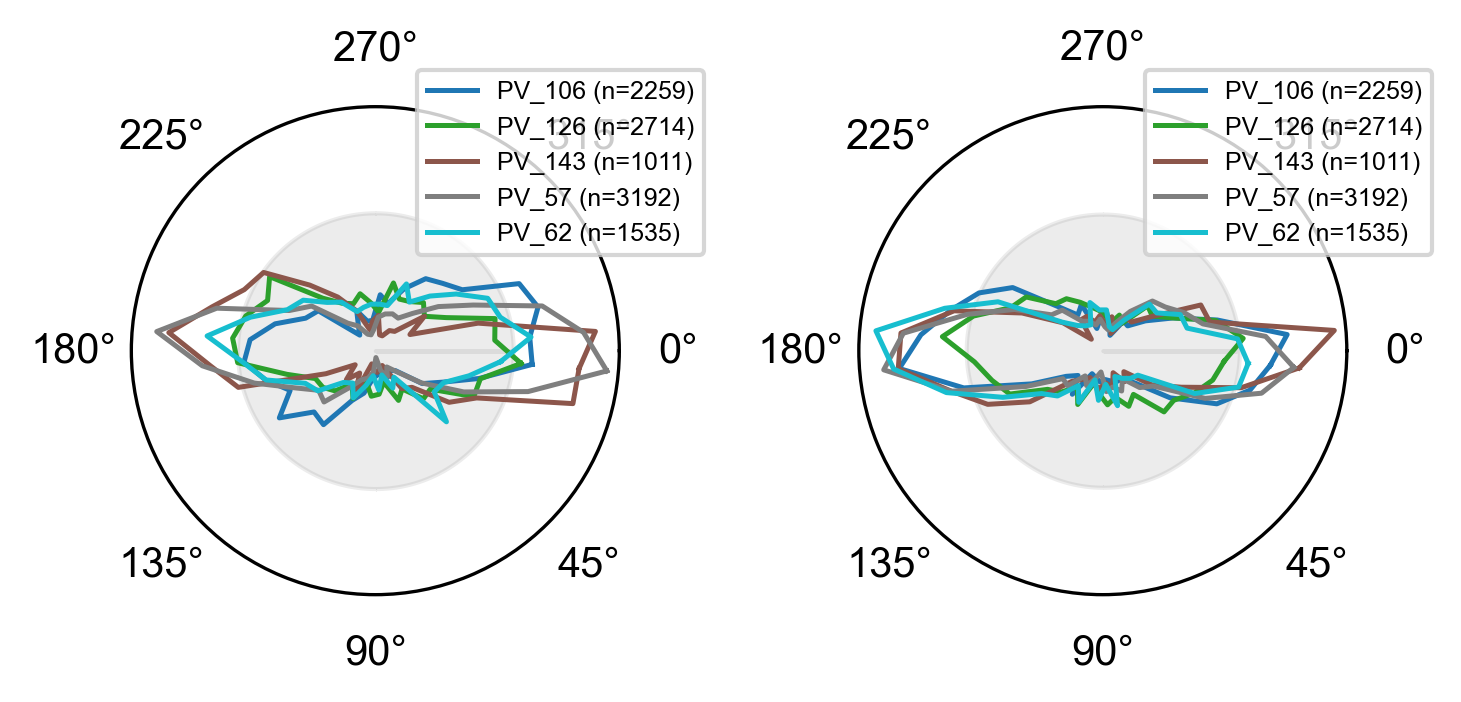

In [29]:
# Compute once (reusable across figures/tools)
rot_dict, rot_df = compute_per_eye_axis_rotation(synced_saccade_collection, num_bins=36)


# Plot with the same rotation_dict to ensure consistency, and get it back if needed
rotation_catalog = create_saccade_polar_histogram_rotated_per_eye_v2(
    synced_saccade_collection,
    figure_size=(5,4),
    export_path=None,
    num_bins=36,
    rotation_dict=rot_dict,
    return_rotation=True
)


In [32]:
import cv2
import numpy as np
from pathlib import Path

def rotation_explorer_from_out(out, block_collection,
                               start_eye='left', start_animal=None,
                               skip_secs=10, show_grid=True):
    """
    Interactive explorer to visualize histogram-derived rotations on raw video frames.

    Args
    ----
    out : dict
        The dictionary returned by your polar-histogram routine. This function will look for
        one of these keys (first that exists is used):
            - 'rotation_catalog_min'   # recommended: minimal-abs rotations (per your update)
            - 'rotation_catalog'       # original rotation catalog
            - 'rotations'              # fallback name
        Each should map (animal, 'L' or 'R') -> rotation_deg (float)
    block_collection : list[BlockSync]
        Blocks with attributes like .animal_call, .le_videos[0], .re_videos[0].
    start_eye : {'left','right'}
    start_animal : str or None
        If provided, the animal id to start with; otherwise first common animal is used.
    skip_secs : int
        How much to jump with << and >>.
    show_grid : bool
        Start with axis grid visible in the frame inset.

    Controls (click in 'Controls' window)
    -------------------------------------
    Play | Pause | Toggle Rot | Pre-VFlip | Grid | < | > | << | >> | Eye | Animal- | Animal+ | Quit

    Keyboard shortcuts (while 'Frame' focused)
    -----------------------------------------
    q/ESC: quit,  n/p: next/prev frame,  f/b: >>/<<,  r: toggle rotation,  v: pre-vertical-flip,
    g: grid,  e: switch eye,  a/d: animal- / animal+
    """

    # ---------- helpers ----------
    def _draw_axis_grid(img, center, radius, rotation_deg=0.0, color=(220,220,220), thickness=1):
        cx, cy = center
        for deg in [0, 90, 180, 270]:
            ang = np.deg2rad((deg + rotation_deg) % 360.0)
            x2 = int(round(cx + radius * np.cos(ang)))
            y2 = int(round(cy - radius * np.sin(ang)))
            cv2.line(img, (cx, cy), (x2, y2), color, thickness, cv2.LINE_AA)
            tx = int(round(cx + (radius+12) * np.cos(ang)))
            ty = int(round(cy - (radius+12) * np.sin(ang)))
            cv2.putText(img, str(deg), (tx-8, ty+4), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, 1, cv2.LINE_AA)

    def _catalog_from_out(out):
        for k in ('rotation_catalog_min', 'rotation_catalog', 'rotations'):
            if k in out and isinstance(out[k], dict):
                return out[k]
        # allow passing the catalog directly
        if isinstance(out, dict) and all(isinstance(k, tuple) and len(k) == 2 for k in out.keys()):
            return out
        raise ValueError("Could not find a rotation catalog in 'out'. "
                         "Expected key 'rotation_catalog_min' or 'rotation_catalog'.")

    def _animal_of(block):
        for attr in ('animal_call', 'animal', 'animal_id', 'name'):
            if hasattr(block, attr):
                return str(getattr(block, attr))
        return None

    def _video_for(block, eye):
        if eye == 'left':
            return str(block.le_videos[0])
        else:
            return str(block.re_videos[0])

    def _rotation_for(animal, eye_letter):
        # try exact, then case-insensitive matches on animal label
        for key in catalog.keys():
            a, e = key
            if str(a) == str(animal) and e.upper() == eye_letter:
                return float(catalog[key])
        # normalize animal label by stripping spaces if needed
        for key in catalog.keys():
            a, e = key
            if str(a).replace(' ','') == str(animal).replace(' ','') and e.upper() == eye_letter:
                return float(catalog[key])
        return None  # not found

    # ---------- build indices ----------
    catalog = _catalog_from_out(out)
    animals_in_out = sorted({k[0] for k in catalog.keys()})

    blocks_by_animal = {}
    for b in block_collection:
        a = _animal_of(b)
        if a:
            blocks_by_animal[a] = b

    # intersect animals that exist in both
    common_animals = [a for a in animals_in_out if a in blocks_by_animal]
    if not common_animals:
        raise ValueError("No overlapping animals between 'out' rotation catalog and block_collection.")

    eye = start_eye.lower()
    assert eye in ('left','right'), "start_eye must be 'left' or 'right'"

    if start_animal and start_animal in common_animals:
        ai = common_animals.index(start_animal)
    else:
        ai = 0

    # ---------- UI state ----------
    apply_rotation = True
    pre_vflip = False
    grid_on = bool(show_grid)
    playing = False
    running = True

    # Controls layout
    buttons = {
        'Play':      ((10, 10),  (190, 60)),
        'Pause':     ((10, 70),  (190, 120)),
        'Toggle Rot':((10, 130), (190, 180)),
        'Pre-VFlip': ((10, 190), (190, 240)),
        'Grid':      ((10, 250), (190, 300)),
        '<':         ((10, 310), (90, 360)),
        '>':         ((110, 310),(190, 360)),
        '<<':        ((10, 370), (90, 420)),
        '>>':        ((110, 370),(190, 420)),
        'Eye':       ((10, 430), (190, 480)),
        'Animal-':   ((10, 490), (90, 540)),
        'Animal+':   ((110, 490),(190, 540)),
        'Quit':      ((10, 550), (190, 600)),
    }
    ctrl_h, ctrl_w = 620, 200

    def draw_controls():
        img = np.zeros((ctrl_h, ctrl_w, 3), dtype=np.uint8)
        for name, ((x1, y1), (x2, y2)) in buttons.items():
            cv2.rectangle(img, (x1, y1), (x2, y2), (60, 60, 60), -1)
            cv2.rectangle(img, (x1, y1), (x2, y2), (210, 210, 210), 2)
            cv2.putText(img, name, (x1+8, y1+35), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (230,230,230), 2, cv2.LINE_AA)
        return img

    controls_img = draw_controls()
    cv2.namedWindow('Controls', cv2.WINDOW_NORMAL)
    cv2.namedWindow('Frame', cv2.WINDOW_NORMAL)

    # video state
    cap = None
    W = H = N = fps = None
    last_frame = None

    def open_cap():
        nonlocal cap, W, H, N, fps, last_frame
        if cap is not None:
            cap.release()
        animal = common_animals[ai]
        block = blocks_by_animal[animal]
        video_path = _video_for(block, eye)
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise RuntimeError(f"Cannot open video: {video_path}")
        W  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        H  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        N  = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
        last_frame = None

    open_cap()

    # mouse handling
    def on_mouse_controls(event, x, y, flags, param):
        nonlocal playing, apply_rotation, pre_vflip, grid_on, eye, ai, last_frame
        if event != cv2.EVENT_LBUTTONDOWN:
            return
        for name, ((x1, y1), (x2, y2)) in buttons.items():
            if x1 <= x <= x2 and y1 <= y <= y2:
                if name == 'Play':
                    playing = True
                elif name == 'Pause':
                    playing = False
                elif name == 'Toggle Rot':
                    apply_rotation = not apply_rotation
                elif name == 'Pre-VFlip':
                    pre_vflip = not pre_vflip
                elif name == 'Grid':
                    grid_on = not grid_on
                elif name == '<':
                    idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 2
                    cap.set(cv2.CAP_PROP_POS_FRAMES, max(idx, 0))
                    last_frame = None
                elif name == '>':
                    # just let loop advance one frame
                    last_frame = None
                elif name == '<<':
                    idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
                    cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, idx - int(skip_secs*fps)))
                    last_frame = None
                elif name == '>>':
                    idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
                    cap.set(cv2.CAP_PROP_POS_FRAMES, min(N-1, idx + int(skip_secs*fps)))
                    last_frame = None
                elif name == 'Eye':
                    eye = 'right' if eye == 'left' else 'left'
                    open_cap()
                elif name == 'Animal-':
                    ai = (ai - 1) % len(common_animals)
                    open_cap()
                elif name == 'Animal+':
                    ai = (ai + 1) % len(common_animals)
                    open_cap()
                elif name == 'Quit':
                    # handled in main loop by setting running False via key
                    pass
                break

    def on_mouse_frame(event, x, y, flags, param):
        # (reserved for future picks; not needed now)
        return

    cv2.setMouseCallback('Controls', on_mouse_controls)
    cv2.setMouseCallback('Frame', on_mouse_frame)

    # -------- main loop --------
    while True:
        if not running:
            break

        if playing or last_frame is None:
            ok, frame = cap.read()
            if not ok:
                break
            last_frame = frame.copy()
        else:
            frame = last_frame.copy()

        animal = common_animals[ai]
        eye_letter = 'L' if eye == 'left' else 'R'
        rot_deg = _rotation_for(animal, eye_letter)

        disp = frame.copy()

        # Optionally vertical-flip before rotation
        if pre_vflip:
            disp = cv2.flip(disp, 0)

        # Apply rotation to the frame if requested (positive angle in OpenCV is CCW)
        if apply_rotation and rot_deg is not None:
            M = cv2.getRotationMatrix2D((W//2, H//2), rot_deg, 1.0)
            disp = cv2.warpAffine(disp, M, (W, H), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)

        # Overlay an axis grid to visualize where 0/90/180/270 lie w.r.t. the current frame
        if grid_on:
            inset_center = (int(W*0.86), int(H*0.86))
            grid_radius  = int(min(H, W)*0.12)
            # draw grid in *unrotated* coordinates for reference
            _draw_axis_grid(disp, inset_center, grid_radius, rotation_deg=0.0, color=(200,200,200), thickness=1)

        # HUD
        txt1 = f"{animal} {eye_letter}  rot_from_out={rot_deg:+.1f}°" if rot_deg is not None else f"{animal} {eye_letter}  rot_from_out=NONE"
        txt2 = f"{'ROT:ON' if apply_rotation else 'ROT:OFF'} | {'VFLIPpre:ON' if pre_vflip else 'VFLIPpre:OFF'} | {'GRID:ON' if grid_on else 'GRID:OFF'}"
        cv2.putText(disp, txt1, (14, 26), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (20,20,20), 3, cv2.LINE_AA)
        cv2.putText(disp, txt1, (14, 26), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (240,240,240), 1, cv2.LINE_AA)
        cv2.putText(disp, txt2, (14, 52), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (20,20,20), 3, cv2.LINE_AA)
        cv2.putText(disp, txt2, (14, 52), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (240,240,240), 1, cv2.LINE_AA)

        cv2.imshow('Frame', disp)
        cv2.imshow('Controls', controls_img)

        key = cv2.waitKey(25) & 0xFF
        if key in (ord('q'), 27):   # q or ESC
            break
        elif key == ord('n') or key == ord('>'):
            last_frame = None
        elif key == ord('p') or key == ord('<'):
            idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 2
            cap.set(cv2.CAP_PROP_POS_FRAMES, max(idx, 0))
            last_frame = None
        elif key == ord('f'):
            idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
            cap.set(cv2.CAP_PROP_POS_FRAMES, min(N-1, idx + int(skip_secs*fps)))
            last_frame = None
        elif key == ord('b'):
            idx = int(cap.get(cv2.CAP_PROP_POS_FRAMES)) - 1
            cap.set(cv2.CAP_PROP_POS_FRAMES, max(0, idx - int(skip_secs*fps)))
            last_frame = None
        elif key == ord('r'):
            apply_rotation = not apply_rotation
        elif key == ord('v'):
            pre_vflip = not pre_vflip
        elif key == ord('g'):
            grid_on = not grid_on
        elif key == ord('e'):
            eye = 'right' if eye == 'left' else 'left'
            open_cap()
        elif key == ord('a'):
            ai = (ai - 1) % len(common_animals); open_cap()
        elif key == ord('d'):
            ai = (ai + 1) % len(common_animals); open_cap()

    if cap is not None:
        cap.release()
    cv2.destroyAllWindows()


In [33]:
rotation_explorer_from_out(out,block_collection)

In [ ]:
# This is currently newest:
import numpy as _np
import pandas as _pd
import matplotlib.pyplot as _plt
import datetime as _dt
import pathlib as _pl
import pickle as _pkl

_OKABE_ITO = ["#0072B2", "#D55E00", "#009E73", "#CC79A7",
              "#F0E442", "#56B4E9", "#E69F00", "#000000"]

def _build_color_map(labels, template="okabeito", custom=None, order=None):
    if order is None:
        order = list(labels)
    if custom is not None:
        base = list(custom)
    elif template == "okabeito":
        base = list(_OKABE_ITO)
    else:
        base = list(_OKABE_ITO)
    return {lab: base[i % len(base)] for i, lab in enumerate(order)}

def _clean_angles_deg(series_like):
    a = _pd.to_numeric(series_like, errors='coerce').to_numpy(dtype='float64')
    a = a[_np.isfinite(a)]
    return _np.mod(a, 360.0)

def _hist_deg(angles_deg, num_bins=36):
    hist, edges = _np.histogram(angles_deg, bins=num_bins, range=(0.0, 360.0), density=True)
    centers = (edges[:-1] + edges[1:]) / 2.0
    return hist, edges, centers

def _preferred_axis_bin(density):
    n = density.size
    opposite = _np.roll(density, n // 2)
    axis_strength = density + opposite
    return int(_np.argmax(axis_strength))

def _wrap_min_abs_180(deg):
    """Map any angle to the equivalent in [-90, 90)."""
    return ((deg + 90.0) % 180.0) - 90.0

def create_saccade_polar_histogram_rotated_per_eye(
    saccade_collection: _pd.DataFrame,
    figure_size=(3.6, 2.2),
    export_path=None,
    plot_name="saccade_angles_histogram_per_eye.pdf",
    num_bins=36,
    baseline_prob=0.005,
    rotate=True,
    font_family="Arial",
    color_template="okabeito",
    custom_colors=None,
    color_map=None,                     # {'PV_62':'#...'}
    line_width=1.5,
    legend_fontsize=7,
    # NEW: persist the analysis objects with the figure
    block_collection=None,
    block_pickle_name="block_collection.pkl"
):
    """
    Plot per-eye (R on left, L on right) saccade angle histograms per animal.
    If `rotate=True`, align dominant axis (bin+opposite) to 0°/180° using the *minimal* absolute rotation
    (angle equivalence modulo 180°, mapped to [-90°, 90°)); else plot raw angles.

    Returns:
        rotation_catalog, used_colors, out_paths, out

        where `out` is a dict with per-(animal,eye) details for later verification.
    """
    # ---- validation ----
    required = {'animal', 'eye', 'overall_angle_deg'}
    missing = required.difference(set(saccade_collection.columns))
    if missing:
        raise ValueError(f"saccade_collection is missing required columns: {missing}")

    animals = _np.array(sorted(saccade_collection['animal'].dropna().unique()))
    if animals.size == 0:
        raise ValueError("No animals found in 'animal' column.")
    valid = saccade_collection.query("eye in ['L','R']").copy()

    # ---- colors ----
    if color_map is None:
        used_colors = _build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
    else:
        fallback = _build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
        used_colors = {a: color_map.get(a, fallback[a]) for a in animals}

    # ---- matplotlib style ----
    _plt.rcParams['font.family'] = 'sans-serif'
    _plt.rcParams['font.sans-serif'] = [font_family]

    fig, axs = _plt.subplots(1, 2, figsize=figure_size, dpi=300, subplot_kw=dict(projection='polar'))
    rotation_catalog = {}
    out = {'per_eye': {}, 'num_bins': int(num_bins)}

    def _process_eye(ax, eye_label):
        for animal in animals:
            df_eye = valid.query('animal == @animal and eye == @eye_label')
            angles_deg = _clean_angles_deg(df_eye['overall_angle_deg'])
            if angles_deg.size == 0:
                rotation_catalog[(animal, eye_label)] = 0.0
                out['per_eye'][(animal, eye_label)] = {
                    'peak_bin': None,
                    'peak_center_deg': None,
                    'rotation_raw_deg': 0.0,
                    'rotation_minabs_deg': 0.0,
                    'equivalents_deg': [0.0, 180.0, -180.0],
                    'n_angles': 0
                }
                continue

            base_density, _, base_centers = _hist_deg(angles_deg, num_bins=num_bins)

            if rotate:
                peak_bin = _preferred_axis_bin(base_density)
                peak_center = float(base_centers[peak_bin])          # center (deg) of dominant axis bin
                rotation_raw = -peak_center                          # aligns that bin to 0°
                rotation_deg = _wrap_min_abs_180(rotation_raw)       # choose minimal-abs equivalent
            else:
                peak_bin = None
                peak_center = None
                rotation_raw = 0.0
                rotation_deg = 0.0

            rotation_catalog[(animal, eye_label)] = rotation_deg

            # save per-eye details for verification later
            out['per_eye'][(animal, eye_label)] = {
                'peak_bin': None if peak_bin is None else int(peak_bin),
                'peak_center_deg': peak_center,
                'rotation_raw_deg': rotation_raw,
                'rotation_minabs_deg': rotation_deg,
                'equivalents_deg': [rotation_raw,
                                    rotation_raw + 180.0,
                                    rotation_raw - 180.0],
                'n_angles': int(angles_deg.size)
            }

            rotated_angles = _np.mod(angles_deg + rotation_deg, 360.0)
            density, _, centers = _hist_deg(rotated_angles, num_bins=num_bins)

            theta = _np.deg2rad(_np.r_[centers, centers[0]])
            rho   = _np.r_[density, density[0]]

            ax.plot(theta, rho, lw=line_width, color=used_colors[animal],
                    label=f"{animal} (n={len(angles_deg)})")

        # baseline ring + aesthetics
        theta_ring = _np.linspace(0, 2*_np.pi, 512)
        ax.fill_between(theta_ring, 0, baseline_prob, alpha=0.15, color='gray', zorder=0)
        ax.set_yticks([])
        ax.grid(False)
        ax.set_theta_zero_location('E')
        ax.set_theta_direction(-1)
        # legend exported separately

    # R-eye on left, L-eye on right
    _process_eye(axs[0], 'R')
    _process_eye(axs[1], 'L')

    axs[0].set_title(f"Right eye ({'rotated' if rotate else 'raw'})", fontsize=8, pad=8)
    axs[1].set_title(f"Left eye ({'rotated' if rotate else 'raw'})", fontsize=8, pad=8)

    _plt.tight_layout()

    out_paths = {}
    # ---- export main + separate legend + rotation catalog + block_collection ----
    if export_path:
        ts = _dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        outdir = _pl.Path(export_path) / f"{ts}_Saccade_Hist_PerEye"
        outdir.mkdir(parents=True, exist_ok=True)

        # main figure
        pdf_path = outdir / plot_name
        _plt.savefig(pdf_path, bbox_inches='tight', dpi=300)
        out_paths['figure_pdf'] = str(pdf_path)

        # separate legend (one entry per animal)
        from matplotlib.lines import Line2D
        handles = [Line2D([0], [0], color=used_colors[a], lw=line_width, label=str(a)) for a in animals]
        fig_leg = _plt.figure(figsize=(2.0, 0.28*max(1,len(handles)) + 0.4), dpi=300)
        fig_leg.legend(handles, [h.get_label() for h in handles],
                       loc='center', frameon=False, ncol=1, prop={'size': legend_fontsize})
        legend_pdf_path = outdir / f"legend_{plot_name}"
        fig_leg.savefig(legend_pdf_path, bbox_inches='tight', dpi=300)
        _plt.close(fig_leg)
        out_paths['legend_pdf'] = str(legend_pdf_path)

        # rotation catalog pkl (now with min-abs rotations)
        rot_path = outdir / f"{ts}_per_eye_rotation_catalog.pkl"
        with open(rot_path, 'wb') as f:
            _pkl.dump(rotation_catalog, f, protocol=_pkl.HIGHEST_PROTOCOL)
        out_paths['rotation_pkl'] = str(rot_path)

        # OPTIONAL: persist the exact block_collection used for this export
        if block_collection is not None:
            bc_path = outdir / block_pickle_name
            try:
                try:
                    import cloudpickle as _cpkl
                    with open(bc_path, 'wb') as f:
                        _cpkl.dump(block_collection, f)
                except Exception:
                    with open(bc_path, 'wb') as f:
                        _pkl.dump(block_collection, f, protocol=_pkl.HIGHEST_PROTOCOL)
                out_paths['block_collection_pkl'] = str(bc_path)
                with open(outdir / "export_metadata.txt", 'w', encoding='utf-8') as f:
                    f.write(f"rotate={rotate}\nnum_bins={num_bins}\nbaseline_prob={baseline_prob}\n")
                    f.write(f"line_width={line_width}\nanimals={list(animals)}\n")
                    f.write(f"figure_pdf={pdf_path.name}\nlegend_pdf={legend_pdf_path.name}\n")
                    f.write(f"rotation_pkl={rot_path.name}\nblock_collection_pkl={bc_path.name}\n")
            except Exception as e:
                print(f"[WARN] Failed to pickle block_collection: {e}")

        print("Exported figure to:", pdf_path)
        print("Exported legend to:", legend_pdf_path)
        print("Saved rotation catalog to:", rot_path)
        if 'block_collection_pkl' in out_paths:
            print("Saved block collection to:", out_paths['block_collection_pkl'])

    _plt.show()
    return rotation_catalog, used_colors, out_paths, out


In [ ]:
# rotated version, corrected colors:
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees'
create_saccade_polar_histogram_rotated_per_eye(synced_saccade_collection, (5,4),export_path=None,rotate=True,block_collection=block_collection)

In [ ]:
# This previous working version
import numpy as _np
import pandas as _pd
import matplotlib.pyplot as _plt
import datetime as _dt
import pathlib as _pl
import pickle as _pkl

# --- minimal color utilities (or pass your own color_map) ---
_OKABE_ITO = ["#0072B2", "#D55E00", "#009E73", "#CC79A7",
              "#F0E442", "#56B4E9", "#E69F00", "#000000"]

def _build_color_map(labels, template="okabeito", custom=None, order=None):
    if order is None:
        order = list(labels)
    if custom is not None:
        base = list(custom)
    elif template == "okabeito":
        base = list(_OKABE_ITO)
    else:
        base = list(_OKABE_ITO)
    return {lab: base[i % len(base)] for i, lab in enumerate(order)}

# --- helpers ---
def _clean_angles_deg(series_like):
    a = _pd.to_numeric(series_like, errors='coerce').to_numpy(dtype='float64')
    a = a[_np.isfinite(a)]
    return _np.mod(a, 360.0)

def _hist_deg(angles_deg, num_bins=36):
    hist, edges = _np.histogram(angles_deg, bins=num_bins, range=(0.0, 360.0), density=True)
    centers = (edges[:-1] + edges[1:]) / 2.0
    return hist, edges, centers

def _preferred_axis_bin(density):
    n = density.size
    opposite = _np.roll(density, n // 2)
    axis_strength = density + opposite
    return int(_np.argmax(axis_strength))

def create_saccade_polar_histogram_rotated_per_eye(
    saccade_collection: _pd.DataFrame,
    figure_size=(3.6, 2.2),             # compact default
    export_path=None,
    plot_name="saccade_angles_histogram_per_eye.pdf",
    num_bins=36,
    baseline_prob=0.005,
    rotate=True,
    font_family="Arial",
    color_template="okabeito",
    custom_colors=None,
    color_map=None,                     # {'PV_62':'#...'}
    line_width=1.5,
    legend_fontsize=7,
    # NEW: persist the analysis objects with the figure
    block_collection=None,
    block_pickle_name="block_collection.pkl"
):
    """
    Plot per-eye (R on left, L on right) saccade angle histograms per animal.
    If `rotate=True`, align dominant axis (bin+opposite) to 0°/180°; else plot raw angles.
    Exports: main PDF, separate legend PDF, rotation catalog .pkl, and (optionally) block_collection .pkl.
    """
    # ---- validation ----
    required = {'animal', 'eye', 'overall_angle_deg'}
    missing = required.difference(set(saccade_collection.columns))
    if missing:
        raise ValueError(f"saccade_collection is missing required columns: {missing}")

    animals = _np.array(sorted(saccade_collection['animal'].dropna().unique()))
    if animals.size == 0:
        raise ValueError("No animals found in 'animal' column.")
    valid = saccade_collection.query("eye in ['L','R']").copy()

    # ---- colors ----
    if color_map is None:
        used_colors = _build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
    else:
        fallback = _build_color_map(animals, template=color_template, custom=custom_colors, order=animals)
        used_colors = {a: color_map.get(a, fallback[a]) for a in animals}

    # ---- matplotlib style ----
    _plt.rcParams['font.family'] = 'sans-serif'
    _plt.rcParams['font.sans-serif'] = [font_family]

    fig, axs = _plt.subplots(1, 2, figsize=figure_size, dpi=300, subplot_kw=dict(projection='polar'))
    rotation_catalog = {}

    def _process_eye(ax, eye_label):
        for animal in animals:
            df_eye = valid.query('animal == @animal and eye == @eye_label')
            angles_deg = _clean_angles_deg(df_eye['overall_angle_deg'])
            if angles_deg.size == 0:
                rotation_catalog[(animal, eye_label)] = 0.0
                continue

            base_density, _, base_centers = _hist_deg(angles_deg, num_bins=num_bins)

            if rotate:
                peak_bin = _preferred_axis_bin(base_density)
                peak_center = base_centers[peak_bin]
                rotation_deg = -float(peak_center)
            else:
                rotation_deg = 0.0

            rotation_catalog[(animal, eye_label)] = rotation_deg

            rotated_angles = _np.mod(angles_deg + rotation_deg, 360.0)
            density, _, centers = _hist_deg(rotated_angles, num_bins=num_bins)

            theta = _np.deg2rad(_np.r_[centers, centers[0]])
            rho   = _np.r_[density, density[0]]

            ax.plot(theta, rho, lw=line_width, color=used_colors[animal],
                    label=f"{animal} (n={len(angles_deg)})")

        # baseline ring + aesthetics
        theta_ring = _np.linspace(0, 2*_np.pi, 512)
        ax.fill_between(theta_ring, 0, baseline_prob, alpha=0.15, color='gray', zorder=0)
        ax.set_yticks([])
        ax.grid(False)
        ax.set_theta_zero_location('E')
        ax.set_theta_direction(-1)
        # legend exported separately

    # R-eye on left, L-eye on right
    _process_eye(axs[0], 'R')
    _process_eye(axs[1], 'L')

    axs[0].set_title(f"Right eye ({'rotated' if rotate else 'raw'})", fontsize=8, pad=8)
    axs[1].set_title(f"Left eye ({'rotated' if rotate else 'raw'})", fontsize=8, pad=8)

    _plt.tight_layout()

    out_paths = {}
    # ---- export main + separate legend + rotation catalog + block_collection ----
    if export_path:
        ts = _dt.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        outdir = _pl.Path(export_path) / f"{ts}_Saccade_Hist_PerEye"
        outdir.mkdir(parents=True, exist_ok=True)

        # main figure
        pdf_path = outdir / plot_name
        _plt.savefig(pdf_path, bbox_inches='tight', dpi=300)
        out_paths['figure_pdf'] = str(pdf_path)

        # separate legend (one entry per animal)
        from matplotlib.lines import Line2D
        handles = [Line2D([0], [0], color=used_colors[a], lw=line_width, label=str(a)) for a in animals]
        fig_leg = _plt.figure(figsize=(2.0, 0.28*max(1,len(handles)) + 0.4), dpi=300)
        fig_leg.legend(handles, [h.get_label() for h in handles],
                       loc='center', frameon=False, ncol=1, prop={'size': legend_fontsize})
        legend_pdf_path = outdir / f"legend_{plot_name}"
        fig_leg.savefig(legend_pdf_path, bbox_inches='tight', dpi=300)
        _plt.close(fig_leg)
        out_paths['legend_pdf'] = str(legend_pdf_path)

        # rotation catalog
        rot_path = outdir / f"{ts}_per_eye_rotation_catalog.pkl"
        with open(rot_path, 'wb') as f:
            _pkl.dump(rotation_catalog, f, protocol=_pkl.HIGHEST_PROTOCOL)
        out_paths['rotation_pkl'] = str(rot_path)

        # OPTIONAL: persist the exact block_collection used for this export
        if block_collection is not None:
            bc_path = outdir / block_pickle_name
            try:
                try:
                    import cloudpickle as _cpkl  # safer for complex classes
                    with open(bc_path, 'wb') as f:
                        _cpkl.dump(block_collection, f)
                except Exception:
                    with open(bc_path, 'wb') as f:
                        _pkl.dump(block_collection, f, protocol=_pkl.HIGHEST_PROTOCOL)
                out_paths['block_collection_pkl'] = str(bc_path)
                # small metadata note for reproducibility
                with open(outdir / "export_metadata.txt", 'w', encoding='utf-8') as f:
                    f.write(f"rotate={rotate}\nnum_bins={num_bins}\nbaseline_prob={baseline_prob}\n")
                    f.write(f"line_width={line_width}\nanimals={list(animals)}\n")
                    f.write(f"figure_pdf={pdf_path.name}\nlegend_pdf={legend_pdf_path.name}\n")
                    f.write(f"rotation_pkl={rot_path.name}\nblock_collection_pkl={bc_path.name}\n")
            except Exception as e:
                print(f"[WARN] Failed to pickle block_collection: {e}")

        print("Exported figure to:", pdf_path)
        print("Exported legend to:", legend_pdf_path)
        print("Saved rotation catalog to:", rot_path)
        if 'block_collection_pkl' in out_paths:
            print("Saved block collection to:", out_paths['block_collection_pkl'])

    _plt.show()
    return rotation_catalog, used_colors, out_paths


In [ ]:
# rotated version, corrected colors:
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees'
create_saccade_polar_histogram_rotated_per_eye(synced_saccade_collection, (5,4),export_path=export_path,rotate=True,block_collection=block_collection)

In [ ]:
# rotated version, non synced corrected colors:
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\non_synced_saccade_polar_multi_animal_degrees'
create_saccade_polar_histogram_rotated_per_eye(non_synced_saccade_collection, (5,4),export_path=export_path)

In [ ]:
import pathlib as _pl
import datetime as _dt
import numpy as _np
import pandas as _pd
import matplotlib.pyplot as _plt
import pickle as _pkl

def _clean_angles_deg(series_like):
    """Return float64 angles in [0, 360) with non-finite removed."""
    a = _pd.to_numeric(series_like, errors='coerce').to_numpy(dtype='float64')
    a = a[_np.isfinite(a)]
    return _np.mod(a, 360.0)

def _hist_deg(angles_deg, num_bins=36):
    """Histogram (density) over [0, 360)."""
    hist, edges = _np.histogram(angles_deg, bins=num_bins, range=(0.0, 360.0), density=True)
    centers = (edges[:-1] + edges[1:]) / 2.0
    return hist, edges, centers

def _preferred_axis_bin(density):
    """
    Axis preference: pick bin maximizing (bin + opposite bin).
    Works best with even num_bins (default 36).
    """
    n = density.size
    opposite = _np.roll(density, n // 2)
    axis_strength = density + opposite
    return int(_np.argmax(axis_strength))

def _wrap180(deg):
    """Wrap degrees to (-180, 180]."""
    return (deg + 180.0) % 360.0 - 180.0

def create_saccade_polar_histogram_rotated_per_eye(
    saccade_collection: _pd.DataFrame,
    figure_size=(5, 4),
    export_path=None,
    num_bins=36,
    baseline_prob=0.005,
    cmap='tab10',
    save_pickle=True,
    max_rotation_abs_deg=70.0  # <-- constrain rotation to ±70°
):
    """
    For each (animal, eye), find the dominant *axis* (bin + opposite), compute the rotation that would align
    that axis to 0°/180°, then APPLY a version of that rotation constrained to ±max_rotation_abs_deg
    (to preserve medial/temporal meaning). Plots polar histograms and saves rotations.

    Saves when export_path is provided:
      - PDF figure
      - CSV with columns: animal, eye, desired_rotation_deg, applied_rotation_deg, clipped (bool)
      - (optional) PKL of {(animal, eye): applied_rotation_deg}

    Returns
    -------
    rotations_applied : dict  {(animal, eye): applied_rotation_deg}
    """
    required = {'animal', 'eye', 'overall_angle_deg'}
    missing = required.difference(saccade_collection.columns)
    if missing:
        raise ValueError(f"Input is missing required columns: {missing}")

    if num_bins % 2 != 0:
        raise ValueError("num_bins should be even so opposite bins align (e.g., 36).")

    animals = _np.array(sorted(saccade_collection['animal'].dropna().unique()))
    if animals.size == 0:
        raise ValueError("No animals found.")

    # Colors
    try:
        cm = _plt.get_cmap(cmap)
        colors = [cm(i / max(1, len(animals)-1)) for i in range(len(animals))]
    except Exception:
        colors = _plt.cm.tab10(_np.linspace(0, 1, max(10, len(animals))))[:len(animals)]

    fig, axs = _plt.subplots(1, 2, figsize=figure_size, dpi=300,
                             subplot_kw=dict(projection='polar'))

    rotations_desired = {}   # {(animal, eye): desired_rotation_deg}
    rotations_applied = {}   # {(animal, eye): applied_rotation_deg}
    was_clipped = {}         # {(animal, eye): bool}

    def _compute_constrained_rotation(peak_center_deg):
        """
        Desired rotations to align the axis peak to 0° or 180°:
          r0    = wrap180(-peak_center)
          r180  = wrap180(180 - peak_center)
        Choose the one with smaller |r|, then clip to ±max_rotation_abs_deg.
        """
        r0 = _wrap180(-peak_center_deg)
        r180 = _wrap180(180.0 - peak_center_deg)
        desired = r0 if abs(r0) <= abs(r180) else r180
        applied = float(_np.clip(desired, -max_rotation_abs_deg, max_rotation_abs_deg))
        clipped = not _np.isclose(applied, desired)
        return desired, applied, clipped

    def _process_eye(ax, eye_label):
        for color, animal in zip(colors, animals):
            df_eye = saccade_collection.query('animal == @animal and eye == @eye_label')
            if df_eye.empty:
                continue

            angles_deg = _clean_angles_deg(df_eye['overall_angle_deg'])
            if angles_deg.size == 0:
                continue

            # Base histogram & preferred axis
            base_density, _, base_centers = _hist_deg(angles_deg, num_bins=num_bins)
            if base_density.sum() == 0:
                continue

            peak_bin = _preferred_axis_bin(base_density)
            peak_center = float(base_centers[peak_bin])  # degrees

            # Desired vs applied (constrained) rotation
            desired_rot, applied_rot, clipped = _compute_constrained_rotation(peak_center)
            rotations_desired[(animal, eye_label)] = desired_rot
            rotations_applied[(animal, eye_label)] = applied_rot
            was_clipped[(animal, eye_label)] = clipped

            # Apply constrained rotation and re-histogram
            rot_angles = _np.mod(angles_deg + applied_rot, 360.0)
            density, _, centers = _hist_deg(rot_angles, num_bins=num_bins)

            # Close polar loop; manual deg->rad
            theta = _np.asarray(_np.r_[centers, centers[0]], dtype=float) * (_np.pi / 180.0)
            rho   = _np.r_[density, density[0]]

            ax.plot(theta, rho, lw=1.2, color=color, label=f"{animal} (n={angles_deg.size})")

        # Baseline ring
        t = _np.linspace(0, 2*_np.pi, 512)
        ax.fill_between(t, 0.0, baseline_prob, alpha=0.15, color='gray', zorder=0)

        # Cosmetics
        ax.set_yticks([])
        ax.grid(False)
        ax.set_theta_zero_location('E')  # 0° to the right
        ax.set_theta_direction(-1)       # clockwise
        ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=6)

    # Right eye (left subplot), Left eye (right subplot)
    _process_eye(axs[0], 'R')
    _process_eye(axs[1], 'L')

    axs[0].set_title('Right Eye (axis-aligned, constrained)', fontsize=10)
    axs[1].set_title('Left Eye (axis-aligned, constrained)',  fontsize=10)
    _plt.tight_layout()

    # Export block
    outdir = None
    if export_path:
        ts = _dt.datetime.now().strftime("%Y_%m_%d_%H_%M")
        outdir = _pl.Path(export_path) / f"{ts}_Rotated_Saccade_Histogram_PerEye_constrained"
        outdir.mkdir(parents=True, exist_ok=True)

        pdf_path = outdir / f"{ts}_saccade_angles_histogram_rotated_pereye_constrained.pdf"
        _plt.savefig(pdf_path)
        print("Saved figure:", pdf_path)

        # CSV of desired/applied rotations
        rows = []
        for (a, e) in sorted(rotations_applied.keys()):
            rows.append({
                'animal': a,
                'eye': e,
                'desired_rotation_deg': rotations_desired.get((a, e), _np.nan),
                'applied_rotation_deg': rotations_applied[(a, e)],
                'clipped': was_clipped[(a, e)],
                'max_rotation_abs_deg': max_rotation_abs_deg
            })
        rot_df = _pd.DataFrame(rows, columns=[
            'animal','eye','desired_rotation_deg','applied_rotation_deg','clipped','max_rotation_abs_deg'
        ])
        csv_path = outdir / f"{ts}_per_eye_rotations_constrained.csv"
        rot_df.to_csv(csv_path, index=False)
        print("Saved rotations CSV:", csv_path)

        if save_pickle:
            pkl_path = outdir / f"{ts}_per_eye_rotation_catalog_constrained.pkl"
            with open(pkl_path, 'wb') as f:
                _pkl.dump(rotations_applied, f)
            print("Saved rotations PKL:", pkl_path)

        # Print the table
        print("\nPer-eye rotation angles (deg):")
        print(rot_df.to_string(index=False))

    _plt.show()

    # If no export_path, still print concise mapping
    if not export_path:
        print(f"Per-eye rotation angles (deg), constrained to ±{max_rotation_abs_deg:.1f}°:")
        for (a, e), r_app in sorted(rotations_applied.items()):
            r_des = rotations_desired[(a, e)]
            clip = was_clipped[(a, e)]
            flag = " (clipped)" if clip else ""
            print(f"  {a} {e}: applied={r_app:.3f}, desired={r_des:.3f}{flag}")

    return rotations_applied


In [ ]:
create_saccade_polar_histogram_rotated_per_eye(synced_saccade_collection, (5,4),export_path=export_path)

In [ ]:
# RAW, new_animals 2025_08_14 maybe final thr = 0.6
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees'
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=export_path)

In [ ]:
# tearducts corrected, new_animals 2025_08_14 maybe final thr = 0.6
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees'
create_saccade_polar_histogram_multianimal(synced_saccade_collection.query('animal != "PV_57" and animal != "PV_62"'), (5,4),export_path=None)

In [ ]:
# tearducts corrected, new_animals
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees'
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

In [ ]:
# tearducts corrected, degree based, thr=2
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees'
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

In [ ]:
# 3D corrected, degree based, thr=2
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees'
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

In [ ]:
# thr=0.6 deg/frame
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees'
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

In [ ]:
# 3D corrected, degree based, thr=1
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees'
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

In [ ]:
# raw verified degrees-based
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal_degrees'
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=export_path)

In [ ]:
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal'

create_saccade_polar_histogram_multianimal(synced_saccade_collection.query('not (animal=="PV_62" and block=="023")'), (5,4),export_path=export_path)

In [ ]:
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\non_synced_saccade_polar_multi_animal'
create_saccade_polar_histogram_multianimal(non_synced_saccade_collection.query('not (animal=="PV_62" and block=="023")'), (5,4),export_path=export_path)

In [ ]:
create_saccade_polar_histogram(synced_saccade_collection.query('not (animal=="PV_62" and block=="023")', (4,3),export_path=None)

In [ ]:
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

In [ ]:
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

In [ ]:
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

In [ ]:

create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

In [ ]:
create_saccade_polar_histogram_multianimal(synced_saccade_collection, (5,4),export_path=None)

In [ ]:
def create_saccade_polar_histogram_blockwise_per_animal(saccade_collection,
                                                         figure_size_per_block=(6, 2.5),
                                                         export_path=None):
    import matplotlib.pyplot as plt
    import numpy as np
    import pathlib
    import datetime

    num_bins = 36
    animals = saccade_collection['animal'].unique()

    for animal in animals:
        df_animal = saccade_collection.query('animal == @animal')
        blocks = sorted(df_animal['block'].unique())
        n_blocks = len(blocks)

        fig_height = figure_size_per_block[1] * n_blocks
        fig, axs = plt.subplots(n_blocks, 2,
                                figsize=(figure_size_per_block[0], fig_height),
                                dpi=150,
                                subplot_kw=dict(projection='polar'),
                                constrained_layout=True)

        fig.suptitle(f"Animal: {animal}", fontsize=14, y=1.01)

        for block_idx, block in enumerate(blocks):
            df_block = df_animal.query('block == @block')

            # Assign: Left eye to RIGHT plot, Right eye to LEFT plot
            eye_map = {'R': 0, 'L': 1}

            for eye, col_idx in eye_map.items():
                ax = axs[block_idx][col_idx]
                angles = df_block.query('eye == @eye')['overall_angle_deg']

                hist, edges = np.histogram(angles,
                                           bins=num_bins,
                                           range=(0, 360),
                                           density=True)

                centers = (edges[:-1] + edges[1:]) / 2.0
                theta = centers * (np.pi / 180.0)

                theta = np.concatenate([theta, theta[:1]])
                hist = np.concatenate([hist, hist[:1]])

                ax.plot(theta, hist,
                        color='tab:orange' if eye == 'R' else 'tab:blue',
                        label=f"{eye} eye ({len(angles)} saccades)")
                ax.set_title(f"Block {block} - {eye} eye", fontsize=8, pad=20)
                ax.set_yticks([])
                ax.grid(False)
                ax.fill_between(np.linspace(0, 2*np.pi, 500), 0, 0.005,
                                color='gray', alpha=0.2, zorder=0)
                ax.legend(loc='upper right', fontsize=6)

        if export_path:
            ts = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
            outdir = pathlib.Path(export_path)
            outdir.mkdir(parents=True, exist_ok=True)

            pdf_path = outdir / f"{ts}_{animal}_Blockwise_Saccade_Histogram.pdf"
            plt.savefig(pdf_path, bbox_inches='tight')
            print(f"Exported: {pdf_path}")
        plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pathlib
import tqdm
import pickle
import datetime
import pandas as pd  # Assuming pandas is imported as well

def plot_right_vs_left_eye_hist2d(all_saccade_collection, block_dict, export_path=None,
                                  iqr_multiplier=1.5, bins=100, sync_diff_threshold=31, value_range=(0,2)):
    """
    Plots a 2D probability histogram (normalized so that the sum of all bins is 1) where the x-axis
    represents the right eye's max speed and the y-axis represents the left eye's max speed.
    Uses a custom colormap based on 'turbo' (with only the 0 value set to white) and applies a robust
    exclusion rule so that saccades that are within sync_diff_threshold of a previously processed saccade
    (for the same animal and block) are excluded.

    The axes are kept equal and the colorbar is saved to a separate PDF.

    Parameters:
        all_saccade_collection (pd.DataFrame): DataFrame containing detected saccades.
        block_dict (dict): Dictionary mapping block keys to block objects with eye data.
        export_path (str or pathlib.Path, optional): Path to save the plot and colorbar PDFs.
        iqr_multiplier (float): Multiplier for the interquartile range (IQR) in outlier detection.
        bins (int): Number of bins to use for both x and y directions in the histogram.
        sync_diff_threshold (float): Time difference threshold to consider saccades synchronized
                                       (in the same units as 'saccade_on_ms').
    """
    right_eye_speeds = []
    left_eye_speeds = []

    # Dictionary to track processed saccades for each (animal, block).
    # Keys are (animal, block) and values are lists of saccade timestamps already used.
    processed_events = {}

    # Loop through each saccade entry.
    for _, row in tqdm.tqdm(all_saccade_collection.iterrows()):
        key = (row['animal'], row['block'])
        current_timestamp = row['saccade_on_ms']

        # Check if a saccade for this (animal, block) has already been processed
        # within sync_diff_threshold.
        if key in processed_events:
            if any(abs(current_timestamp - ts) < sync_diff_threshold for ts in processed_events[key]):
                continue  # Skip as this saccade is considered synchronized with a previous one.
            else:
                processed_events[key].append(current_timestamp)
        else:
            processed_events[key] = [current_timestamp]

        block_key = f"{row['animal']}_block_{row['block']}"
        if block_key not in block_dict:
            continue

        block = block_dict[block_key]

        # Get contralateral eye's data based on which eye was detected.
        if row['eye'] == 'L':
            contralateral_eye_speed_profile = block.right_eye_data.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        elif row['eye'] == 'R':
            contralateral_eye_speed_profile = block.left_eye_data.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        else:
            continue

        # Compute the maximum speeds (scaling as in the original function)
        max_detected = np.nanmax(row['speed_profile_angular'] / 17) if len(row['speed_profile_angular']) > 0 else np.nan
        max_contralateral = (np.nanmax(contralateral_eye_speed_profile.values / 17)
                             if contralateral_eye_speed_profile.notna().sum() > 0 else np.nan)

        # Append valid pairs.
        if not np.isnan(max_detected) and not np.isnan(max_contralateral):
            if row['eye'] == 'L':
                left_eye_speeds.append(max_detected)
                right_eye_speeds.append(max_contralateral)
            elif row['eye'] == 'R':
                right_eye_speeds.append(max_detected)
                left_eye_speeds.append(max_contralateral)

    # Convert lists to NumPy arrays.
    right_eye_speeds = np.array(right_eye_speeds)
    left_eye_speeds = np.array(left_eye_speeds)
    print("Number of data points:", len(right_eye_speeds))

    # Outlier removal using IQR on the combined speeds.
    all_speeds = np.concatenate([right_eye_speeds, left_eye_speeds])
    q1, q3 = np.percentile(all_speeds, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    valid_indices = ((right_eye_speeds >= lower_bound) & (right_eye_speeds <= upper_bound) &
                     (left_eye_speeds >= lower_bound) & (left_eye_speeds <= upper_bound))
    right_eye_speeds = right_eye_speeds[valid_indices]
    left_eye_speeds = left_eye_speeds[valid_indices]

    # Fixed axis limits.
    min_value = value_range[0]
    max_value = value_range[1]

    # Create the custom turbo colormap: get a discrete version of turbo and replace the first color with white.
    n_colors = 256
    turbo = plt.get_cmap('turbo', n_colors)
    turbo_colors = turbo(np.linspace(0, 1, n_colors))
    turbo_colors[0] = np.array([1, 1, 1, 1])  # Set the lowest count (0 probability) to perfect white.
    custom_turbo = mcolors.ListedColormap(turbo_colors)

    # Prepare the figure for the histogram.
    fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
    xbins = np.linspace(min_value, max_value, bins)
    ybins = np.linspace(min_value, max_value, bins)

    # Compute the 2D histogram manually.
    counts, xedges, yedges = np.histogram2d(right_eye_speeds, left_eye_speeds, bins=[xbins, ybins])
    normalized_counts = counts / counts.sum()  # Normalize so that the overall sum equals 1.

    # Plot the normalized histogram using pcolormesh.
    pc = ax.pcolormesh(xedges, yedges, normalized_counts.T, cmap=custom_turbo,
                         vmin=0, vmax=normalized_counts.max())

    # Ensure equal axes.
    ax.set_aspect('equal', 'box')
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)

    # Add a diagonal reference line.
    ax.plot([min_value, max_value], [min_value, max_value], linestyle='--', color='gray', linewidth=1)

    # Set axis labels.
    ax.set_xlabel("Right max V [deg/ms]", fontsize=10)
    ax.set_ylabel("Left max V [deg/ms]", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)
    plt.tight_layout()

    # Save the histogram plot if export_path is provided.
    if export_path:
        export_dir = pathlib.Path(export_path)
        export_dir.mkdir(parents=True, exist_ok=True)
        hist_pdf_path = export_dir / "right_vs_left_hist2d.pdf"
        fig.savefig(hist_pdf_path, format='pdf', bbox_inches='tight')
        print(f"2D histogram saved to {hist_pdf_path}")

    # Create a separate figure for the colorbar.
    vmin_val = 0
    vmax_val = normalized_counts.max()
    sm = plt.cm.ScalarMappable(cmap=custom_turbo, norm=plt.Normalize(vmin=vmin_val, vmax=vmax_val))
    sm.set_array([])
    fig2 = plt.figure(figsize=(1, 3), dpi=150)
    cbar = fig2.colorbar(sm, orientation='vertical')
    cbar.set_label("Probability", fontsize=8)
    cbar.ax.tick_params(labelsize=8)
    plt.tight_layout()

    # Save the colorbar to a separate PDF if export_path is provided.
    if export_path:
        cbar_pdf_path = export_dir / "right_vs_left_colorbar.pdf"
        fig2.savefig(cbar_pdf_path, format='pdf', bbox_inches='tight')
        print(f"Colorbar saved to {cbar_pdf_path}")

    plt.show()

# Example usage:
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\{t}'
plot_right_vs_left_eye_hist2d(all_saccade_collection, block_dict, export_path=None, iqr_multiplier=200, bins=200,value_range=(0,2))


In [ ]:
# Example usage:
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\{t}'
plot_right_vs_left_eye_hist2d(all_saccade_collection, block_dict, export_path=None, iqr_multiplier=200, bins=200,value_range=(0,2))

In [ ]:
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\{t}'
plot_right_vs_left_eye_hist2d(all_saccade_collection, block_dict, export_path=None, iqr_multiplier=200, bins=200,value_range=(0,0.1))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy.stats import zscore

def plot_eye_motion_span_cartesian(block_collection, export_path=None, z_thresh=3.5):
    """
    For each animal, compute the range of motion (span) of the eye
    using convex hull boundaries in (k_phi, k_theta) Cartesian space.
    Show both the full and trimmed versions (zscore-based outlier removal).

    Parameters
    ----------
    block_collection : list of BlockSync
        Collection of blocks with .left_eye_data / .right_eye_data DataFrames
        that contain 'k_phi' and 'k_theta'.
    export_path : str or pathlib.Path, optional
        If provided, saves the plot to this location.
    z_thresh : float
        Threshold for z-score trimming (default 3.5).
    """

    animal_data = {}

    # --- Collect data per animal ---
    for block in block_collection:
        phi_l, theta_l = block.left_eye_data['k_phi'].values, block.left_eye_data['k_theta'].values
        phi_r, theta_r = block.right_eye_data['k_phi'].values, block.right_eye_data['k_theta'].values

        data = np.vstack([np.concatenate([phi_l, phi_r]),
                          np.concatenate([theta_l, theta_r])]).T

        if block.animal_call not in animal_data:
            animal_data[block.animal_call] = []
        animal_data[block.animal_call].append(data)

    # concatenate across blocks
    for animal in animal_data:
        animal_data[animal] = np.vstack(animal_data[animal])

    # --- Plotting ---
    fig, ax = plt.subplots(figsize=(6, 6))

    for animal, data in animal_data.items():
        # Remove NaNs
        data = data[~np.isnan(data).any(axis=1)]

        phi = data[:,0]
        theta = data[:,1]

        # ---- Full span convex hull ----
        if len(data) > 3:
            hull_full = ConvexHull(data)
            hull_pts_full = data[hull_full.vertices]
            ax.plot(hull_pts_full[:,0], hull_pts_full[:,1],
                    alpha=0.3, label=f"{animal} (all)")

        # ---- Trimmed span ----
        z = np.abs(zscore(data, nan_policy='omit'))
        keep = (z < z_thresh).all(axis=1)
        data_trim = data[keep]
        if len(data_trim) > 3:
            hull_trim = ConvexHull(data_trim)
            hull_pts_trim = data_trim[hull_trim.vertices]
            ax.plot(hull_pts_trim[:,0], hull_pts_trim[:,1],
                    linewidth=2, label=f"{animal} (trimmed)")

    ax.set_title("Range of Motion per Animal")
    ax.set_xlabel("k_phi (deg)")
    ax.set_ylabel("k_theta (deg)")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_aspect("equal", "box")

    if export_path is not None:
        plt.savefig(export_path / "eye_motion_span_cartesian.pdf", bbox_inches='tight')

    plt.show()


In [ ]:
plot_eye_motion_span_cartesian(block_collection,export_path=None)

In [ ]:
def plot_overall_eye_span(block_collection, export_path=None, z_thresh=3.5):
    """
    Plot overall span (min-max range in degrees) of k_phi and k_theta for each animal,
    ignoring offsets due to camera alignment. Both full (dirty) and trimmed versions shown.

    Parameters
    ----------
    block_collection : list of BlockSync
        Blocks with left/right eye data containing 'k_phi' and 'k_theta'.
    export_path : str or pathlib.Path, optional
        If provided, saves the figure.
    z_thresh : float
        Threshold for z-score trimming.
    """
    import matplotlib.pyplot as plt
    from scipy.stats import zscore
    import numpy as np

    animal_data = {}

    # --- Collect data per animal ---
    for block in block_collection:
        phi_l, theta_l = block.left_eye_data['k_phi'].values, block.left_eye_data['k_theta'].values
        phi_r, theta_r = block.right_eye_data['k_phi'].values, block.right_eye_data['k_theta'].values

        data = np.vstack([np.concatenate([phi_l, phi_r]),
                          np.concatenate([theta_l, theta_r])]).T

        if block.animal_call not in animal_data:
            animal_data[block.animal_call] = []
        animal_data[block.animal_call].append(data)

    # concatenate across blocks
    for animal in animal_data:
        animal_data[animal] = np.vstack(animal_data[animal])

    # --- Compute spans ---
    results = []
    for animal, data in animal_data.items():
        data = data[~np.isnan(data).any(axis=1)]

        # Dirty span
        phi_range_dirty = data[:,0].max() - data[:,0].min()
        theta_range_dirty = data[:,1].max() - data[:,1].min()

        # Trimmed span
        z = np.abs(zscore(data, nan_policy='omit'))
        keep = (z < z_thresh).all(axis=1)
        data_trim = data[keep]
        phi_range_trim = data_trim[:,0].max() - data_trim[:,0].min()
        theta_range_trim = data_trim[:,1].max() - data_trim[:,1].min()

        results.append((animal, phi_range_dirty, theta_range_dirty,
                        phi_range_trim, theta_range_trim))

    # --- Plotting ---
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    animals = [r[0] for r in results]
    phi_dirty = [r[1] for r in results]
    theta_dirty = [r[2] for r in results]
    phi_trim = [r[3] for r in results]
    theta_trim = [r[4] for r in results]

    x = np.arange(len(animals))

    # Phi (horizontal span)
    axs[0].bar(x-0.2, phi_dirty, width=0.4, alpha=0.3, label="phi all")
    axs[0].bar(x+0.2, phi_trim, width=0.4, alpha=0.8, label="phi trimmed")
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(animals, rotation=45)
    axs[0].set_ylabel("Span (deg)")
    axs[0].set_title("Horizontal (k_phi) span")

    # Theta (vertical span)
    axs[1].bar(x-0.2, theta_dirty, width=0.4, alpha=0.3, label="theta all")
    axs[1].bar(x+0.2, theta_trim, width=0.4, alpha=0.8, label="theta trimmed")
    axs[1].set_xticks(x)
    axs[1].set_xticklabels(animals, rotation=45)
    axs[1].set_title("Vertical (k_theta) span")

    for ax in axs:
        ax.legend()
        ax.grid(True, linestyle=":", alpha=0.6)

    fig.suptitle("Overall Eye Motion Span (per animal)")
    fig.tight_layout()

    if export_path is not None:
        plt.savefig(export_path / "eye_motion_overall_span.pdf", bbox_inches='tight')

    plt.show()

    return pd.DataFrame(results, columns=["Animal",
                                          "phi_span_dirty", "theta_span_dirty",
                                          "phi_span_trimmed", "theta_span_trimmed"])


In [ ]:
plot_overall_eye_span(block_collection, export_path=None, z_thresh=3)

In [ ]:
def plot_combined_eye_span(block_collection, export_path=None, z_thresh=3.5):
    """
    Compute and plot a single overall span for phi and theta across all animals.
    Shows both:
      - Union span (min/max across pooled data from all animals).
      - Average span (mean of per-animal spans).

    Parameters
    ----------
    block_collection : list of BlockSync
        Blocks with left/right eye data containing 'k_phi' and 'k_theta'.
    export_path : str or pathlib.Path, optional
        If provided, saves the figure.
    z_thresh : float
        Threshold for z-score trimming.

    Returns
    -------
    summary : dict
        Dictionary with union and average spans for phi and theta.
    """
    import matplotlib.pyplot as plt
    from scipy.stats import zscore
    import numpy as np

    animal_data = {}
    for block in block_collection:
        phi_l, theta_l = block.left_eye_data['k_phi'].values, block.left_eye_data['k_theta'].values
        phi_r, theta_r = block.right_eye_data['k_phi'].values, block.right_eye_data['k_theta'].values
        data = np.vstack([np.concatenate([phi_l, phi_r]),
                          np.concatenate([theta_l, theta_r])]).T
        if block.animal_call not in animal_data:
            animal_data[block.animal_call] = []
        animal_data[block.animal_call].append(data)
    for animal in animal_data:
        animal_data[animal] = np.vstack(animal_data[animal])

    # --- Per-animal spans ---
    per_animal_dirty = []
    per_animal_trim = []
    all_data = []
    for animal, data in animal_data.items():
        data = data[~np.isnan(data).any(axis=1)]
        all_data.append(data)

        phi_range_dirty = data[:,0].max() - data[:,0].min()
        theta_range_dirty = data[:,1].max() - data[:,1].min()

        z = np.abs(zscore(data, nan_policy='omit'))
        keep = (z < z_thresh).all(axis=1)
        data_trim = data[keep]
        phi_range_trim = data_trim[:,0].max() - data_trim[:,0].min()
        theta_range_trim = data_trim[:,1].max() - data_trim[:,1].min()

        per_animal_dirty.append((phi_range_dirty, theta_range_dirty))
        per_animal_trim.append((phi_range_trim, theta_range_trim))

    all_data = np.vstack(all_data)

    # --- Union spans (all animals pooled) ---
    phi_union_dirty = all_data[:,0].max() - all_data[:,0].min()
    theta_union_dirty = all_data[:,1].max() - all_data[:,1].min()

    z_all = np.abs(zscore(all_data, nan_policy='omit'))
    keep_all = (z_all < z_thresh).all(axis=1)
    data_all_trim = all_data[keep_all]
    phi_union_trim = data_all_trim[:,0].max() - data_all_trim[:,0].min()
    theta_union_trim = data_all_trim[:,1].max() - data_all_trim[:,1].min()

    # --- Average spans (across animals) ---
    phi_avg_dirty = np.mean([p[0] for p in per_animal_dirty])
    theta_avg_dirty = np.mean([p[1] for p in per_animal_dirty])
    phi_avg_trim = np.mean([p[0] for p in per_animal_trim])
    theta_avg_trim = np.mean([p[1] for p in per_animal_trim])

    # --- Plot ---
    labels = ["phi (horizontal)", "theta (vertical)"]
    union_dirty = [phi_union_dirty, theta_union_dirty]
    union_trim = [phi_union_trim, theta_union_trim]
    avg_dirty = [phi_avg_dirty, theta_avg_dirty]
    avg_trim = [phi_avg_trim, theta_avg_trim]

    x = np.arange(len(labels))
    width = 0.2

    fig, ax = plt.subplots(figsize=(6,4))
    ax.bar(x-0.3, union_dirty, width, alpha=0.3, label="Union all")
    ax.bar(x-0.1, union_trim, width, alpha=0.8, label="Union trimmed")
    ax.bar(x+0.1, avg_dirty, width, alpha=0.3, hatch="///", label="Avg per-animal")
    ax.bar(x+0.3, avg_trim, width, alpha=0.8, hatch="///", label="Avg trimmed")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel("Span (deg)")
    ax.set_title("Overall Eye Motion Span (all animals combined)")
    ax.legend()
    ax.grid(True, linestyle=":", alpha=0.6)

    if export_path is not None:
        plt.savefig(export_path / "overall_eye_motion_span.pdf", bbox_inches='tight')

    plt.show()

    return {
        "union_dirty": (phi_union_dirty, theta_union_dirty),
        "union_trim": (phi_union_trim, theta_union_trim),
        "avg_dirty": (phi_avg_dirty, theta_avg_dirty),
        "avg_trim": (phi_avg_trim, theta_avg_trim)
    }


In [ ]:
plot_combined_eye_span(block_collection, export_path=None, z_thresh=3.5)

In [ ]:
import numpy as np
import pandas as pd

def compute_span_confidence(block_collection, z_thresh=3.5, n_boot=10000, ci=95, random_state=None):
    """
    Compute 95% confidence intervals for typical phi and theta span across all animals,
    using a manual bootstrap procedure (compatible with older SciPy versions).
    """
    rng = np.random.default_rng(random_state)

    animal_spans = []

    for block in block_collection:
        phi_l, theta_l = block.left_eye_data['k_phi'].values, block.left_eye_data['k_theta'].values
        phi_r, theta_r = block.right_eye_data['k_phi'].values, block.right_eye_data['k_theta'].values
        data = np.vstack([np.concatenate([phi_l, phi_r]),
                          np.concatenate([theta_l, theta_r])]).T
        data = data[~np.isnan(data).any(axis=1)]

        # Trim extreme values (robust span)
        z = np.abs((data - data.mean(axis=0)) / data.std(axis=0, ddof=1))
        data_trim = data[(z < z_thresh).all(axis=1)]

        phi_span = np.percentile(data_trim[:,0], 95) - np.percentile(data_trim[:,0], 5)
        theta_span = np.percentile(data_trim[:,1], 95) - np.percentile(data_trim[:,1], 5)

        animal_spans.append((block.animal_call, phi_span, theta_span))

    df = pd.DataFrame(animal_spans, columns=["Animal", "phi_span", "theta_span"])

    # group by animal to avoid block duplication
    phi_vals = df.groupby("Animal")["phi_span"].mean().values
    theta_vals = df.groupby("Animal")["theta_span"].mean().values

    # --- Manual bootstrap ---
    def bootstrap_ci(data, n_resamples, ci):
        means = []
        n = len(data)
        for _ in range(n_resamples):
            resample = rng.choice(data, size=n, replace=True)
            means.append(np.mean(resample))
        lower = np.percentile(means, (100-ci)/2)
        upper = np.percentile(means, 100-(100-ci)/2)
        return np.mean(data), (lower, upper)

    phi_mean, phi_CI95 = bootstrap_ci(phi_vals, n_boot, ci)
    theta_mean, theta_CI95 = bootstrap_ci(theta_vals, n_boot, ci)

    results = {
        "phi_mean_span": phi_mean,
        "phi_CI95": phi_CI95,
        "theta_mean_span": theta_mean,
        "theta_CI95": theta_CI95
    }

    return df, results


In [ ]:
compute_span_confidence(block_collection)

In [ ]:
def global_span_estimation(block_collection, z_thresh=3.5, n_boot=10000, ci=95):
    """
    Compute a global estimate of horizontal (phi) and vertical (theta) eye spans
    with 95% bootstrap confidence intervals.
    """
    rng = np.random.default_rng()
    animal_spans = {}

    # --- collect per-animal spans ---
    for block in block_collection:
        phi_l, theta_l = block.left_eye_data['k_phi'].values, block.left_eye_data['k_theta'].values
        phi_r, theta_r = block.right_eye_data['k_phi'].values, block.right_eye_data['k_theta'].values
        data = np.vstack([np.concatenate([phi_l, phi_r]),
                          np.concatenate([theta_l, theta_r])]).T
        data = data[~np.isnan(data).any(axis=1)]

        # z-score trimming
        z = np.abs((data - data.mean(axis=0)) / data.std(axis=0, ddof=1))
        data_trim = data[(z < z_thresh).all(axis=1)]

        phi_span = np.percentile(data_trim[:,0], 95) - np.percentile(data_trim[:,0], 5)
        theta_span = np.percentile(data_trim[:,1], 95) - np.percentile(data_trim[:,1], 5)

        if block.animal_call not in animal_spans:
            animal_spans[block.animal_call] = []
        animal_spans[block.animal_call].append((phi_span, theta_span))

    # collapse to one span per animal
    phi_vals = np.array([np.mean([s[0] for s in spans]) for spans in animal_spans.values()])
    theta_vals = np.array([np.mean([s[1] for s in spans]) for spans in animal_spans.values()])

    # --- bootstrap CI ---
    def bootstrap_ci(data, n_resamples, ci):
        means = []
        n = len(data)
        for _ in range(n_resamples):
            resample = rng.choice(data, size=n, replace=True)
            means.append(np.mean(resample))
        lower = np.percentile(means, (100-ci)/2)
        upper = np.percentile(means, 100-(100-ci)/2)
        return np.mean(data), (lower, upper)

    phi_mean, phi_CI95 = bootstrap_ci(phi_vals, n_boot, ci)
    theta_mean, theta_CI95 = bootstrap_ci(theta_vals, n_boot, ci)

    return {
        "phi_mean_span": phi_mean,
        "phi_CI95": phi_CI95,
        "theta_mean_span": theta_mean,
        "theta_CI95": theta_CI95
    }


In [ ]:
global_span_estimation(block_collection)

In [ ]:
def read_behavior_state(block):
    """
    Reads the behavior_state CSV file from the block's analysis folder and assigns it to the block object.

    Args:
        block (BlockSync): The block object containing metadata about the analysis folder.

    Returns:
        pd.DataFrame: The loaded behavior state dataframe.
    """
    try:
        # Construct the path to the CSV file
        csv_path = block.analysis_path / f"block_{block.block_num}_behavior_state.csv"

        if not csv_path.exists():
            raise FileNotFoundError(f"No behavior_state file found at {csv_path}")

        # Read the CSV into a DataFrame
        behavior_state_df = pd.read_csv(csv_path)

        # Assign it to the block object for easy access
        block.behavior_state = behavior_state_df
        print(f"Behavior state successfully loaded from {csv_path}")

        return behavior_state_df

    except Exception as e:
        print(f"Error reading behavior state: {e}")
        return None
for block in block_collection:
    read_behavior_state(block)

In [ ]:
sim_df = pd.read_csv(r'X\\Nimrod\3D_calibration\eye_ellipse_map_diameter_8mm_distance_13mm\ellipse_angle_mapping_correct_diameter_08mm_distance_13mm.csv', index_col=0)

In [ ]:
import numpy as np
import pandas as pd

# ----------------------------- Helpers -------------------------------- #
def _find_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    # try case-insensitive
    lower = {c.lower(): c for c in df.columns}
    for c in candidates:
        if c.lower() in lower:
            return lower[c.lower()]
    raise KeyError(f"None of the expected columns found. Looked for: {candidates}")

def _normalize_behavior_df(behavior_df,
                           active_label='active',
                           quiet_label='quiet',
                           clip_range=None):
    """
    Returns a tidy DataFrame with columns: start_ms, end_ms, state ∈ {'active','quiet'}
    Merges overlaps within each state and fixes common label variants.
    """
    if behavior_df is None or len(behavior_df) == 0:
        return pd.DataFrame(columns=['start_ms','end_ms','state'])

    # flexible column detection
    start_col = _find_col(behavior_df, ['start_ms','start_time','start','t_start','begin'])
    end_col   = _find_col(behavior_df, ['end_ms','end_time','end','t_end','finish','stop'])
    state_col = _find_col(behavior_df, ['annotation','state','label','behaviour','behavior','behaviour_state','behavior_state'])

    df = behavior_df[[start_col, end_col, state_col]].copy()
    df.columns = ['start_ms','end_ms','state']

    # clean & normalize
    df = df.dropna(subset=['start_ms','end_ms'])
    # ensure numeric
    df['start_ms'] = pd.to_numeric(df['start_ms'], errors='coerce')
    df['end_ms']   = pd.to_numeric(df['end_ms'], errors='coerce')
    df = df.dropna(subset=['start_ms','end_ms'])
    # swap if start>end
    swap_idx = df['end_ms'] < df['start_ms']
    df.loc[swap_idx, ['start_ms','end_ms']] = df.loc[swap_idx, ['end_ms','start_ms']].values

    # label normalization
    def norm_label(x):
        if not isinstance(x, str):
            return None
        s = x.strip().lower()
        # common variants / typos
        synonyms_active = {'active','act','running','move','moving'}
        synonyms_quiet  = {'quiet','rest','inactive','still','idle','quite'}  # handle "quite" -> quiet
        if s in synonyms_active: return 'active'
        if s in synonyms_quiet:  return 'quiet'
        # allow user-provided labels
        if s == str(active_label).lower(): return 'active'
        if s == str(quiet_label).lower():  return 'quiet'
        return None

    df['state'] = df['state'].apply(norm_label)
    df = df.dropna(subset=['state'])

    # optional clip to recording range
    if clip_range is not None:
        lo, hi = clip_range
        df['start_ms'] = np.clip(df['start_ms'], lo, hi)
        df['end_ms']   = np.clip(df['end_ms'],   lo, hi)
        df = df[df['end_ms'] > df['start_ms']]

    # merge overlaps within each state
    merged = []
    for state, sub in df.sort_values(['state','start_ms','end_ms']).groupby('state'):
        if sub.empty:
            continue
        starts = sub['start_ms'].values
        ends   = sub['end_ms'].values
        cur_s, cur_e = starts[0], ends[0]
        out = []
        for s, e in zip(starts[1:], ends[1:]):
            if s <= cur_e:  # overlap/contiguous
                cur_e = max(cur_e, e)
            else:
                out.append([cur_s, cur_e, state])
                cur_s, cur_e = s, e
        out.append([cur_s, cur_e, state])
        merged.extend(out)

    return pd.DataFrame(merged, columns=['start_ms','end_ms','state'])

def _interval_total_ms(interval_df, state):
    sub = interval_df[interval_df['state']==state]
    if sub.empty: return 0.0
    return float((sub['end_ms'] - sub['start_ms']).sum())

def _count_events_in_intervals(event_times_ms, interval_df, state):
    """Counts events whose timestamp falls inside any interval for the given state."""
    if len(event_times_ms) == 0:
        return 0
    sub = interval_df[interval_df['state']==state]
    if sub.empty:
        return 0
    # efficient vectorized membership via sorted intervals
    sub = sub.sort_values('start_ms')
    starts = sub['start_ms'].values
    ends   = sub['end_ms'].values
    # for each event, find rightmost start <= t, then check <= matching end
    idx = np.searchsorted(starts, event_times_ms, side='right') - 1
    idx[idx < 0] = -1
    in_any = (idx >= 0) & (event_times_ms <= ends[idx])
    return int(in_any.sum())

def _combine_eyes_onsets(l_on, r_on, mode='unique', window_ms=40):
    """Return a combined 1D array of onsets in ms."""
    l_on = np.asarray(l_on, dtype=float)
    r_on = np.asarray(r_on, dtype=float)
    if mode == 'sum':    # keep all (concatenate)
        return np.sort(np.concatenate([l_on, r_on]))
    if mode == 'mean':   # for rate averaging we don't need onsets; return both for caller
        return l_on, r_on
    # mode == 'unique': greedy merge within window
    all_t = np.sort(np.concatenate([l_on, r_on]))
    if all_t.size == 0:
        return all_t
    keep = []
    i = 0
    while i < all_t.size:
        j = i + 1
        # collapse a cluster within window_ms around all_t[i]
        while j < all_t.size and (all_t[j] - all_t[i]) <= window_ms:
            j += 1
        keep.append(np.median(all_t[i:j]))  # representative time
        i = j
    return np.array(keep, dtype=float)

# --------------------------- Main function ----------------------------- #
def collect_saccade_rates(block_collection,
                          combine_eyes='unique',         # 'unique' | 'mean' | 'sum'
                          unique_match_window_ms=40,
                          active_label='active',
                          quiet_label='quiet'):
    """
    For each block:
      - read block.behavior_state (start/end in ms, state/annotation labels)
      - compute active/quiet durations (ms)
      - count saccade onsets falling inside active/quiet intervals
      - produce per-block rates (per second)
    Returns:
      rates_df (per-block),
      per_animal_df (duration-weighted means across blocks),
      global_summary (duration-weighted means across animals)
    """

    rows = []
    for block in block_collection:
        # --- behavior state normalization
        beh = getattr(block, 'behavior_state', None)
        # Determine clip range from the eye data we have
        ms_min, ms_max = None, None
        ms_candidates = []

        # saccades (already computed by your function)
        l_df = getattr(block, 'l_saccade_df', None)
        r_df = getattr(block, 'r_saccade_df', None)

        # Determine ms range from eye and/or saccade data
        for eye_df_name in ['left_eye_data', 'right_eye_data']:
            eye_df = getattr(block, eye_df_name, None)
            if eye_df is not None and 'ms_axis' in eye_df.columns:
                ms_candidates.append(eye_df['ms_axis'].min())
                ms_candidates.append(eye_df['ms_axis'].max())

        for sac_df in [l_df, r_df]:
            if sac_df is not None and 'saccade_on_ms' in sac_df.columns:
                ms_candidates.append(sac_df['saccade_on_ms'].min())
                ms_candidates.append(sac_df['saccade_on_ms'].max())

        if len(ms_candidates):
            ms_min, ms_max = float(np.nanmin(ms_candidates)), float(np.nanmax(ms_candidates))
        clip_range = (ms_min, ms_max) if (ms_min is not None and ms_max is not None) else None

        beh_norm = _normalize_behavior_df(beh, active_label, quiet_label, clip_range=clip_range)

        # durations
        active_ms = _interval_total_ms(beh_norm, 'active')
        quiet_ms  = _interval_total_ms(beh_norm, 'quiet')

        # event onsets per eye
        l_on = l_df['saccade_on_ms'].values if (l_df is not None and 'saccade_on_ms' in l_df.columns) else np.array([])
        r_on = r_df['saccade_on_ms'].values if (r_df is not None and 'saccade_on_ms' in r_df.columns) else np.array([])

        # combine eyes
        if combine_eyes == 'mean':
            # Count per eye, average rates
            act_l = _count_events_in_intervals(l_on, beh_norm, 'active')
            act_r = _count_events_in_intervals(r_on, beh_norm, 'active')
            qui_l = _count_events_in_intervals(l_on, beh_norm, 'quiet')
            qui_r = _count_events_in_intervals(r_on, beh_norm, 'quiet')
            # convert to rates safely
            def safe_rate(n, dur_ms): return (n / (dur_ms/1000.0)) if dur_ms > 0 else np.nan
            rate_active = np.nanmean([safe_rate(act_l, active_ms), safe_rate(act_r, active_ms)])
            rate_quiet  = np.nanmean([safe_rate(qui_l, quiet_ms),  safe_rate(qui_r, quiet_ms)])
            active_count = act_l + act_r
            quiet_count  = qui_l + qui_r
        else:
            combined = _combine_eyes_onsets(l_on, r_on, mode=combine_eyes, window_ms=unique_match_window_ms)
            if combine_eyes == 'unique' or combine_eyes == 'sum':
                act_c = _count_events_in_intervals(combined, beh_norm, 'active')
                qui_c = _count_events_in_intervals(combined, beh_norm, 'quiet')
                active_count, quiet_count = act_c, qui_c
            else:
                # shouldn't reach here
                active_count = quiet_count = 0

            # rates
            rate_active = (active_count / (active_ms/1000.0)) if active_ms > 0 else np.nan
            rate_quiet  = (quiet_count  / (quiet_ms/1000.0))  if quiet_ms  > 0 else np.nan

        rows.append({
            'animal': block.animal_call,                 # <-- ensures groupby('animal') works
            'block_num': block.block_num,
            'combine_eyes': combine_eyes,
            'active_count': int(active_count),
            'active_duration_s': active_ms/1000.0,
            'active_rate_per_s': rate_active,
            'quiet_count': int(quiet_count),
            'quiet_duration_s': quiet_ms/1000.0,
            'quiet_rate_per_s': rate_quiet
        })

    rates_df = pd.DataFrame(rows)

    # --- per-animal duration-weighted means ---
    def weighted_mean_rate(sub, col_rate, col_dur):
        # duration-weighted mean across blocks; ignore NaN
        w = sub[col_dur].values
        x = sub[col_rate].values
        m = (~np.isnan(x)) & (w > 0)
        if m.any():
            return np.sum(x[m]*w[m]) / np.sum(w[m])
        return np.nan

    per_animal = []
    for animal, sub in rates_df.groupby('animal'):
        per_animal.append({
            'animal': animal,
            'active_rate_per_s': weighted_mean_rate(sub, 'active_rate_per_s','active_duration_s'),
            'quiet_rate_per_s':  weighted_mean_rate(sub, 'quiet_rate_per_s','quiet_duration_s'),
            'active_total_duration_s': sub['active_duration_s'].sum(),
            'quiet_total_duration_s':  sub['quiet_duration_s'].sum(),
            'n_blocks': len(sub)
        })
    per_animal_df = pd.DataFrame(per_animal)

    # --- global duration-weighted mean across animals ---
    # weight each animal by its total duration (so each animal contributes equally per unit time)
    def global_weighted_mean(per_df, rate_col, dur_col):
        w = per_df[dur_col].values
        x = per_df[rate_col].values
        m = (~np.isnan(x)) & (w > 0)
        if m.any():
            return np.sum(x[m]*w[m]) / np.sum(w[m])
        return np.nan

    global_summary = {
        'global_active_rate_per_s': global_weighted_mean(per_animal_df, 'active_rate_per_s', 'active_total_duration_s'),
        'global_quiet_rate_per_s':  global_weighted_mean(per_animal_df, 'quiet_rate_per_s',  'quiet_total_duration_s'),
        'animals_counted': per_animal_df.shape[0]
    }

    # small sanity print to help catch label issues quickly
    if not rates_df.empty:
        print("Label check OK. Sample of normalized behavior states used:",
              "\n - animals:", rates_df['animal'].unique(),
              "\n - combine_eyes mode:", combine_eyes)

    return rates_df, per_animal_df, global_summary


In [ ]:
rates_df, per_animal_df, global_summary = collect_saccade_rates(
    block_collection,
    combine_eyes='unique',        # or 'mean' or 'sum'
    unique_match_window_ms=40,    # dedup window for 'unique'
    active_label='active',
    quiet_label='quiet'           # accepts 'quite' in the CSV and fixes it
)
print(rates_df.head())
print(per_animal_df)
print(global_summary)


In [ ]:
print(block.behavior_state)

In [ ]:
block.behavior_state

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pathlib
import tqdm
import pickle
import datetime
import pandas as pd  # Assuming pandas is imported as well

def plot_right_vs_left_eye_hist2d(all_saccade_collection, block_dict, export_path=None,
                                  iqr_multiplier=1.5, bins=100, sync_diff_threshold=31):
    """
    Plots a 2D probability histogram (normalized so that the sum of all bins is 1) where the x-axis
    represents the right eye's max speed and the y-axis represents the left eye's max speed.
    Uses a custom colormap based on 'turbo' (with only the 0 value set to white) and applies a robust
    exclusion rule so that saccades that are within sync_diff_threshold of a previously processed saccade
    (for the same animal and block) are excluded.

    The axes are kept equal and the colorbar is saved to a separate PDF.

    Parameters:
        all_saccade_collection (pd.DataFrame): DataFrame containing detected saccades.
        block_dict (dict): Dictionary mapping block keys to block objects with eye data.
        export_path (str or pathlib.Path, optional): Path to save the plot and colorbar PDFs.
        iqr_multiplier (float): Multiplier for the interquartile range (IQR) in outlier detection.
        bins (int): Number of bins to use for both x and y directions in the histogram.
        sync_diff_threshold (float): Time difference threshold to consider saccades synchronized
                                       (in the same units as 'saccade_on_ms').
    """
    right_eye_speeds = []
    left_eye_speeds = []

    # Dictionary to track processed saccades for each (animal, block).
    # Keys are (animal, block) and values are lists of saccade timestamps already used.
    processed_events = {}

    # Loop through each saccade entry.
    for _, row in tqdm.tqdm(all_saccade_collection.iterrows()):
        key = (row['animal'], row['block'])
        current_timestamp = row['saccade_on_ms']

        # Check if a saccade for this (animal, block) has already been processed
        # within sync_diff_threshold.
        if key in processed_events:
            if any(abs(current_timestamp - ts) < sync_diff_threshold for ts in processed_events[key]):
                continue  # Skip as this saccade is considered synchronized with a previous one.
            else:
                processed_events[key].append(current_timestamp)
        else:
            processed_events[key] = [current_timestamp]

        block_key = f"{row['animal']}_block_{row['block']}"
        if block_key not in block_dict:
            continue

        block = block_dict[block_key]

        # Get contralateral eye's data based on which eye was detected.
        if row['eye'] == 'L':
            contralateral_eye_speed_profile = block.right_eye_data.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        elif row['eye'] == 'R':
            contralateral_eye_speed_profile = block.left_eye_data.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        else:
            continue

        # Compute the maximum speeds (scaling as in the original function)
        max_detected = np.nanmax(row['speed_profile_angular'] / 17) if len(row['speed_profile_angular']) > 0 else np.nan
        max_contralateral = (np.nanmax(contralateral_eye_speed_profile.values / 17)
                             if contralateral_eye_speed_profile.notna().sum() > 0 else np.nan)

        # Append valid pairs.
        if not np.isnan(max_detected) and not np.isnan(max_contralateral):
            if row['eye'] == 'L':
                left_eye_speeds.append(max_detected)
                right_eye_speeds.append(max_contralateral)
            elif row['eye'] == 'R':
                right_eye_speeds.append(max_detected)
                left_eye_speeds.append(max_contralateral)

    # Convert lists to NumPy arrays.
    right_eye_speeds = np.array(right_eye_speeds)
    left_eye_speeds = np.array(left_eye_speeds)
    print("Number of data points:", len(right_eye_speeds))

    # Outlier removal using IQR on the combined speeds.
    all_speeds = np.concatenate([right_eye_speeds, left_eye_speeds])
    q1, q3 = np.percentile(all_speeds, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    valid_indices = ((right_eye_speeds >= lower_bound) & (right_eye_speeds <= upper_bound) &
                     (left_eye_speeds >= lower_bound) & (left_eye_speeds <= upper_bound))
    right_eye_speeds = right_eye_speeds[valid_indices]
    left_eye_speeds = left_eye_speeds[valid_indices]

    # Fixed axis limits.
    min_value = 0
    max_value = 3

    # Create the custom turbo colormap: get a discrete version of turbo and replace the first color with white.
    n_colors = 256
    turbo = plt.get_cmap('turbo', n_colors)
    turbo_colors = turbo(np.linspace(0, 1, n_colors))
    turbo_colors[0] = np.array([1, 1, 1, 1])  # Set the lowest count (0 probability) to perfect white.
    custom_turbo = mcolors.ListedColormap(turbo_colors)

    # Prepare the figure for the histogram.
    fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
    xbins = np.linspace(min_value, max_value, bins)
    ybins = np.linspace(min_value, max_value, bins)

    # Compute the 2D histogram manually.
    counts, xedges, yedges = np.histogram2d(right_eye_speeds, left_eye_speeds, bins=[xbins, ybins])
    normalized_counts = counts / counts.sum()  # Normalize so that the overall sum equals 1.

    # Plot the normalized histogram using pcolormesh.
    pc = ax.pcolormesh(xedges, yedges, normalized_counts.T, cmap=custom_turbo,
                         vmin=0, vmax=normalized_counts.max())

    # Ensure equal axes.
    ax.set_aspect('equal', 'box')
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)

    # Add a diagonal reference line.
    ax.plot([min_value, max_value], [min_value, max_value], linestyle='--', color='gray', linewidth=1)

    # Set axis labels.
    ax.set_xlabel("Right max V [deg/ms]", fontsize=10)
    ax.set_ylabel("Left max V [deg/ms]", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)
    plt.tight_layout()

    # Save the histogram plot if export_path is provided.
    if export_path:
        export_dir = pathlib.Path(export_path)
        export_dir.mkdir(parents=True, exist_ok=True)
        hist_pdf_path = export_dir / "right_vs_left_hist2d.pdf"
        fig.savefig(hist_pdf_path, format='pdf', bbox_inches='tight')
        print(f"2D histogram saved to {hist_pdf_path}")

    # Create a separate figure for the colorbar.
    vmin_val = 0
    vmax_val = normalized_counts.max()
    sm = plt.cm.ScalarMappable(cmap=custom_turbo, norm=plt.Normalize(vmin=vmin_val, vmax=vmax_val))
    sm.set_array([])
    fig2 = plt.figure(figsize=(1, 3), dpi=150)
    cbar = fig2.colorbar(sm, orientation='vertical')
    cbar.set_label("Probability", fontsize=8)
    cbar.ax.tick_params(labelsize=8)
    plt.tight_layout()

    # Save the colorbar to a separate PDF if export_path is provided.
    if export_path:
        cbar_pdf_path = export_dir / "right_vs_left_colorbar.pdf"
        fig2.savefig(cbar_pdf_path, format='pdf', bbox_inches='tight')
        print(f"Colorbar saved to {cbar_pdf_path}")

    plt.show()

# Example usage:
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\{t}'
plot_right_vs_left_eye_hist2d(all_saccade_collection, block_dict, export_path=None, iqr_multiplier=200, bins=250)
